## Default of Credit Card Clients
## Decision tree type analysis

In [26]:
from joblib import Memory #cache purpose
pwd = "./default/"
cache_dir = pwd + 'cache_dir'
mem = Memory(cache_dir)
output_path = './output/'

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
df_original = pd.read_excel("./input/default of credit card clients.xls",header=1) #rename mal-nomers
df_original =df_original.rename({
                                'PAY_0' : 'PAY_1',
                                'default payment next month':'default'},axis=1)
BILL = [column for column in df_original.columns if 'BILL' in column]
PAY = [column for column in df_original.columns if 'PAY_AMT' in column]                            
rename_dict = {}
for column in BILL+PAY:
    rename_dict[column]=column[:-1]+'_'+column[-1]
df_original = df_original.rename(rename_dict, axis=1)
BILL = [column for column in df_original.columns if 'BILL' in column] #columns with BILL_AMT_n
PAY = [column for column in df_original.columns if 'PAY_AMT' in column]                            
df = df_original.copy()
N_labels = [column for column in df_original.columns if column !='default']
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index , test_index in split.split(df,df.iloc[:,[2,-1]]):
    df_train, label_train= df[N_labels].loc[train_index],df.default[train_index]
    df_test, label_test= df[N_labels].loc[test_index], df.default[test_index]
    
def to_csv(arr,train_or_test='train',name=None):   #to_csv
    df = pd.DataFrame(arr)
    if type(name)==str:
        df.to_csv(f'{output_path}/{name}_{train_or_test}.csv', index = False )
    else:
        df.to_csv(f'{output_path}/{train_or_test}.csv', index = False )

In [27]:
# for train_index , test_index in split.split(df_train,pd.concat([df_train.SEX,label_train],axis=1)):
#     X_train, y_train= df_train.iloc[train_index],label_train.iloc[train_index]
#     X_val, y_val = df_train.iloc[test_index], label_train.iloc[test_index]
#X_train ,y_train= df_train.iloc[:150,:] ,label_train.iloc[:150]
X_train ,y_train= df_train,label_train
#X,y= df_train.iloc[:300,:] ,label_train.iloc[:300]

In [28]:
from pyts.transformation import BagOfPatterns as BOP
from mods_defaults import ElementaryExtractor,BasicTransformer,MyMulPyts, NonTsPass #for pickle (cache)purpose
my_basic = BasicTransformer()
t_df = my_basic.fit_transform(X_train)
print(t_df.columns)

Index(['log_LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'log_BILL_AMT_1',
       'log_BILL_AMT_2', 'log_BILL_AMT_3', 'log_BILL_AMT_4', 'log_BILL_AMT_5',
       'log_BILL_AMT_6', 'log_PAY_AMT_1', 'log_PAY_AMT_2', 'log_PAY_AMT_3',
       'log_PAY_AMT_4', 'log_PAY_AMT_5', 'log_PAY_AMT_6', 'log_USAGE_1',
       'log_USAGE_2', 'log_USAGE_3', 'log_USAGE_4', 'log_USAGE_5',
       'log_DIFF_0', 'log_DIFF_1', 'log_DIFF_2', 'log_DIFF_3', 'log_DIFF_4'],
      dtype='object')


In [29]:
D_PAY = ['PAY_'+str(i) for i in range(1,7)]
L_PAY = [column for column in t_df.columns if 'log_PAY' in column]
L_BILL = [column for column in t_df.columns if 'log_BILL' in column]
L_USAGE =  [column for column in t_df.columns if 'log_USAGE' in column]
L_DIFF =  [column for column in t_df.columns if 'log_DIFF' in column]
print(len(L_PAY))

6


In [30]:
from sklearn.pipeline import Pipeline
# SVCs
# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# pipeline
from sklearn.pipeline import make_union
# evaluation modules
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,RocCurveDisplay
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
def my_score(y_train,y_pred):
    accuracy = accuracy_score(y_train,y_pred)
    print(f'accuracy : {accuracy}')
    pre_score = precision_score(y_train,y_pred)
    print(f'precision : {pre_score}')
    rec_score = recall_score(y_train,y_pred)
    print(f'recall : {rec_score}')
    f_score = f1_score(y_train,y_pred)
    print(f'f1_score: {f_score}')



In [31]:
for train_index , test_index in split.split(df_train,pd.concat([df_train.SEX,label_train],axis=1)):
    X_train, y_train= df_train.iloc[train_index],label_train.iloc[train_index]
    X_val, y_val = df_train.iloc[test_index], label_train.iloc[test_index]

In [32]:

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=None):
    if ax is None:
        plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
        plt.plot(thresholds, recalls[:-1], 'g-',label="recall")
        plt.xlabel("thresholds")
        plt.legend(loc="upper left")
        plt.ylim([0,1])
    else:
        ax.plot(thresholds, precisions[:-1], 'b--', label="Precision")
        ax.plot(thresholds, recalls[:-1], 'g-',label="recall")
        ax.set_xlabel("thresholds")
        ax.legend(loc="upper left")
        ax.set_ylim([0,1])


In [33]:
length_5_bop =MyMulPyts(estimator=BOP(window_size=3,
                                    word_size=3,
                                    n_bins=3,
                                    sparse=False,
                                    strategy='uniform'),
                          flatten=False,
                          channel_list=[L_USAGE,L_DIFF] )
length_6_bop =MyMulPyts( estimator=BOP(window_size=3,
                                        word_size=3,
                                        sparse=False,
                                        n_bins=3,
                                        strategy='uniform'),
                          flatten=False ,
                          channel_list=[D_PAY,L_PAY,L_BILL])
my_elementary_trans_6 = ElementaryExtractor([D_PAY,L_PAY,L_BILL])
my_elementary_trans_5 = ElementaryExtractor([L_USAGE,L_DIFF])

num_kurt =my_elementary_trans_5.stat_list.index('kurt_')
my_elementary_trans_5.stat_list.pop(num_kurt)
my_elementary_trans_5.stat_list.pop(-1)



extractors = [NonTsPass(),length_5_bop,length_6_bop,my_elementary_trans_5,my_elementary_trans_6]
#extractors = [my_elementary_trans_5,my_elementary_trans_6]
extractor = make_union(*extractors)
extractor

ValueError: 'kurt_' is not in list

In [ ]:
#  pipe = Pipeline([('base',BasicTransformer()),
#                 ('extractor',extractor),
#                 ('scaler',StandardScaler()),
#                 ('estimator',LinearSVC(max_iter = 10000,random_state=42))
#                 ],memory = cache_dir)
# pipe.fit(X_train,y_train)
# y_pred = pipe.predict(X_train)
# cf_matrix =confusion_matrix(y_train,y_pred)
# print(cf_matrix)
# my_score(y_train,y_pred)

/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'kurt_{c_name}'] = kurtosis(channel, axis=1)
/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'kurt_{c_name}'] = kurtosis(channel, axis=1)
/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:81: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'kurt_diff_{c_name}'] = kurtosis(np.diff(channel, axis=1), axis=1)
/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:77: RuntimeWar

Tree
[[3566  815]
 [ 710  534]]

train scores
accuracy : 0.9992296296296296
precision : 1.0
recall : 0.996517546209483
f1_score: 0.998255735945257

Val scores
accuracy : 0.7288888888888889
precision : 0.39584877687175685
recall : 0.4292604501607717
f1_score: 0.4118781334361743


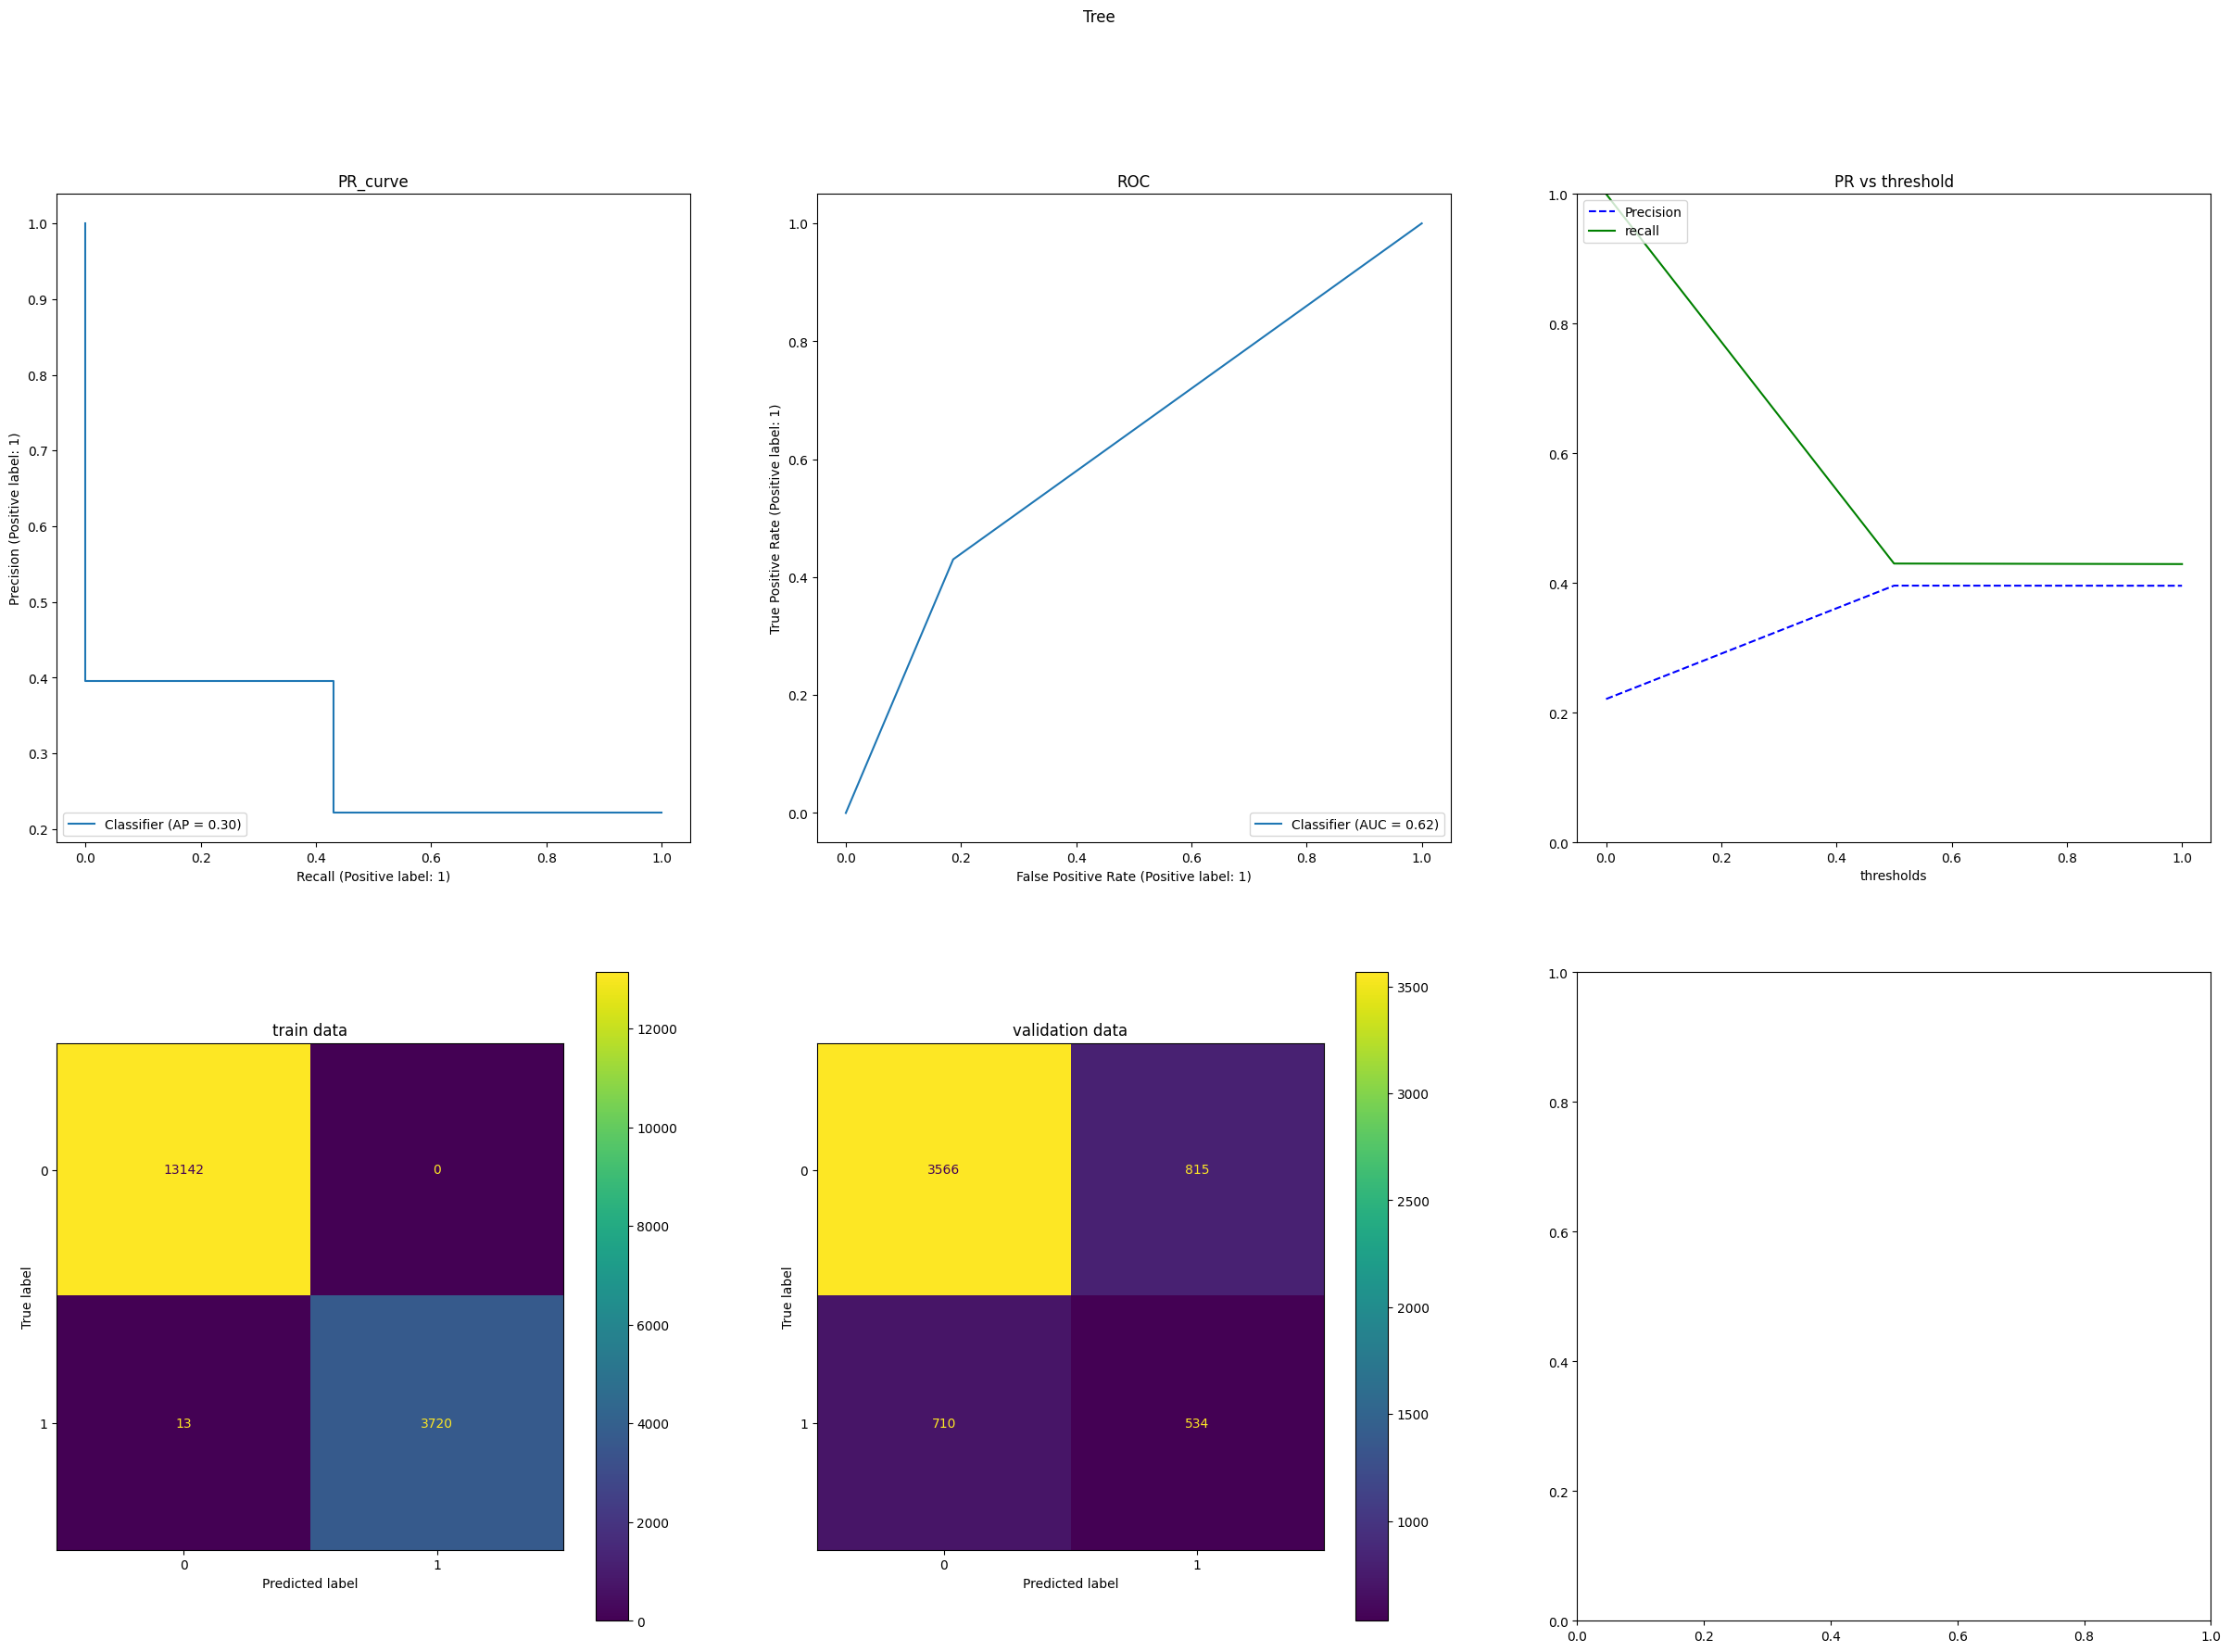

Forest
[[4115  266]
 [ 782  462]]

train scores
accuracy : 0.9992296296296296
precision : 0.9983922829581994
recall : 0.998124832574337
f1_score: 0.9982585398526458

Val scores
accuracy : 0.8136888888888889
precision : 0.6346153846153846
recall : 0.37138263665594856
f1_score: 0.46855983772819476


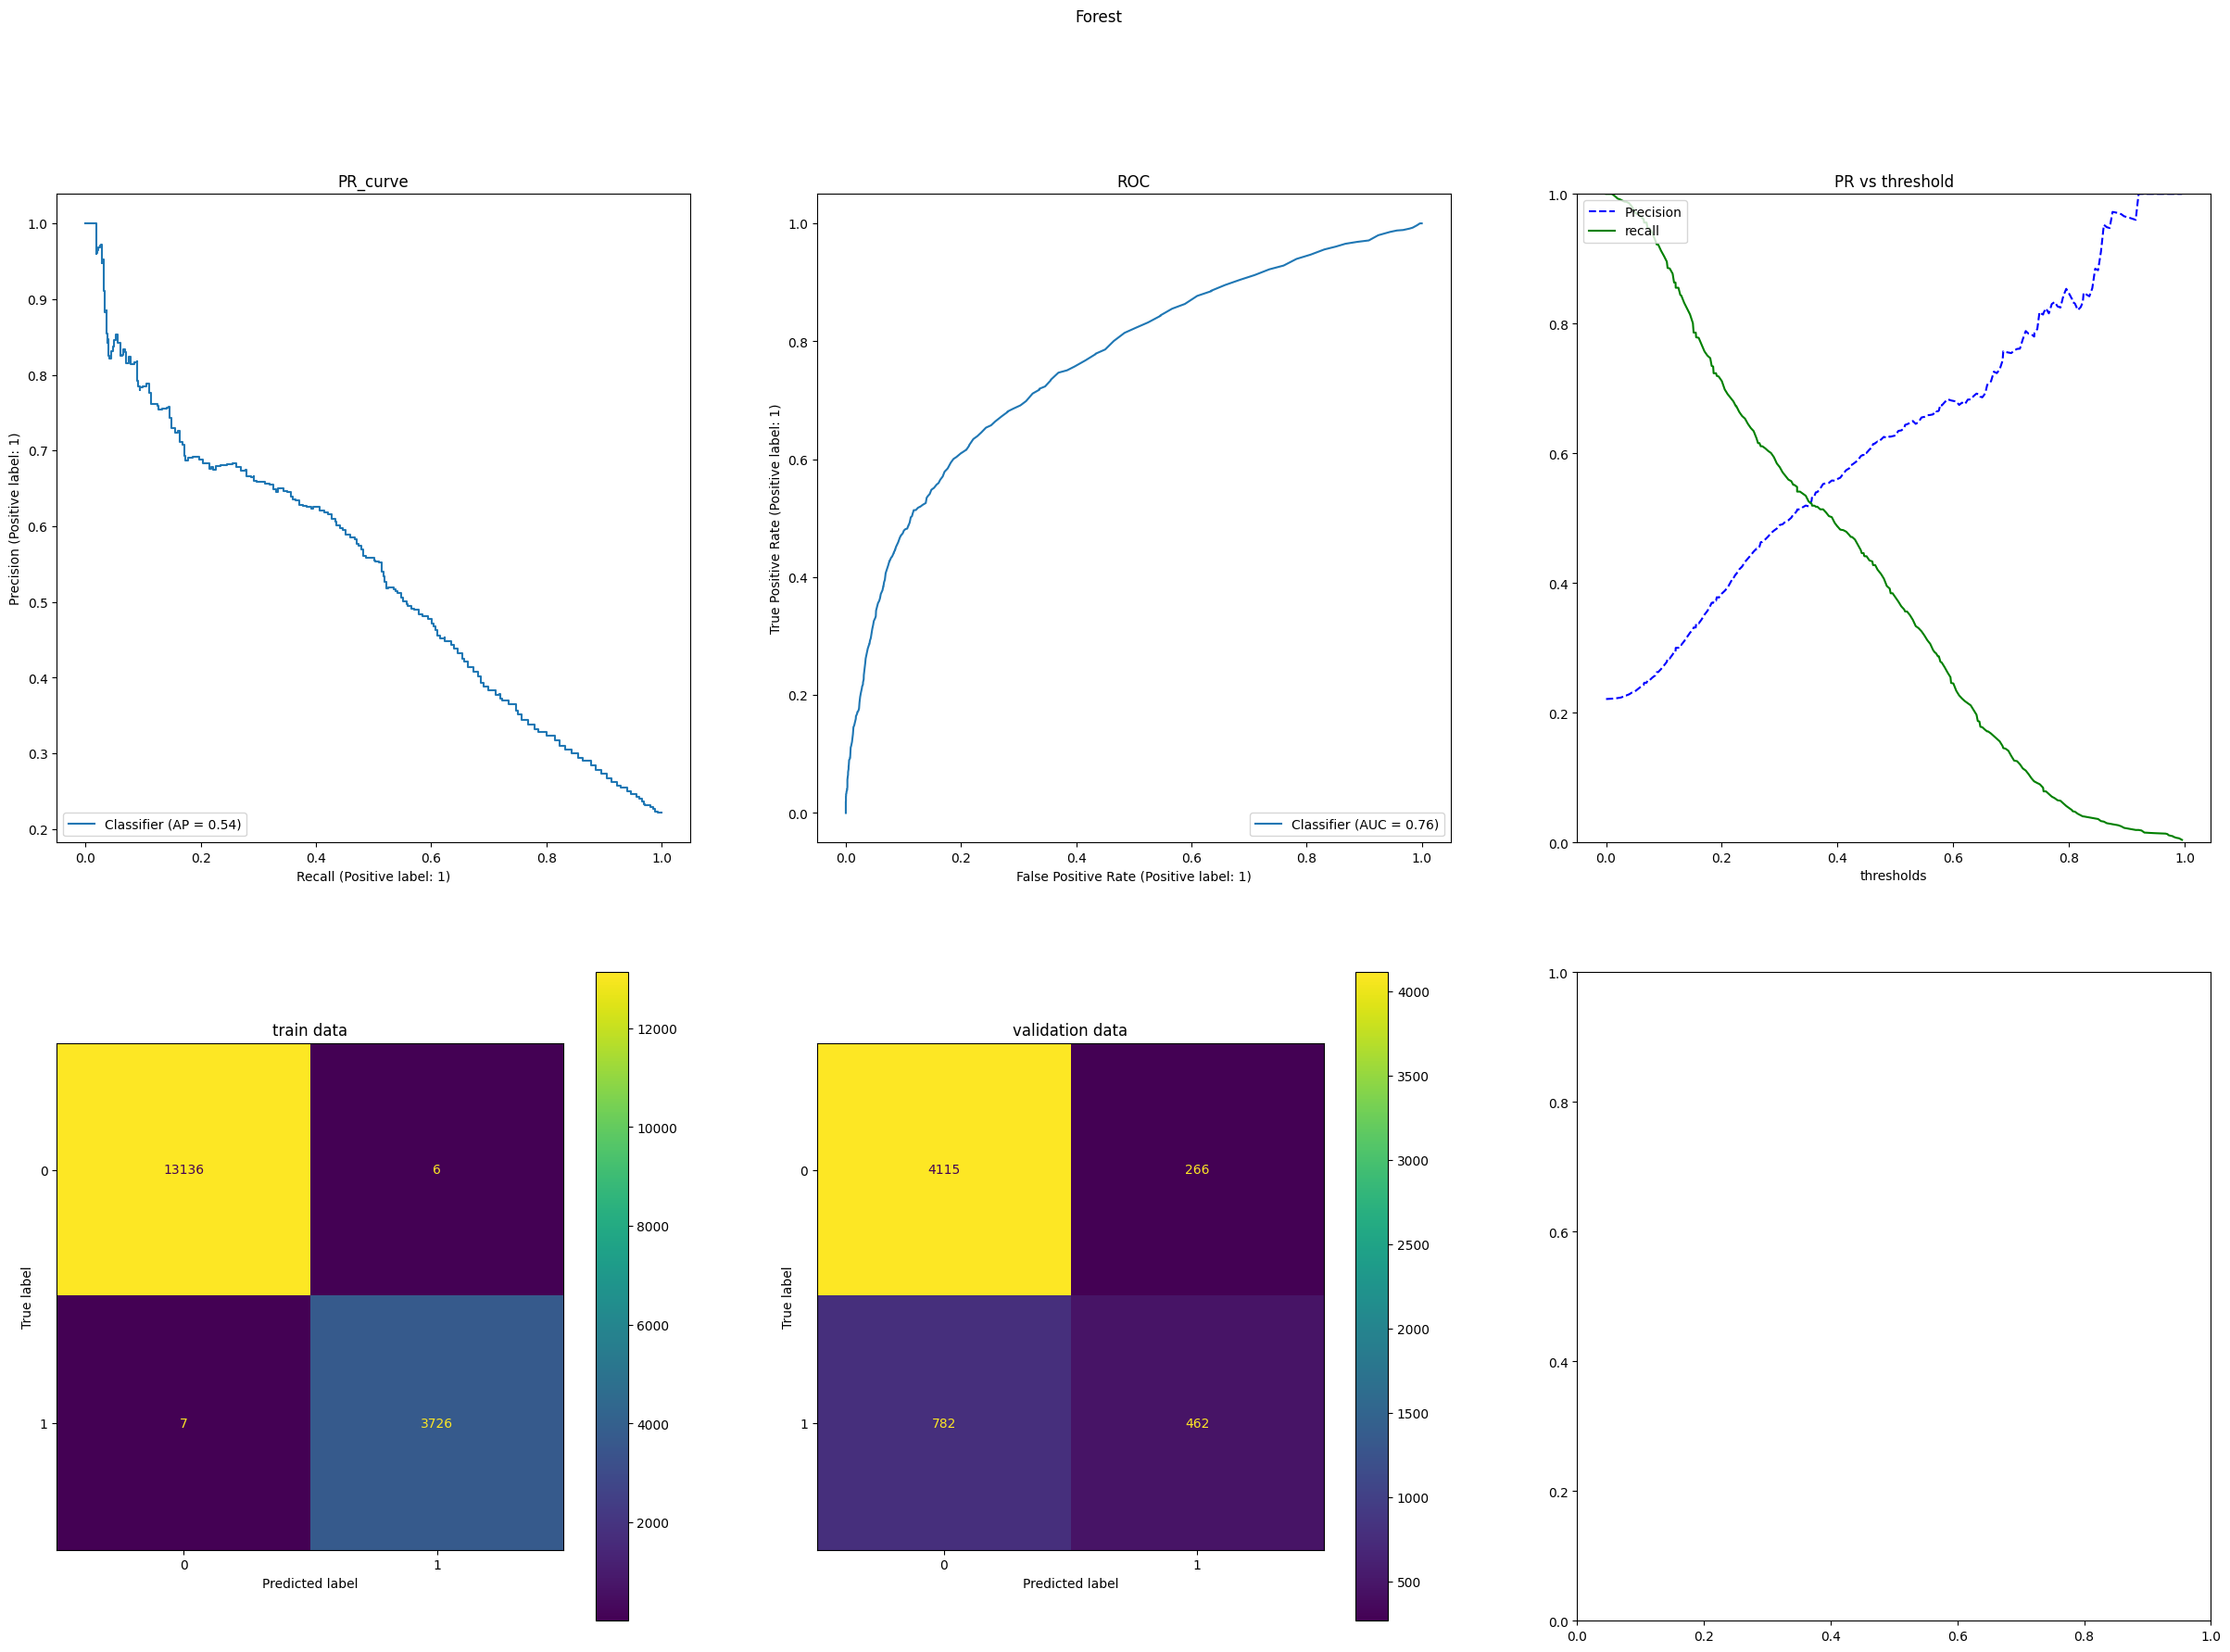

Ada
[[4145  236]
 [ 831  413]]

train scores
accuracy : 0.8139259259259259
precision : 0.6553169198533263
recall : 0.33511920707206
f1_score: 0.44345976604041115

Val scores
accuracy : 0.8103111111111111
precision : 0.6363636363636364
recall : 0.3319935691318328
f1_score: 0.4363444268357105


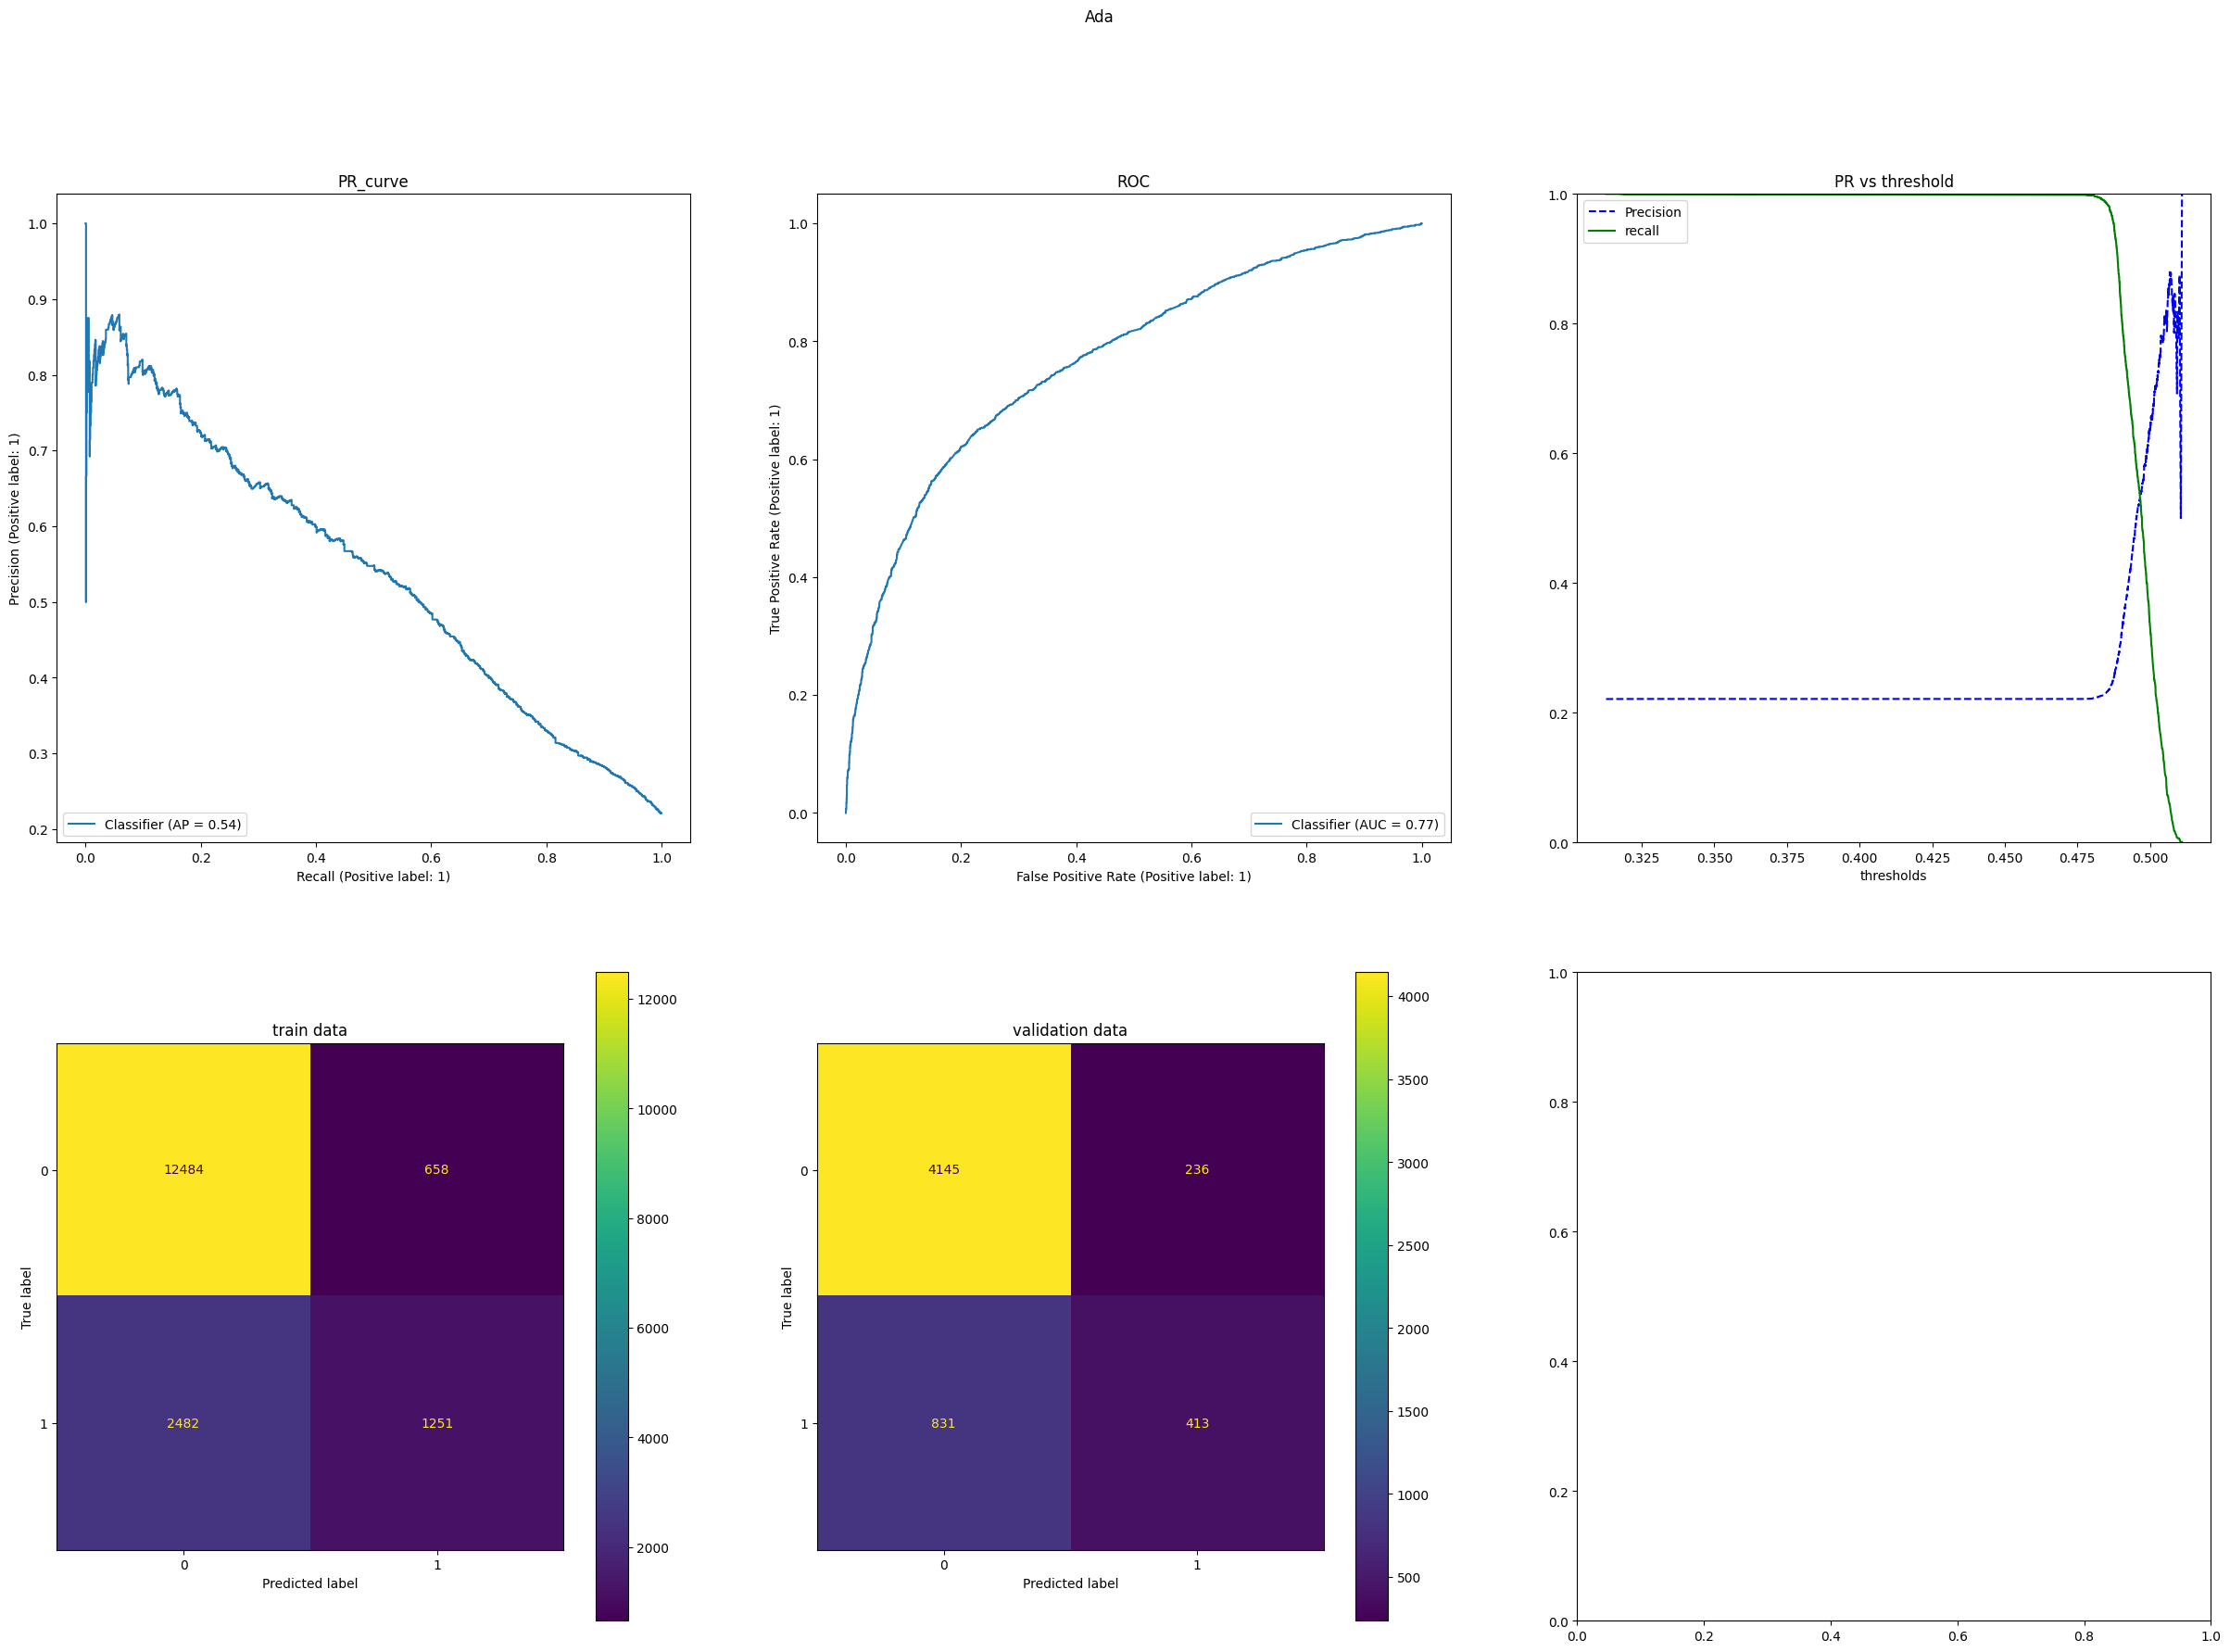

GdBoost
[[4140  241]
 [ 802  442]]

train scores
accuracy : 0.828562962962963
precision : 0.708540218470705
recall : 0.38226627377444417
f1_score: 0.49660692535235773

Val scores
accuracy : 0.8145777777777777
precision : 0.6471449487554904
recall : 0.3553054662379421
f1_score: 0.4587441619097042


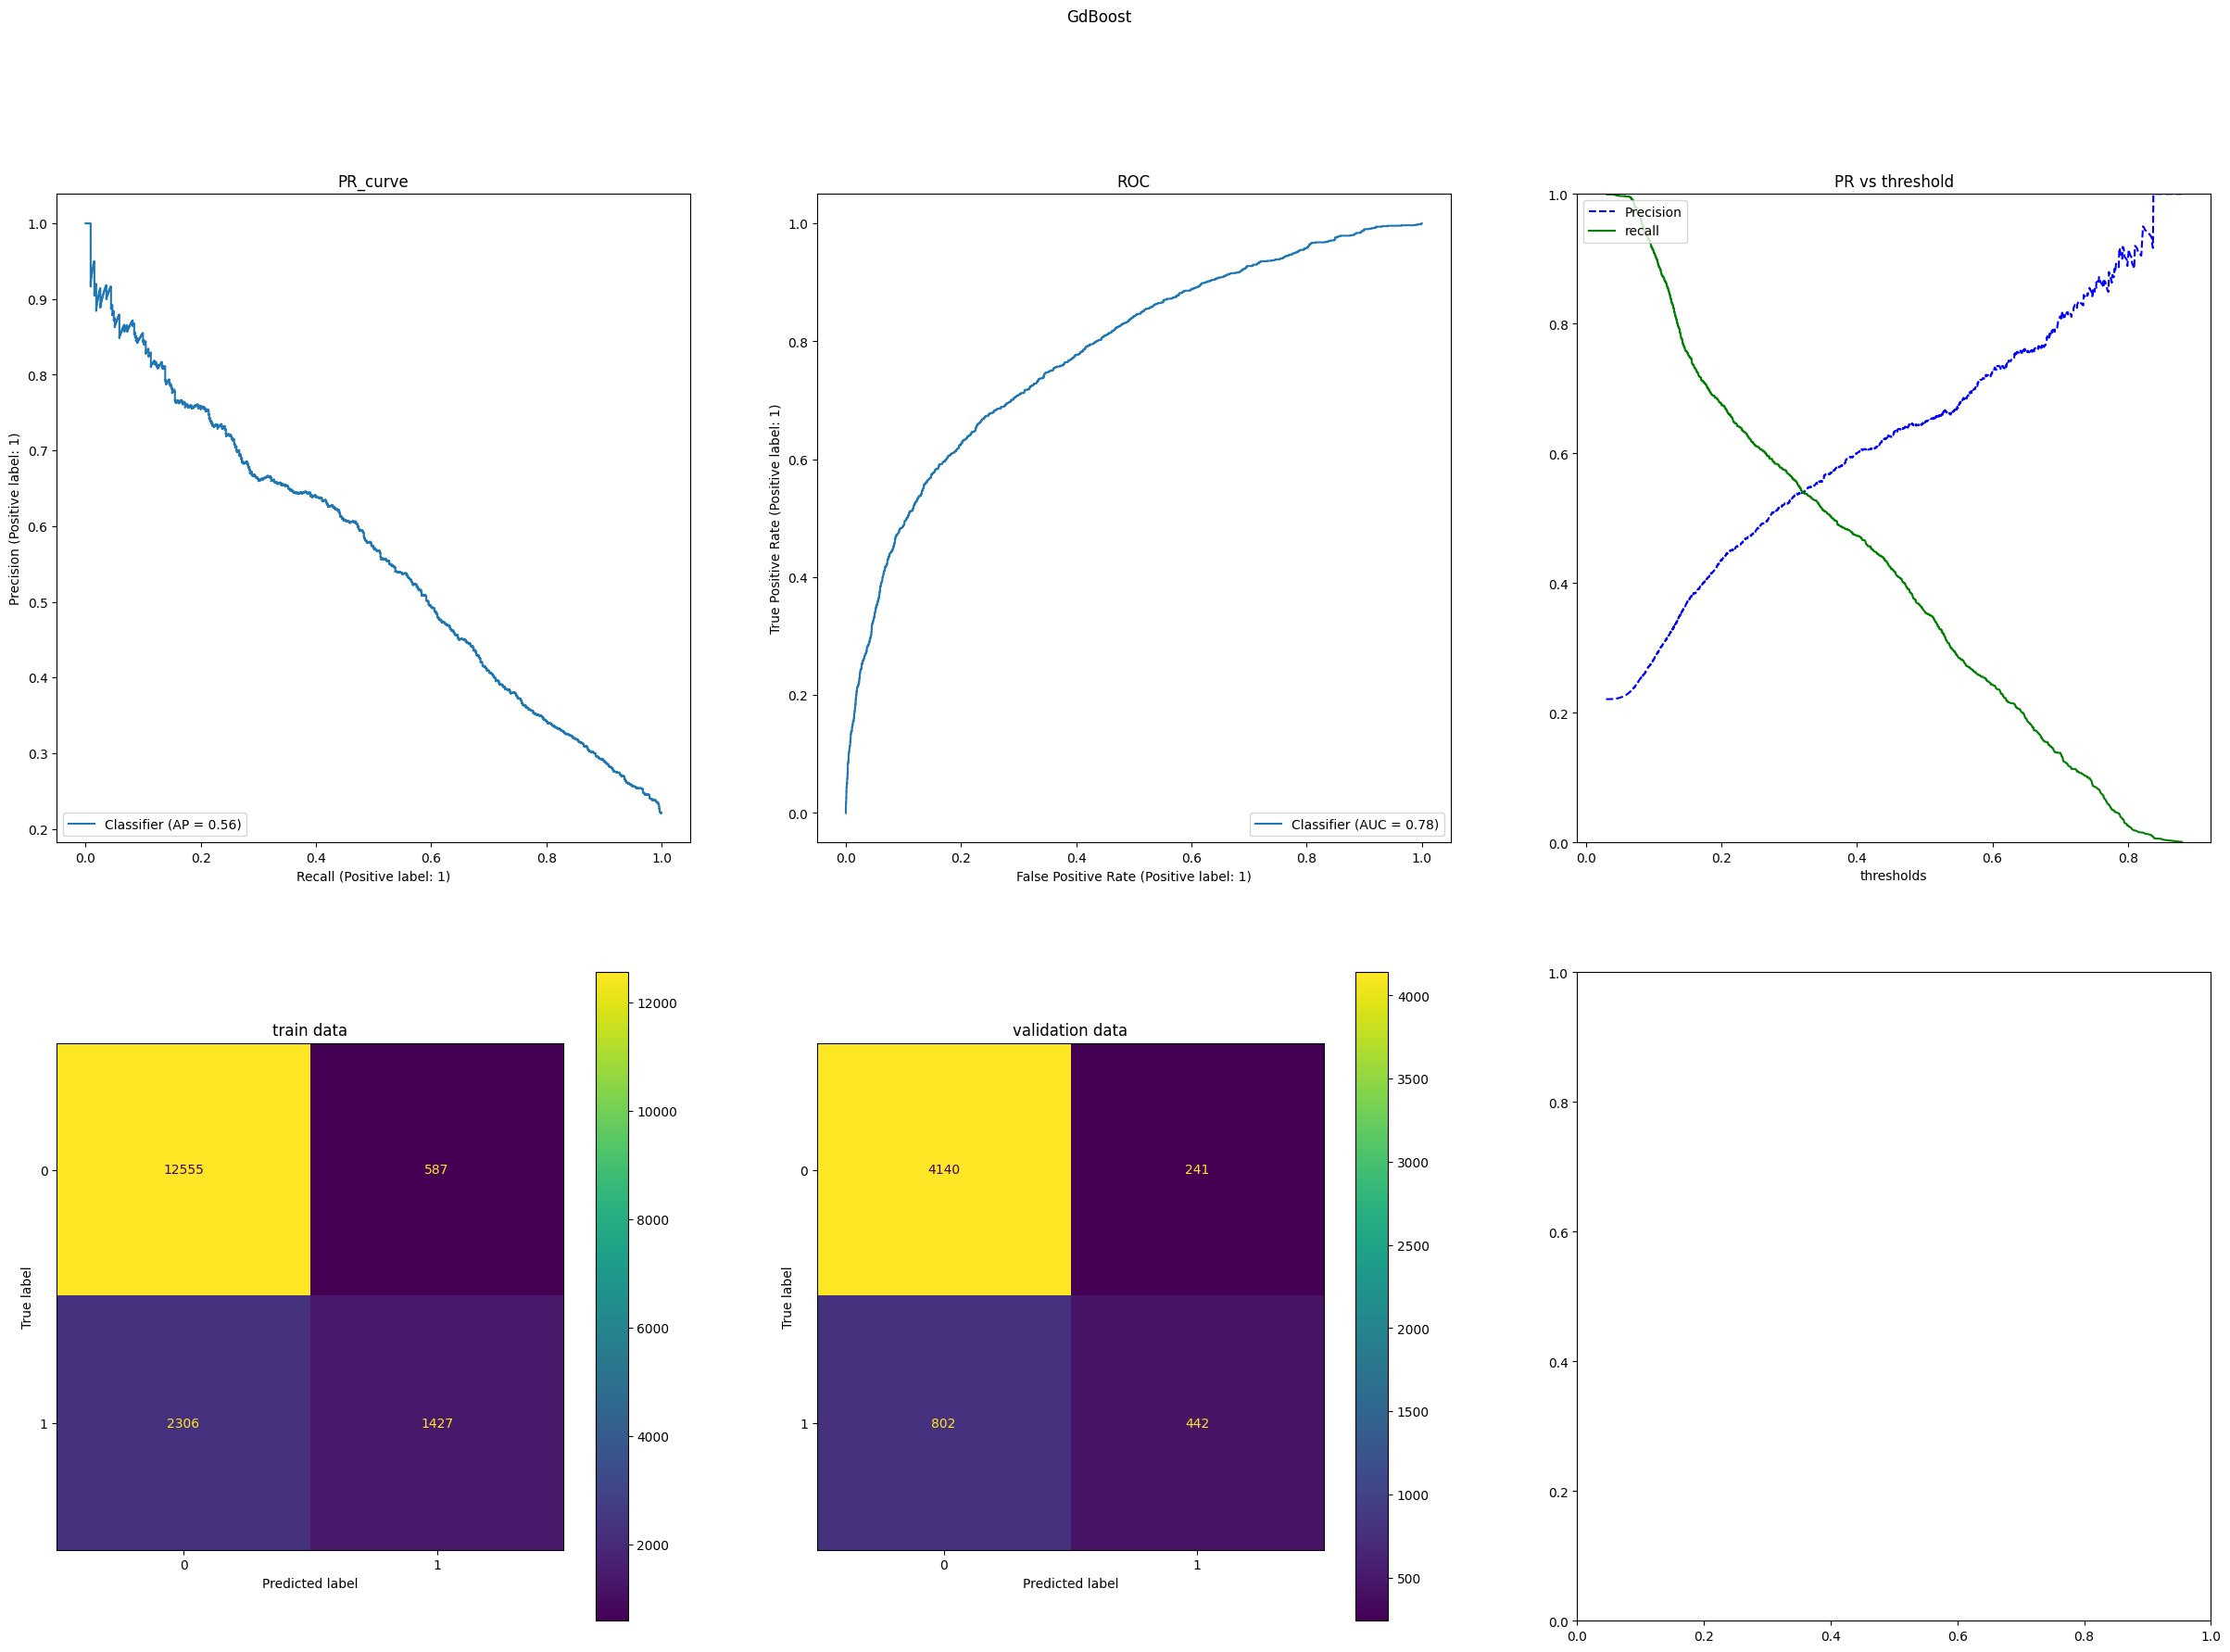

In [ ]:
my_base_transform = BasicTransformer()
clfs = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=200,random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]
clf_names = ['Tree',
            'Forest',
            'Ada',
            'GdBoost'
]

pipe_transform = Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

#Computation
results = []
for clf in clfs:
    pipe = Pipeline([('transform',pipe_transform),
                    ('clf',clf)])
    pipe.fit(X_train,y_train)
    train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)
    score_val = pipe.predict_proba(X_val)[:,1]
    results.append({'train':train_pred,'val':val_pred,'score':score_val})

#evaluation
for clf_name,result in zip(clf_names , results):
    print(clf_name)
    cf_matrix_t = confusion_matrix(y_train,result['train'])
    cf_matrix_v = confusion_matrix(y_val,result['val'])
    print(cf_matrix_v)
    print('\n'+'train scores')
    my_score(y_train,result['train'])
    print('\n'+'Val scores')
    my_score(y_val,result['val'])
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    RocCurveDisplay.from_predictions(y_val,result['score'],ax=axes[0,1])
    display = PrecisionRecallDisplay.from_predictions(y_val,result['score'],ax=axes[0,0])
    # display.plot(cmap=plt.cm.Blues,cmap=plt.cm.Blues,ax=axes[0,0])
    display = ConfusionMatrixDisplay(cf_matrix_t)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
    display = ConfusionMatrixDisplay(cf_matrix_v)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
    axes[0,1].set_title('ROC')
    axes[0,0].set_title('PR_curve')
    axes[1,0].set_title('train data')
    axes[1,1].set_title('validation data')
    precisions , recalls , thresholds = precision_recall_curve(y_val, result['score'])
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
    axes[0,2].set_title('PR vs threshold')
    fig.suptitle(f'{clf_name}')
    plt.show()
    plt.close()

## Less data performs better on no adjustment

Tree
[[3571  810]
 [ 736  508]]

train scores
accuracy : 0.9995259259259259
precision : 1.0
recall : 0.997856951513528
f1_score: 0.9989273263609547

Val scores
accuracy : 0.7251555555555556
precision : 0.38543247344461307
recall : 0.40836012861736337
f1_score: 0.39656518345042935


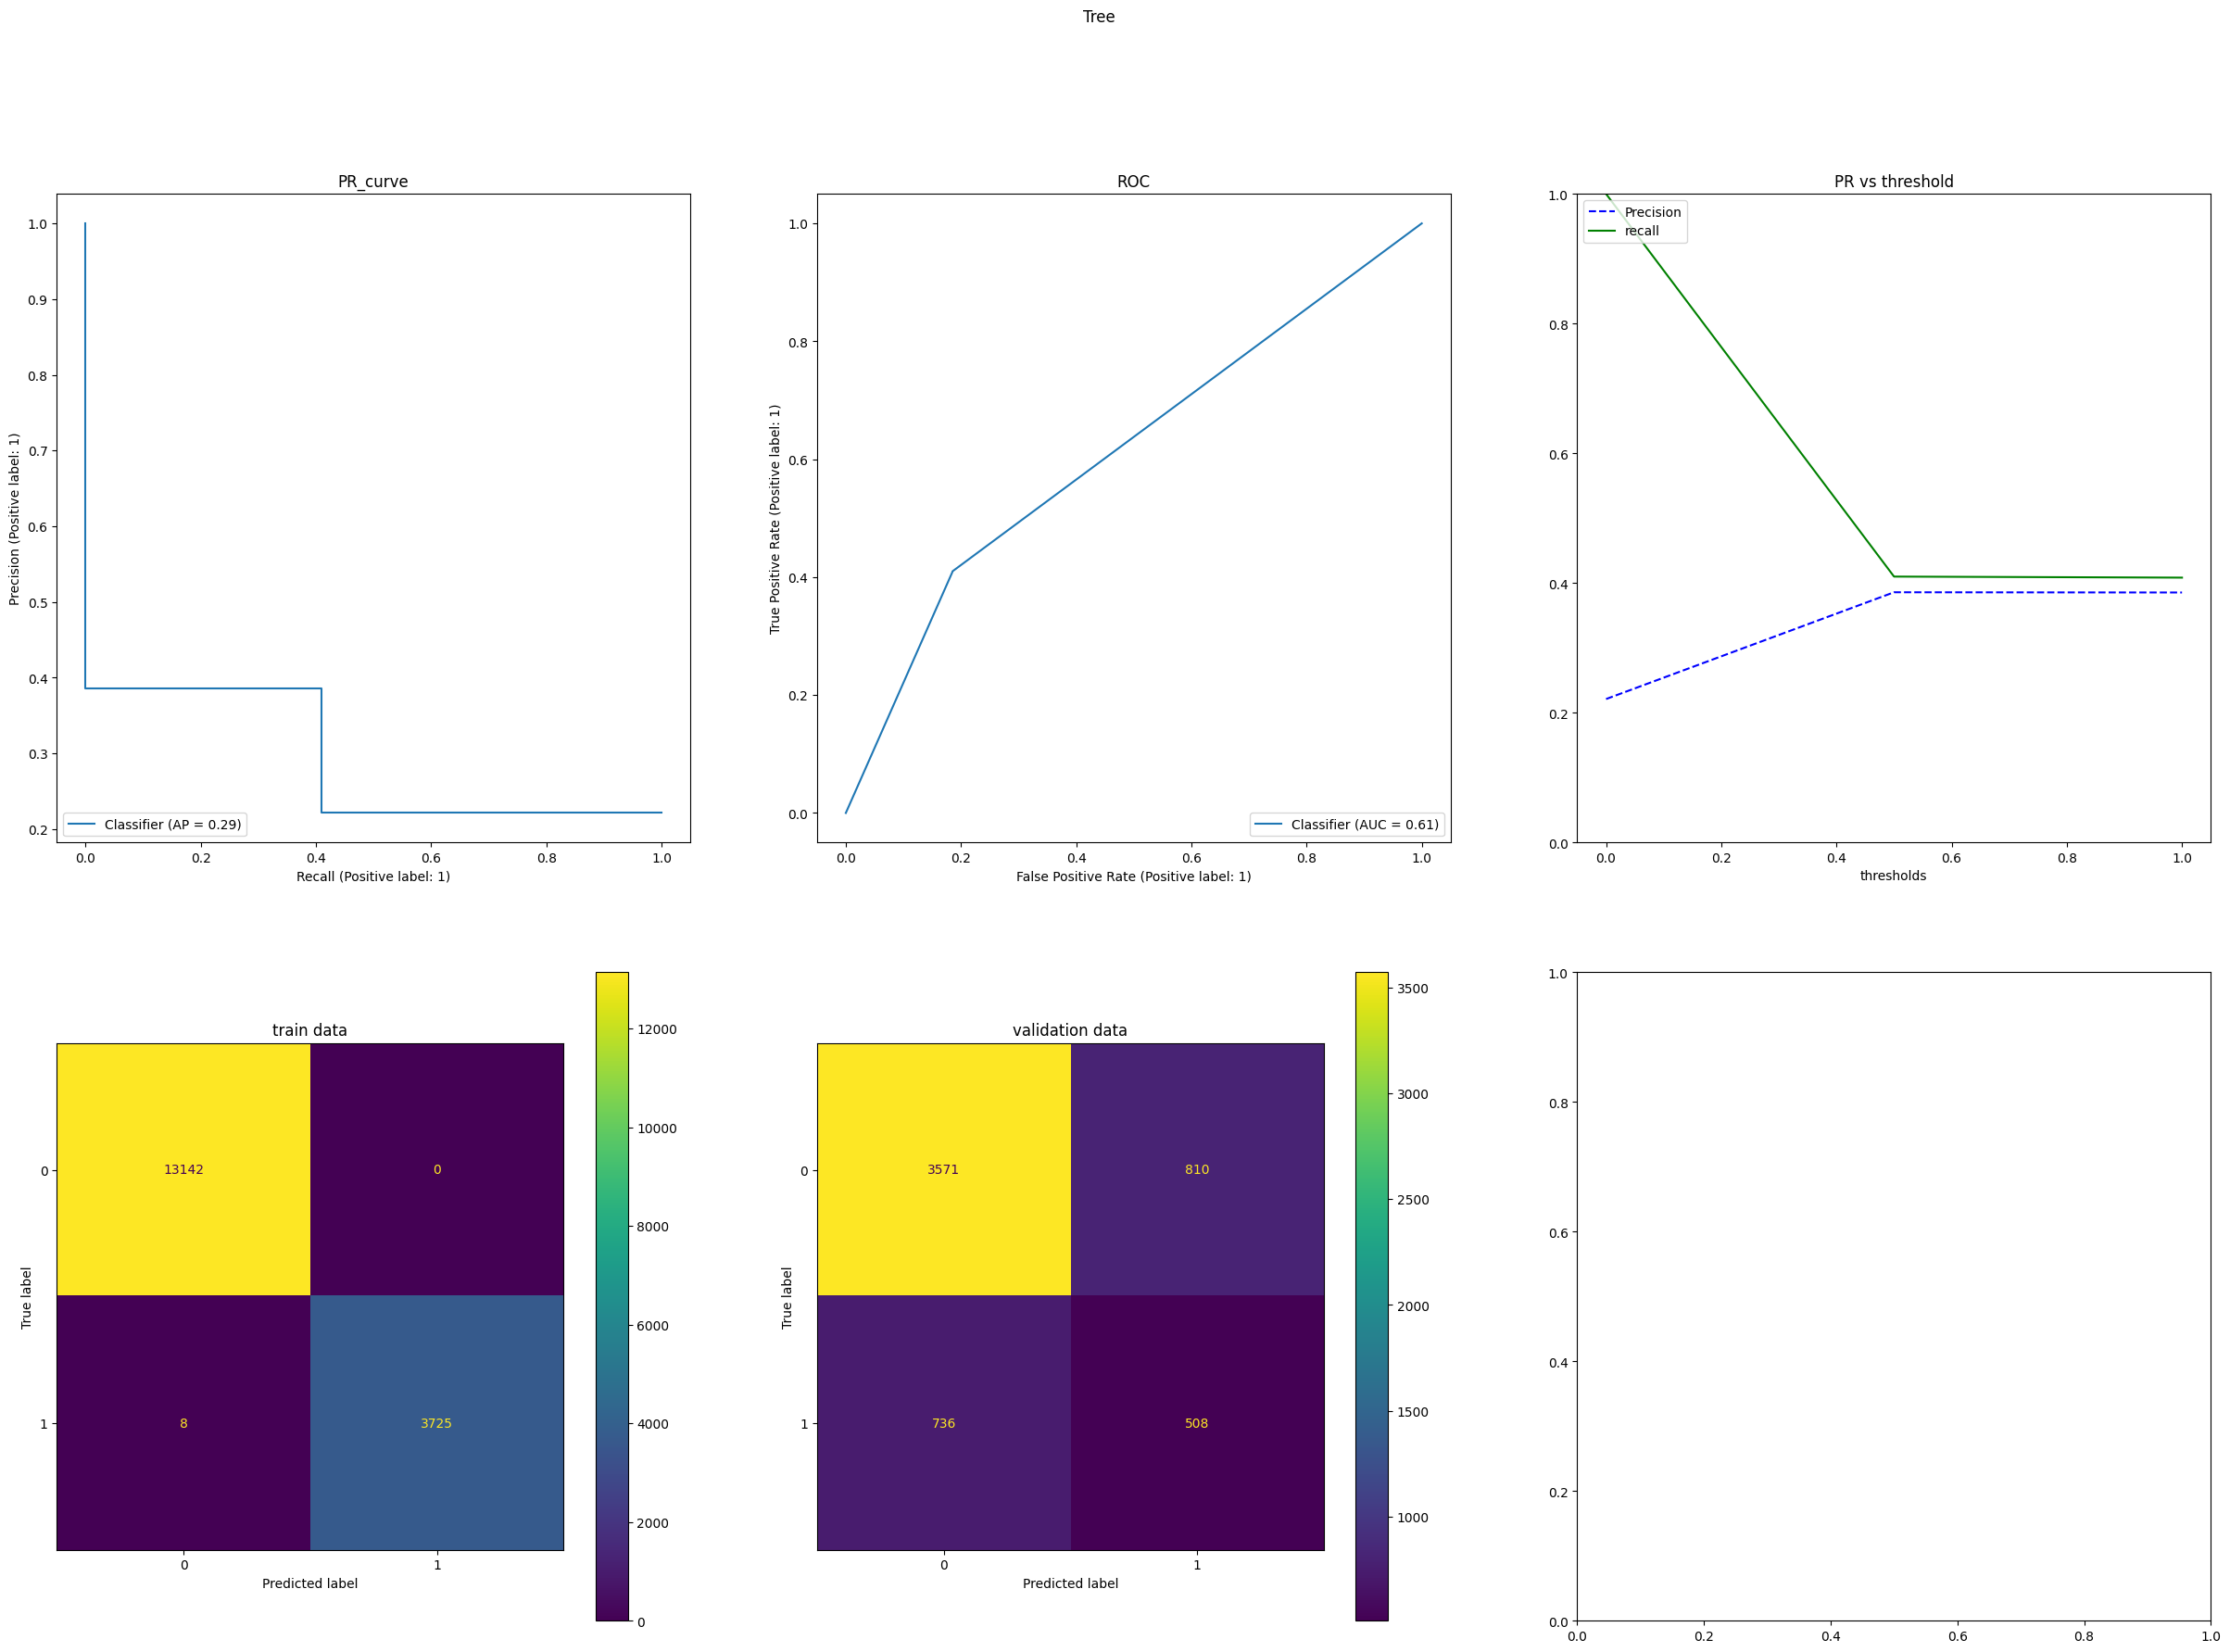

Forest
[[4124  257]
 [ 770  474]]

train scores
accuracy : 0.9995259259259259
precision : 0.9991959260251944
recall : 0.998660594695955
f1_score: 0.9989281886387995

Val scores
accuracy : 0.8174222222222223
precision : 0.6484268125854993
recall : 0.38102893890675243
f1_score: 0.48


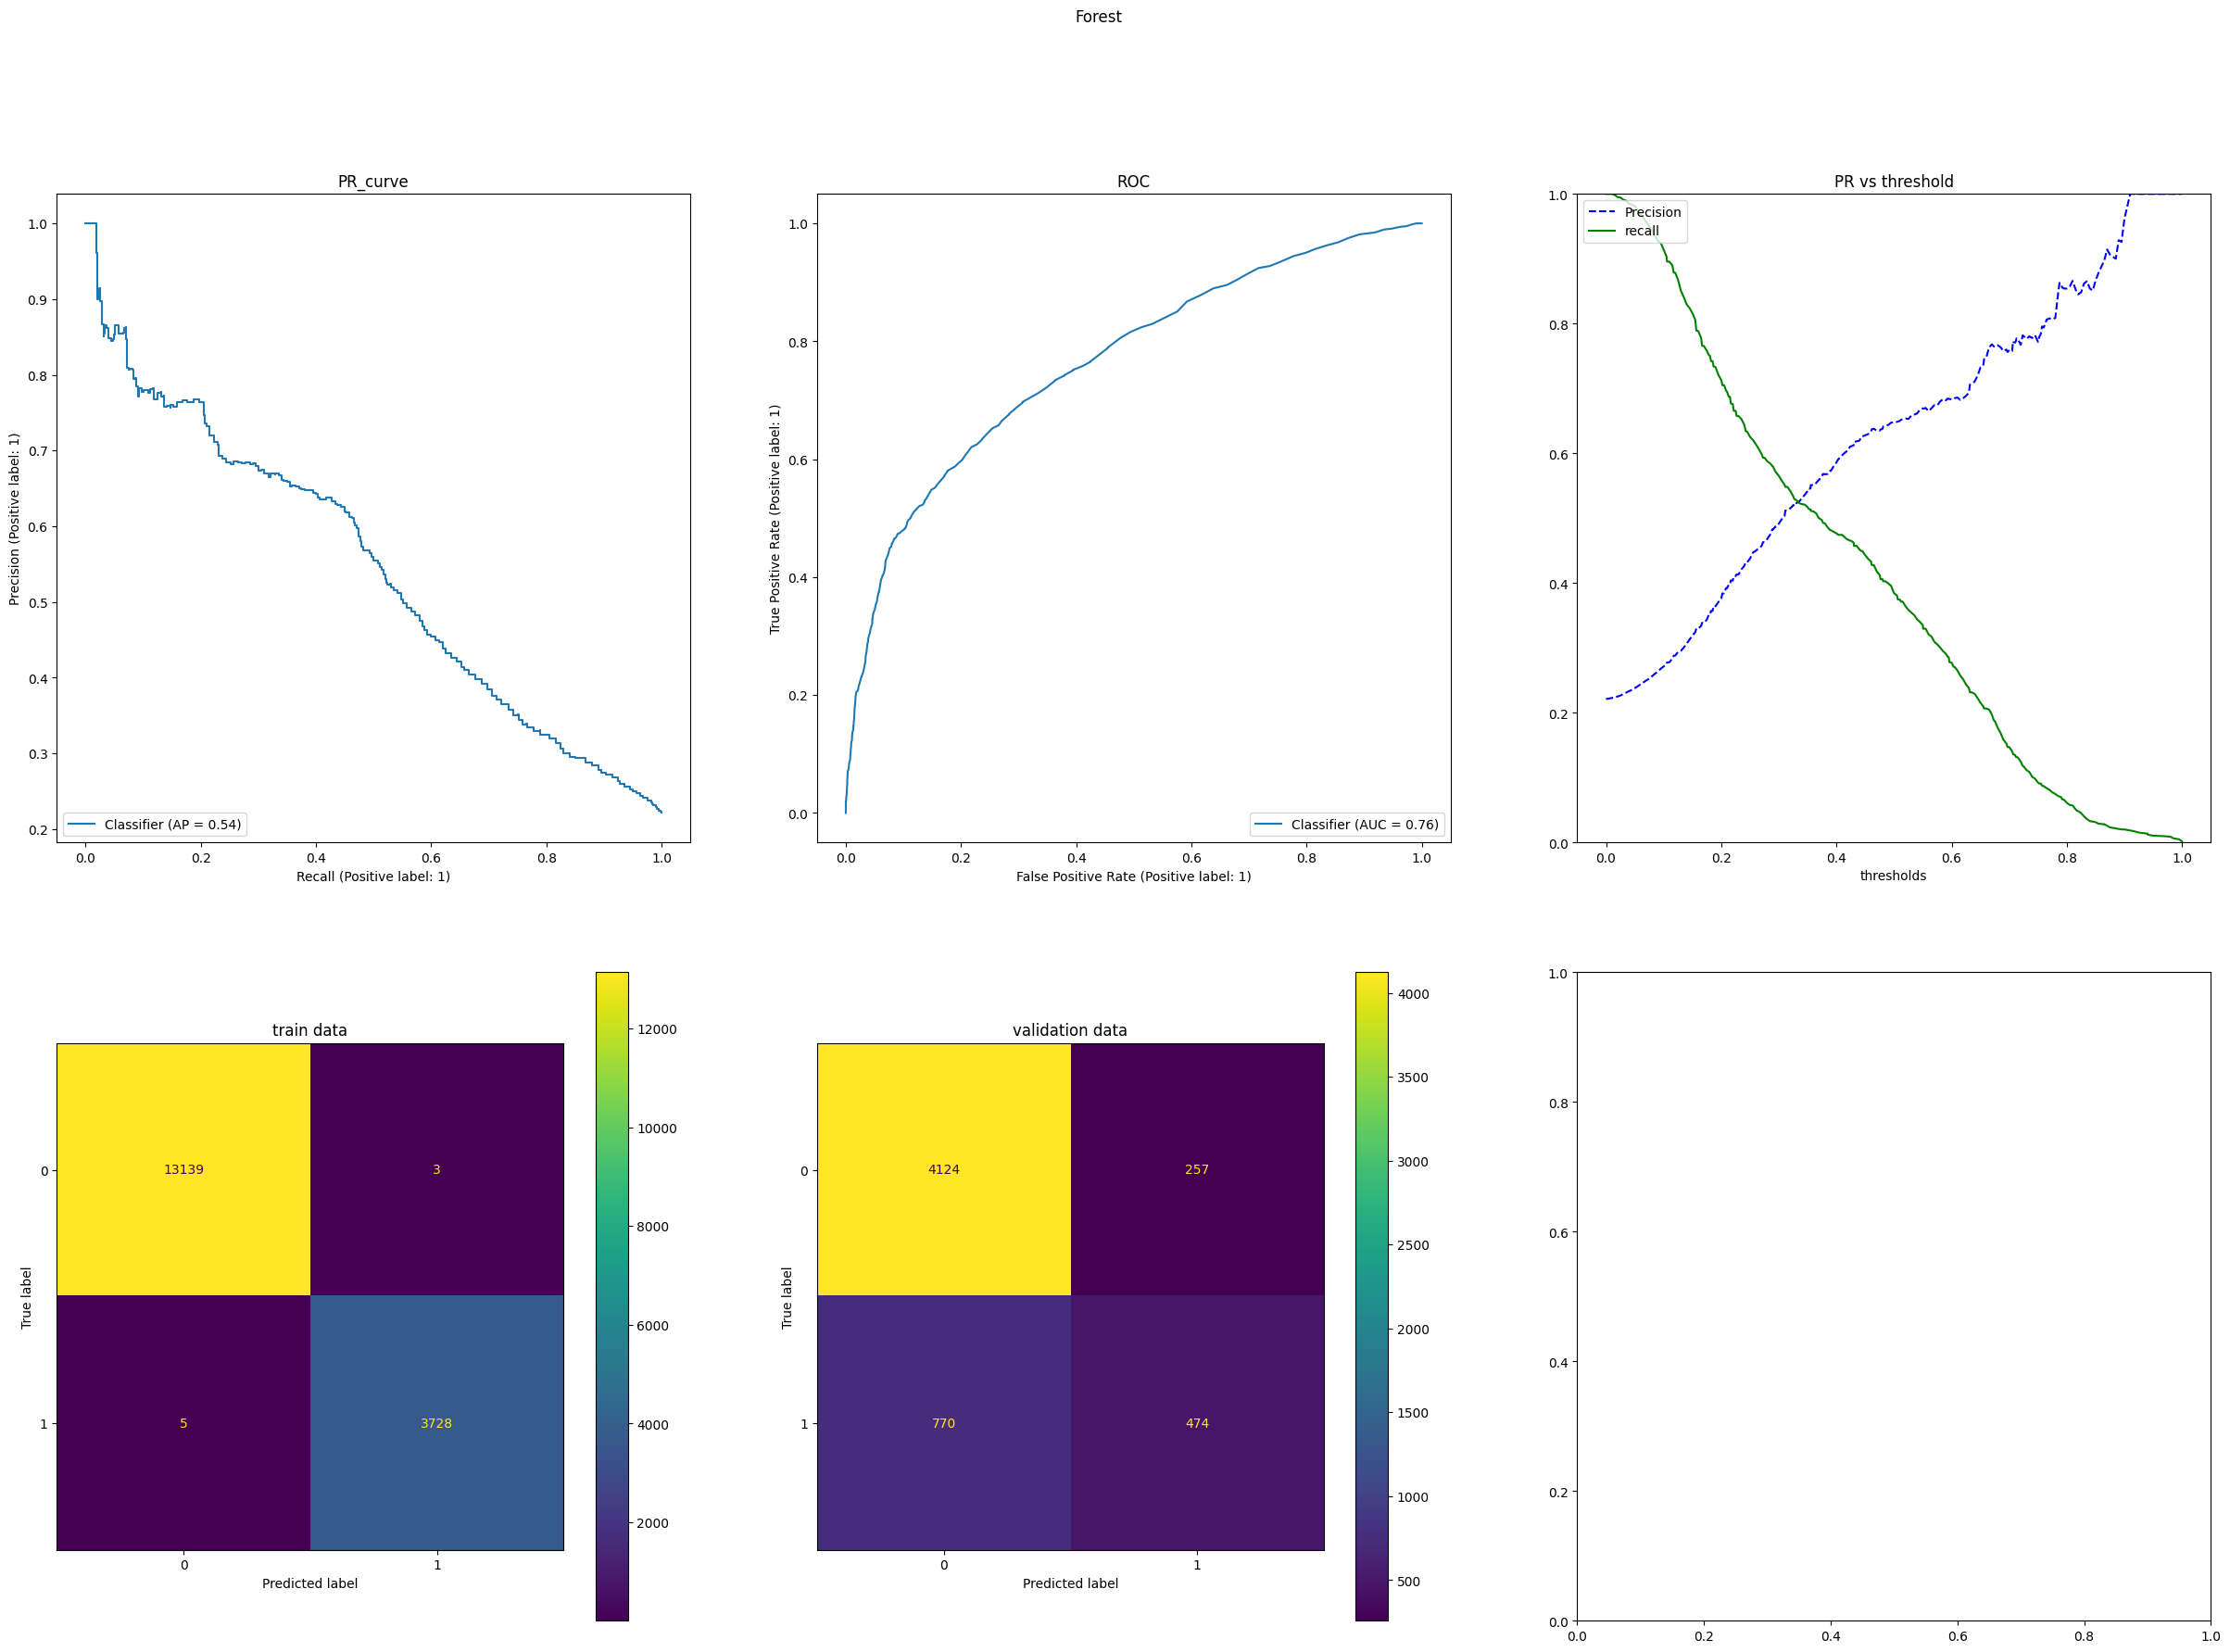

Ada
[[4192  189]
 [ 817  427]]

train scores
accuracy : 0.8184296296296296
precision : 0.6925734024179621
recall : 0.322260916153228
f1_score: 0.439853747714808

Val scores
accuracy : 0.8211555555555555
precision : 0.6931818181818182
recall : 0.3432475884244373
f1_score: 0.4591397849462366


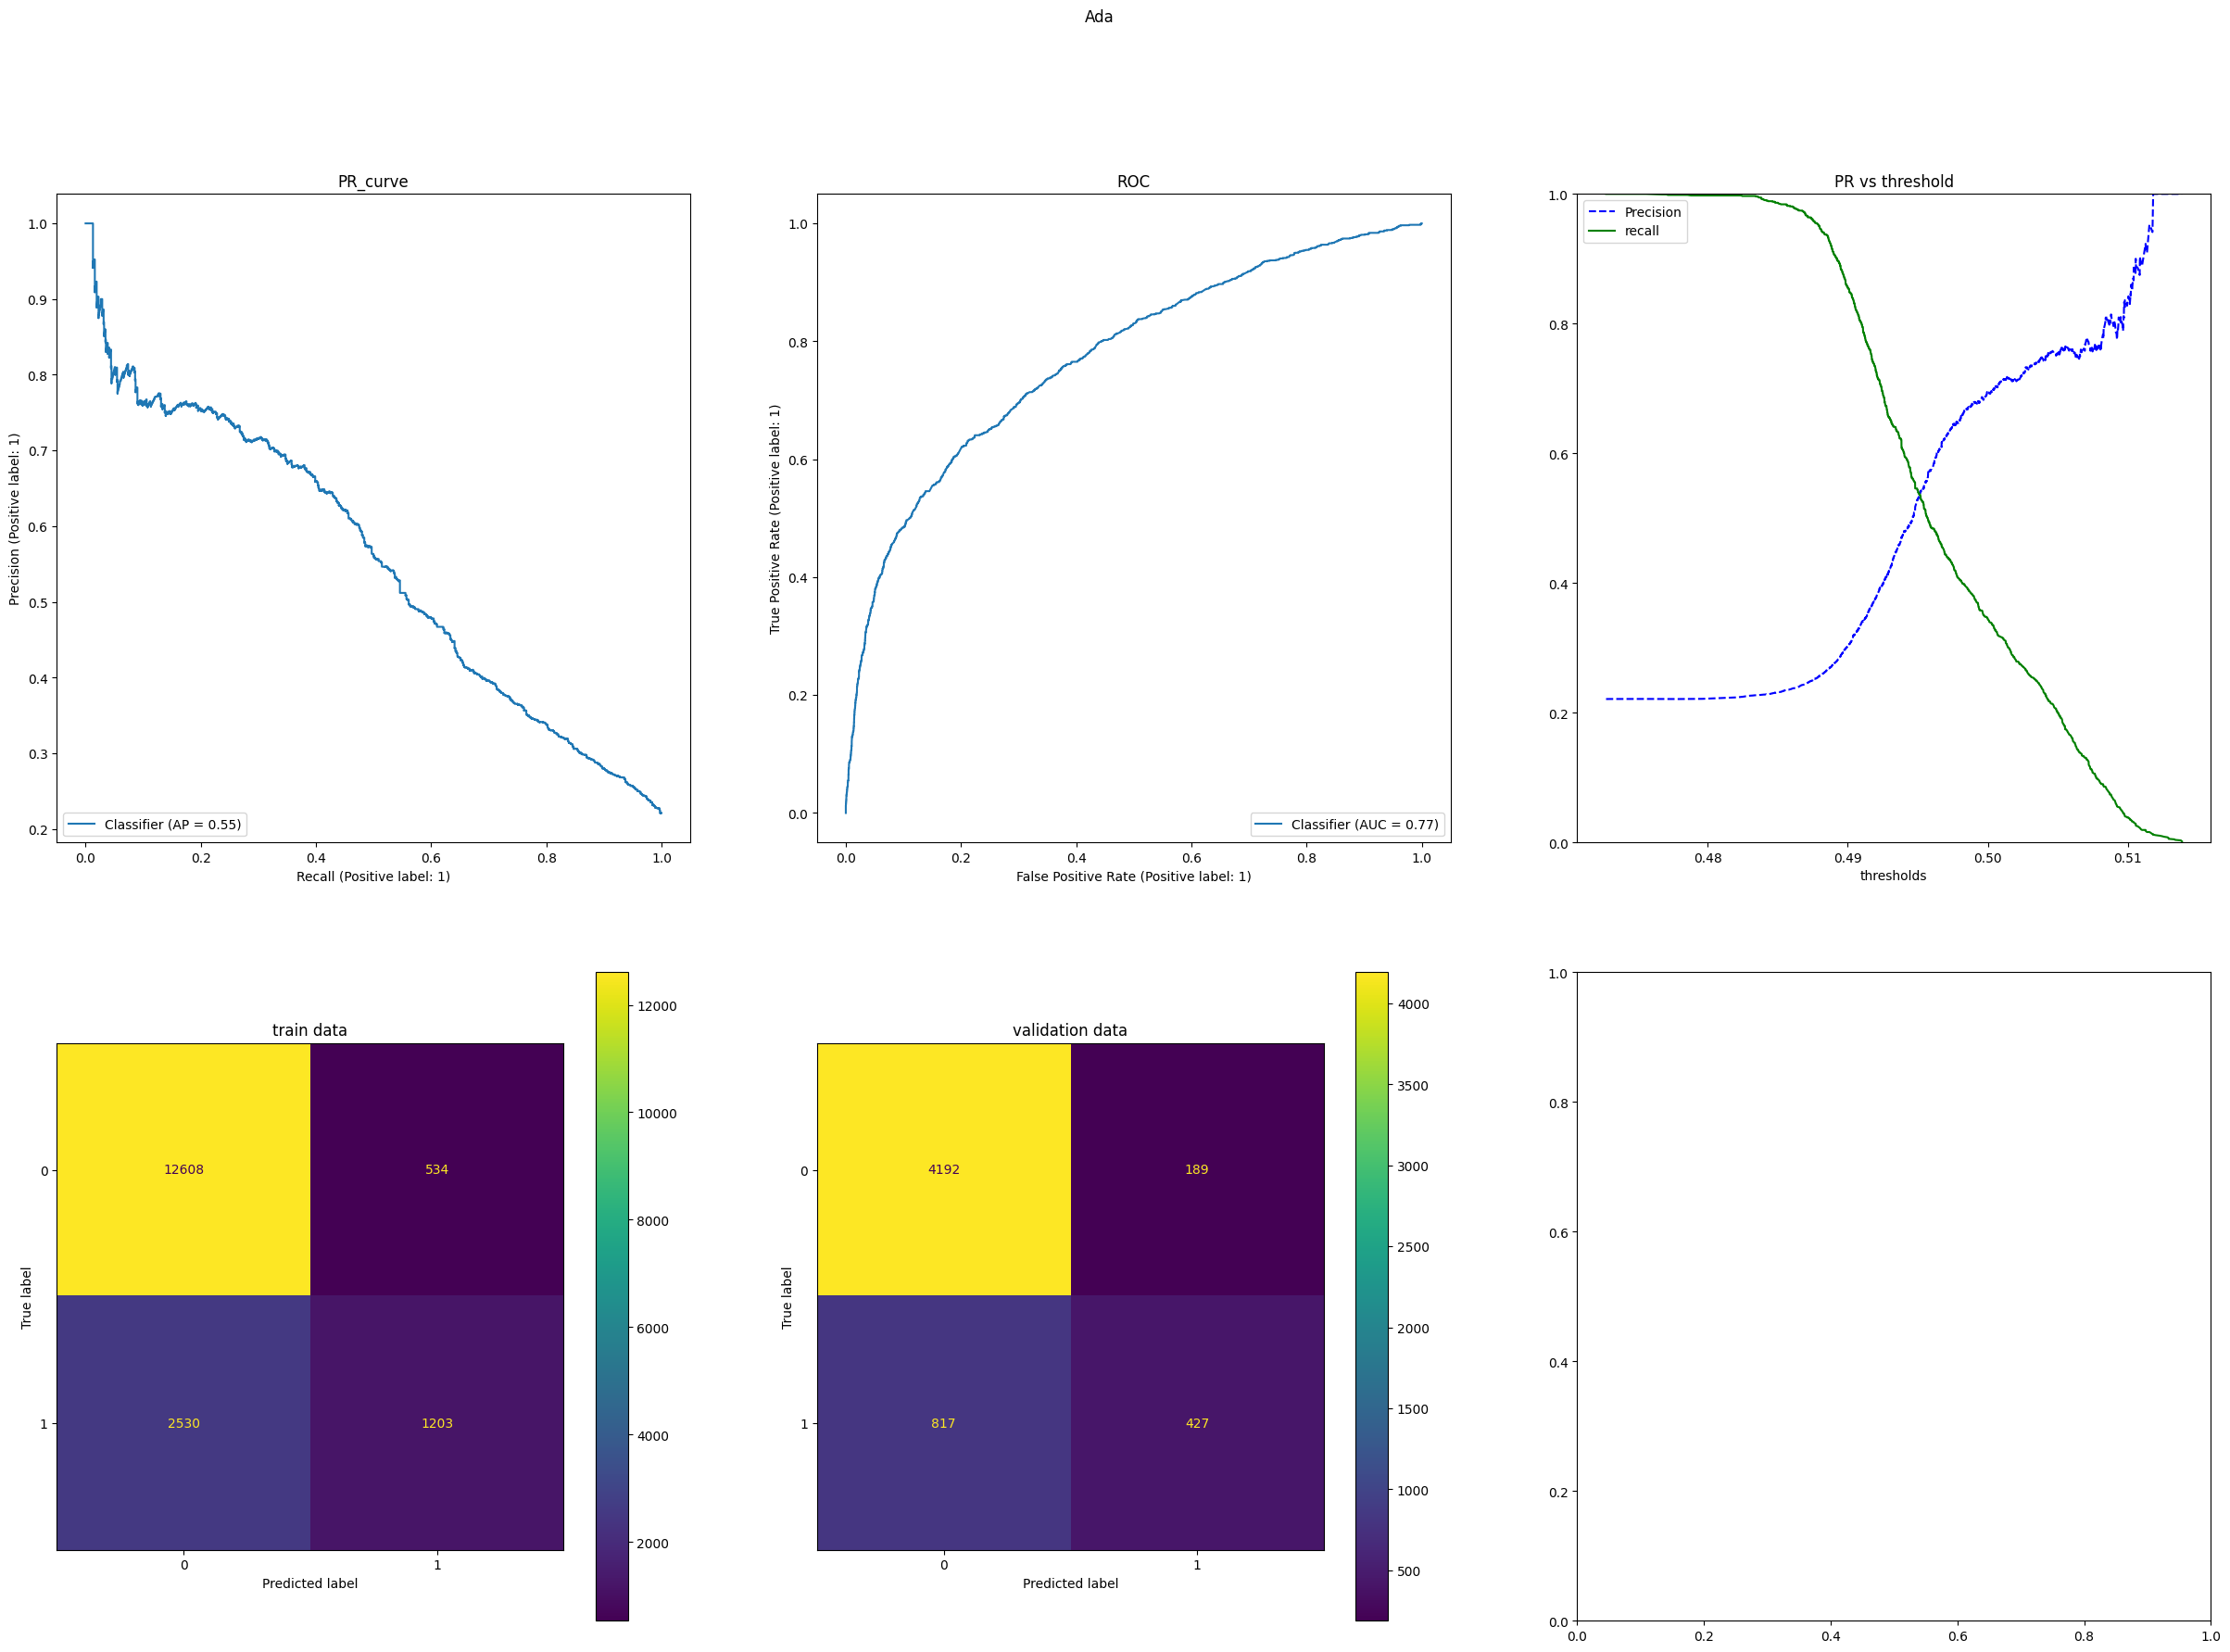

GdBoost
[[4162  219]
 [ 777  467]]

train scores
accuracy : 0.828562962962963
precision : 0.7091633466135459
recall : 0.3814626305920171
f1_score: 0.49608082215641874

Val scores
accuracy : 0.8229333333333333
precision : 0.6807580174927114
recall : 0.3754019292604502
f1_score: 0.4839378238341969


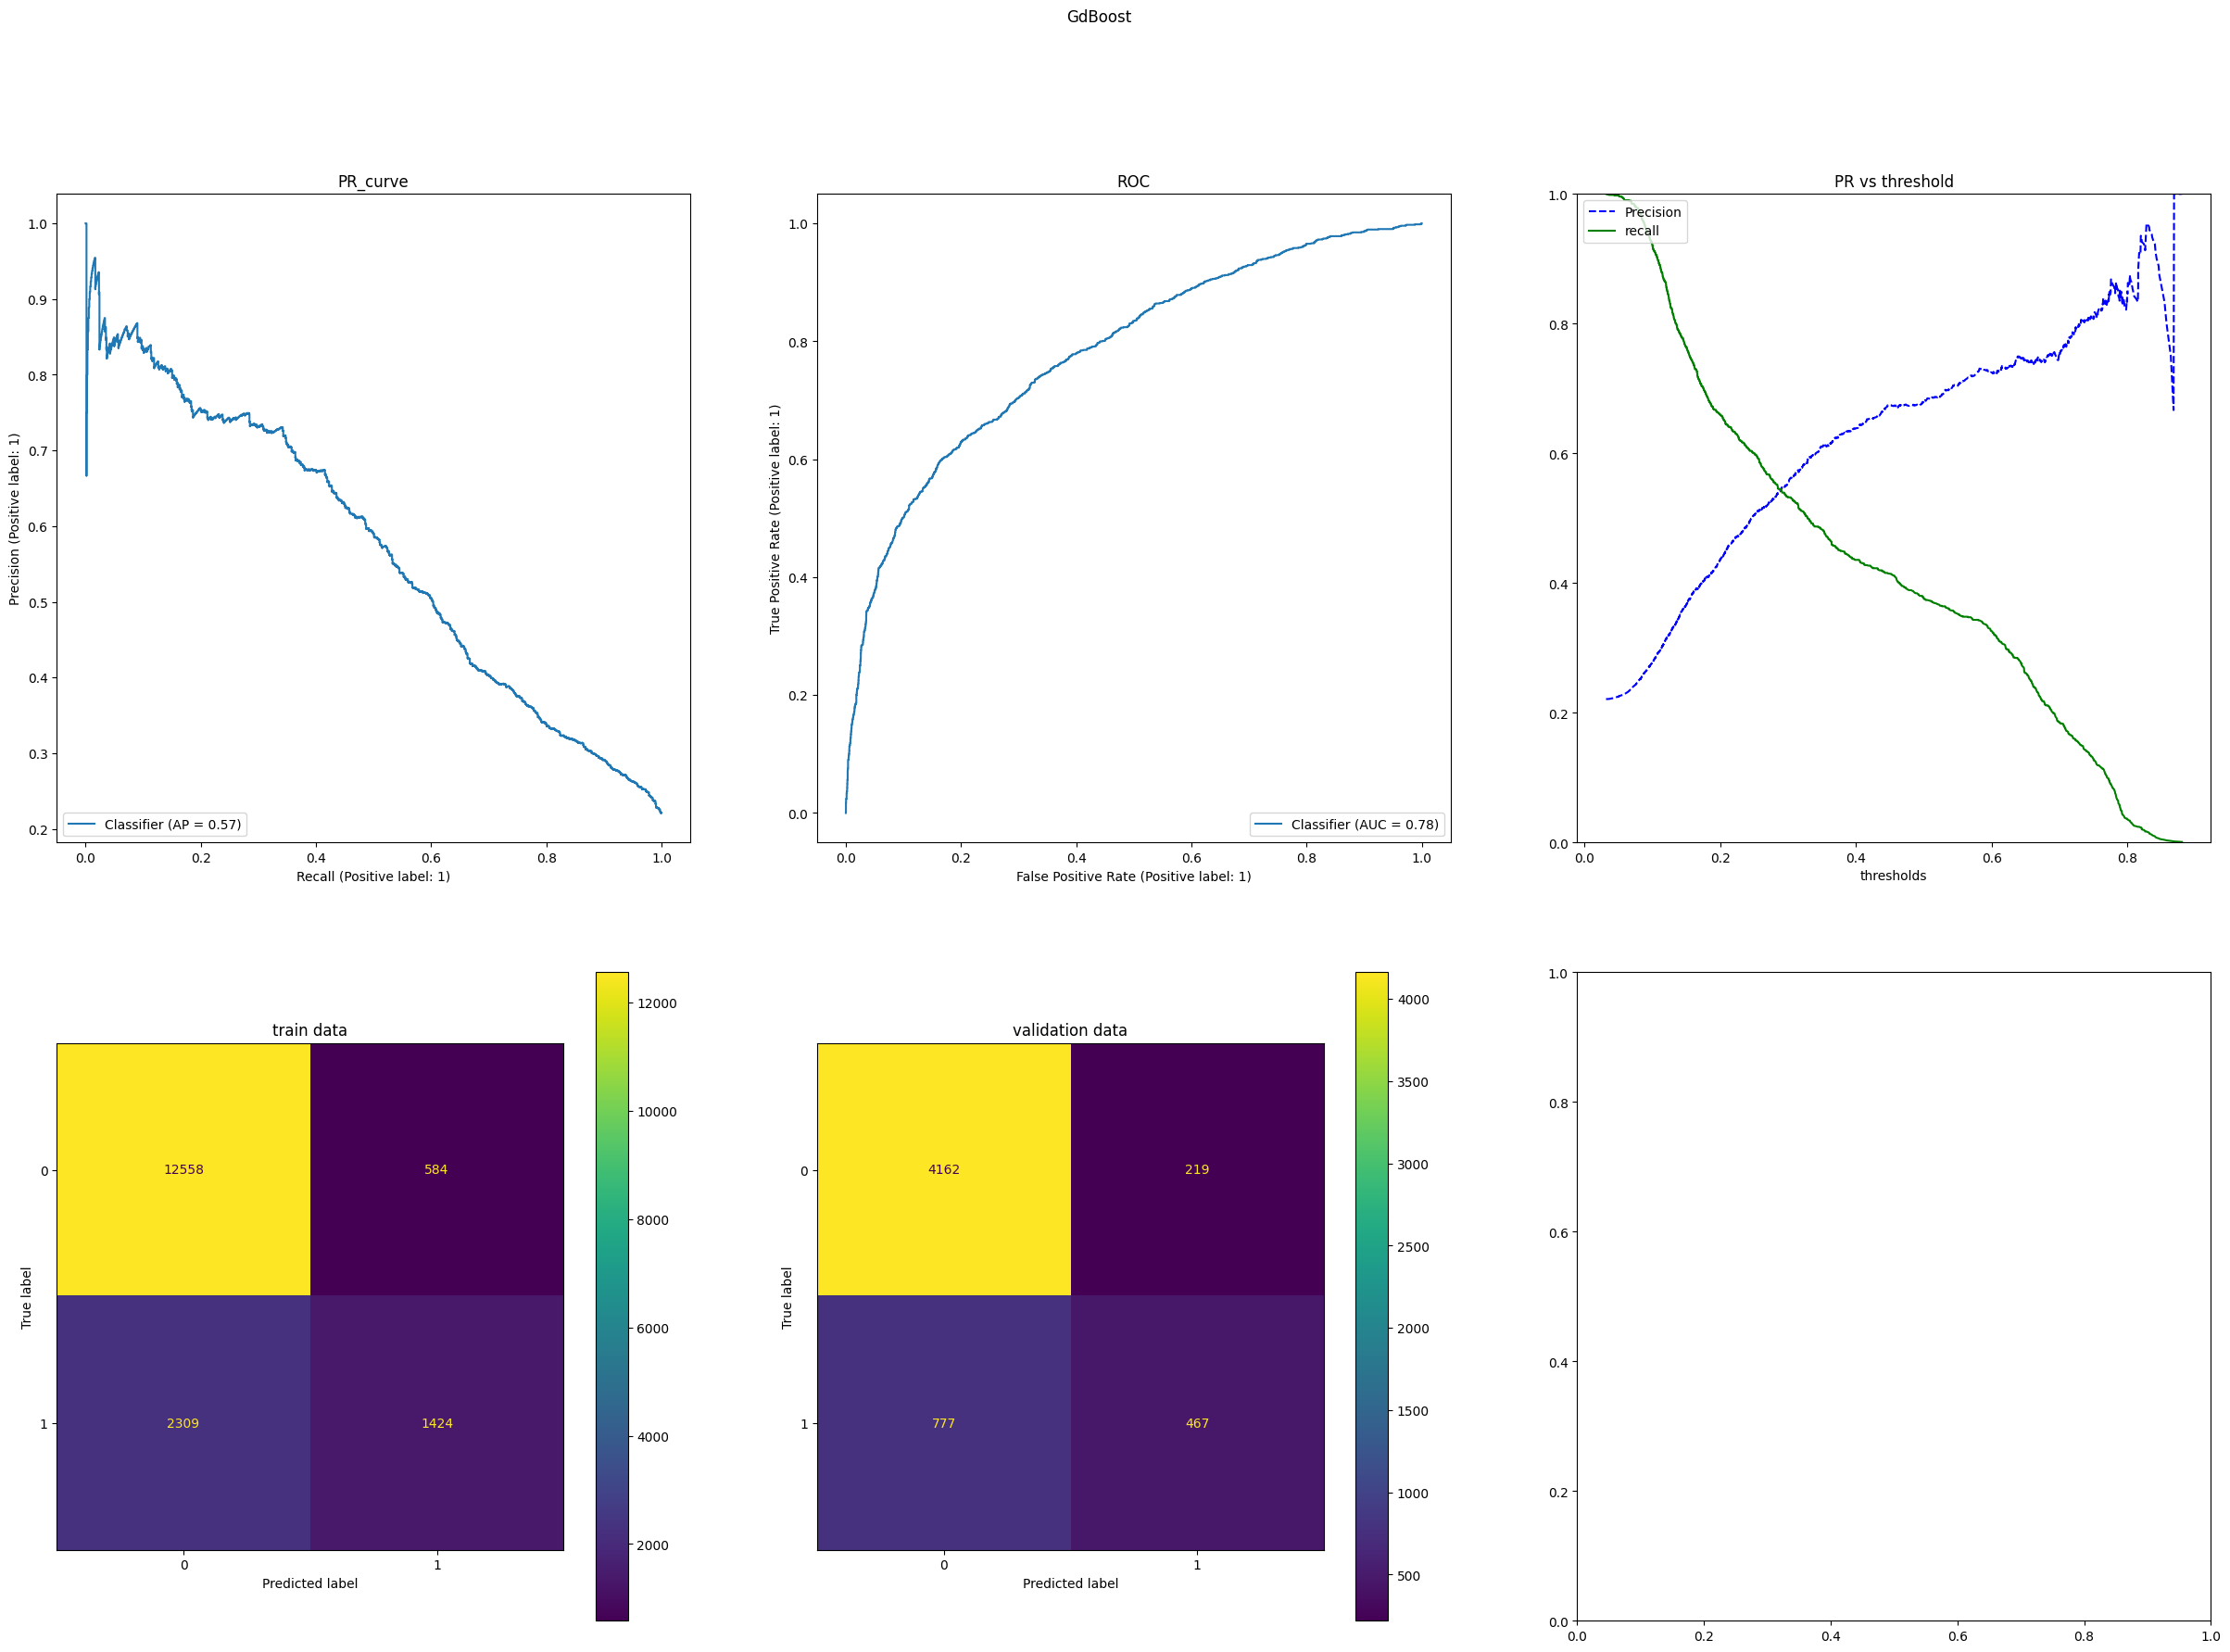

In [ ]:
my_base_transform = BasicTransformer()
clfs = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(n_estimators=200,random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]
clf_names = ['Tree',
            'Forest',
            'Ada',
            'GdBoost'
]

pipe_transform = Pipeline([('base',my_base_transform),
                 #('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

#Computation
results = []
for clf in clfs:
    pipe = Pipeline([('transform',pipe_transform),
                    ('clf',clf)])
    pipe.fit(X_train,y_train)
    train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)
    score_val = pipe.predict_proba(X_val)[:,1]
    results.append({'train':train_pred,'val':val_pred,'score':score_val})

#evaluation
for clf_name,result in zip(clf_names , results):
    print(clf_name)
    cf_matrix_t = confusion_matrix(y_train,result['train'])
    cf_matrix_v = confusion_matrix(y_val,result['val'])
    print(cf_matrix_v)
    print('\n'+'train scores')
    my_score(y_train,result['train'])
    print('\n'+'Val scores')
    my_score(y_val,result['val'])
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    RocCurveDisplay.from_predictions(y_val,result['score'],ax=axes[0,1])
    display = PrecisionRecallDisplay.from_predictions(y_val,result['score'],ax=axes[0,0])
    # display.plot(ax=axes[0,0])
    display = ConfusionMatrixDisplay(cf_matrix_t)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
    display = ConfusionMatrixDisplay(cf_matrix_v)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
    axes[0,1].set_title('ROC')
    axes[0,0].set_title('PR_curve')
    axes[1,0].set_title('train data')
    axes[1,1].set_title('validation data')
    precisions , recalls , thresholds = precision_recall_curve(y_val, result['score'])
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
    axes[0,2].set_title('PR vs threshold')
    fig.suptitle(f'{clf_name}')
    plt.show()
    plt.close()

In [ ]:
from sklearn.tree import plot_tree

/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'kurt_{c_name}'] = kurtosis(channel, axis=1)
/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'kurt_{c_name}'] = kurtosis(channel, axis=1)
/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:81: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'kurt_diff_{c_name}'] = kurtosis(np.diff(channel, axis=1), axis=1)
/home/klosterle97/git/MLBasic22/221117_MLBasic/SW/mods_defaults.py:77: RuntimeWar

Tree
[[4090  291]
 [ 758  486]]

train scores
accuracy : 0.8266074074074075
precision : 0.6761239633347883
recall : 0.41494776319314225
f1_score: 0.5142762284196547

Val scores
accuracy : 0.8135111111111111
precision : 0.6254826254826255
recall : 0.39067524115755625
f1_score: 0.48095002474022763


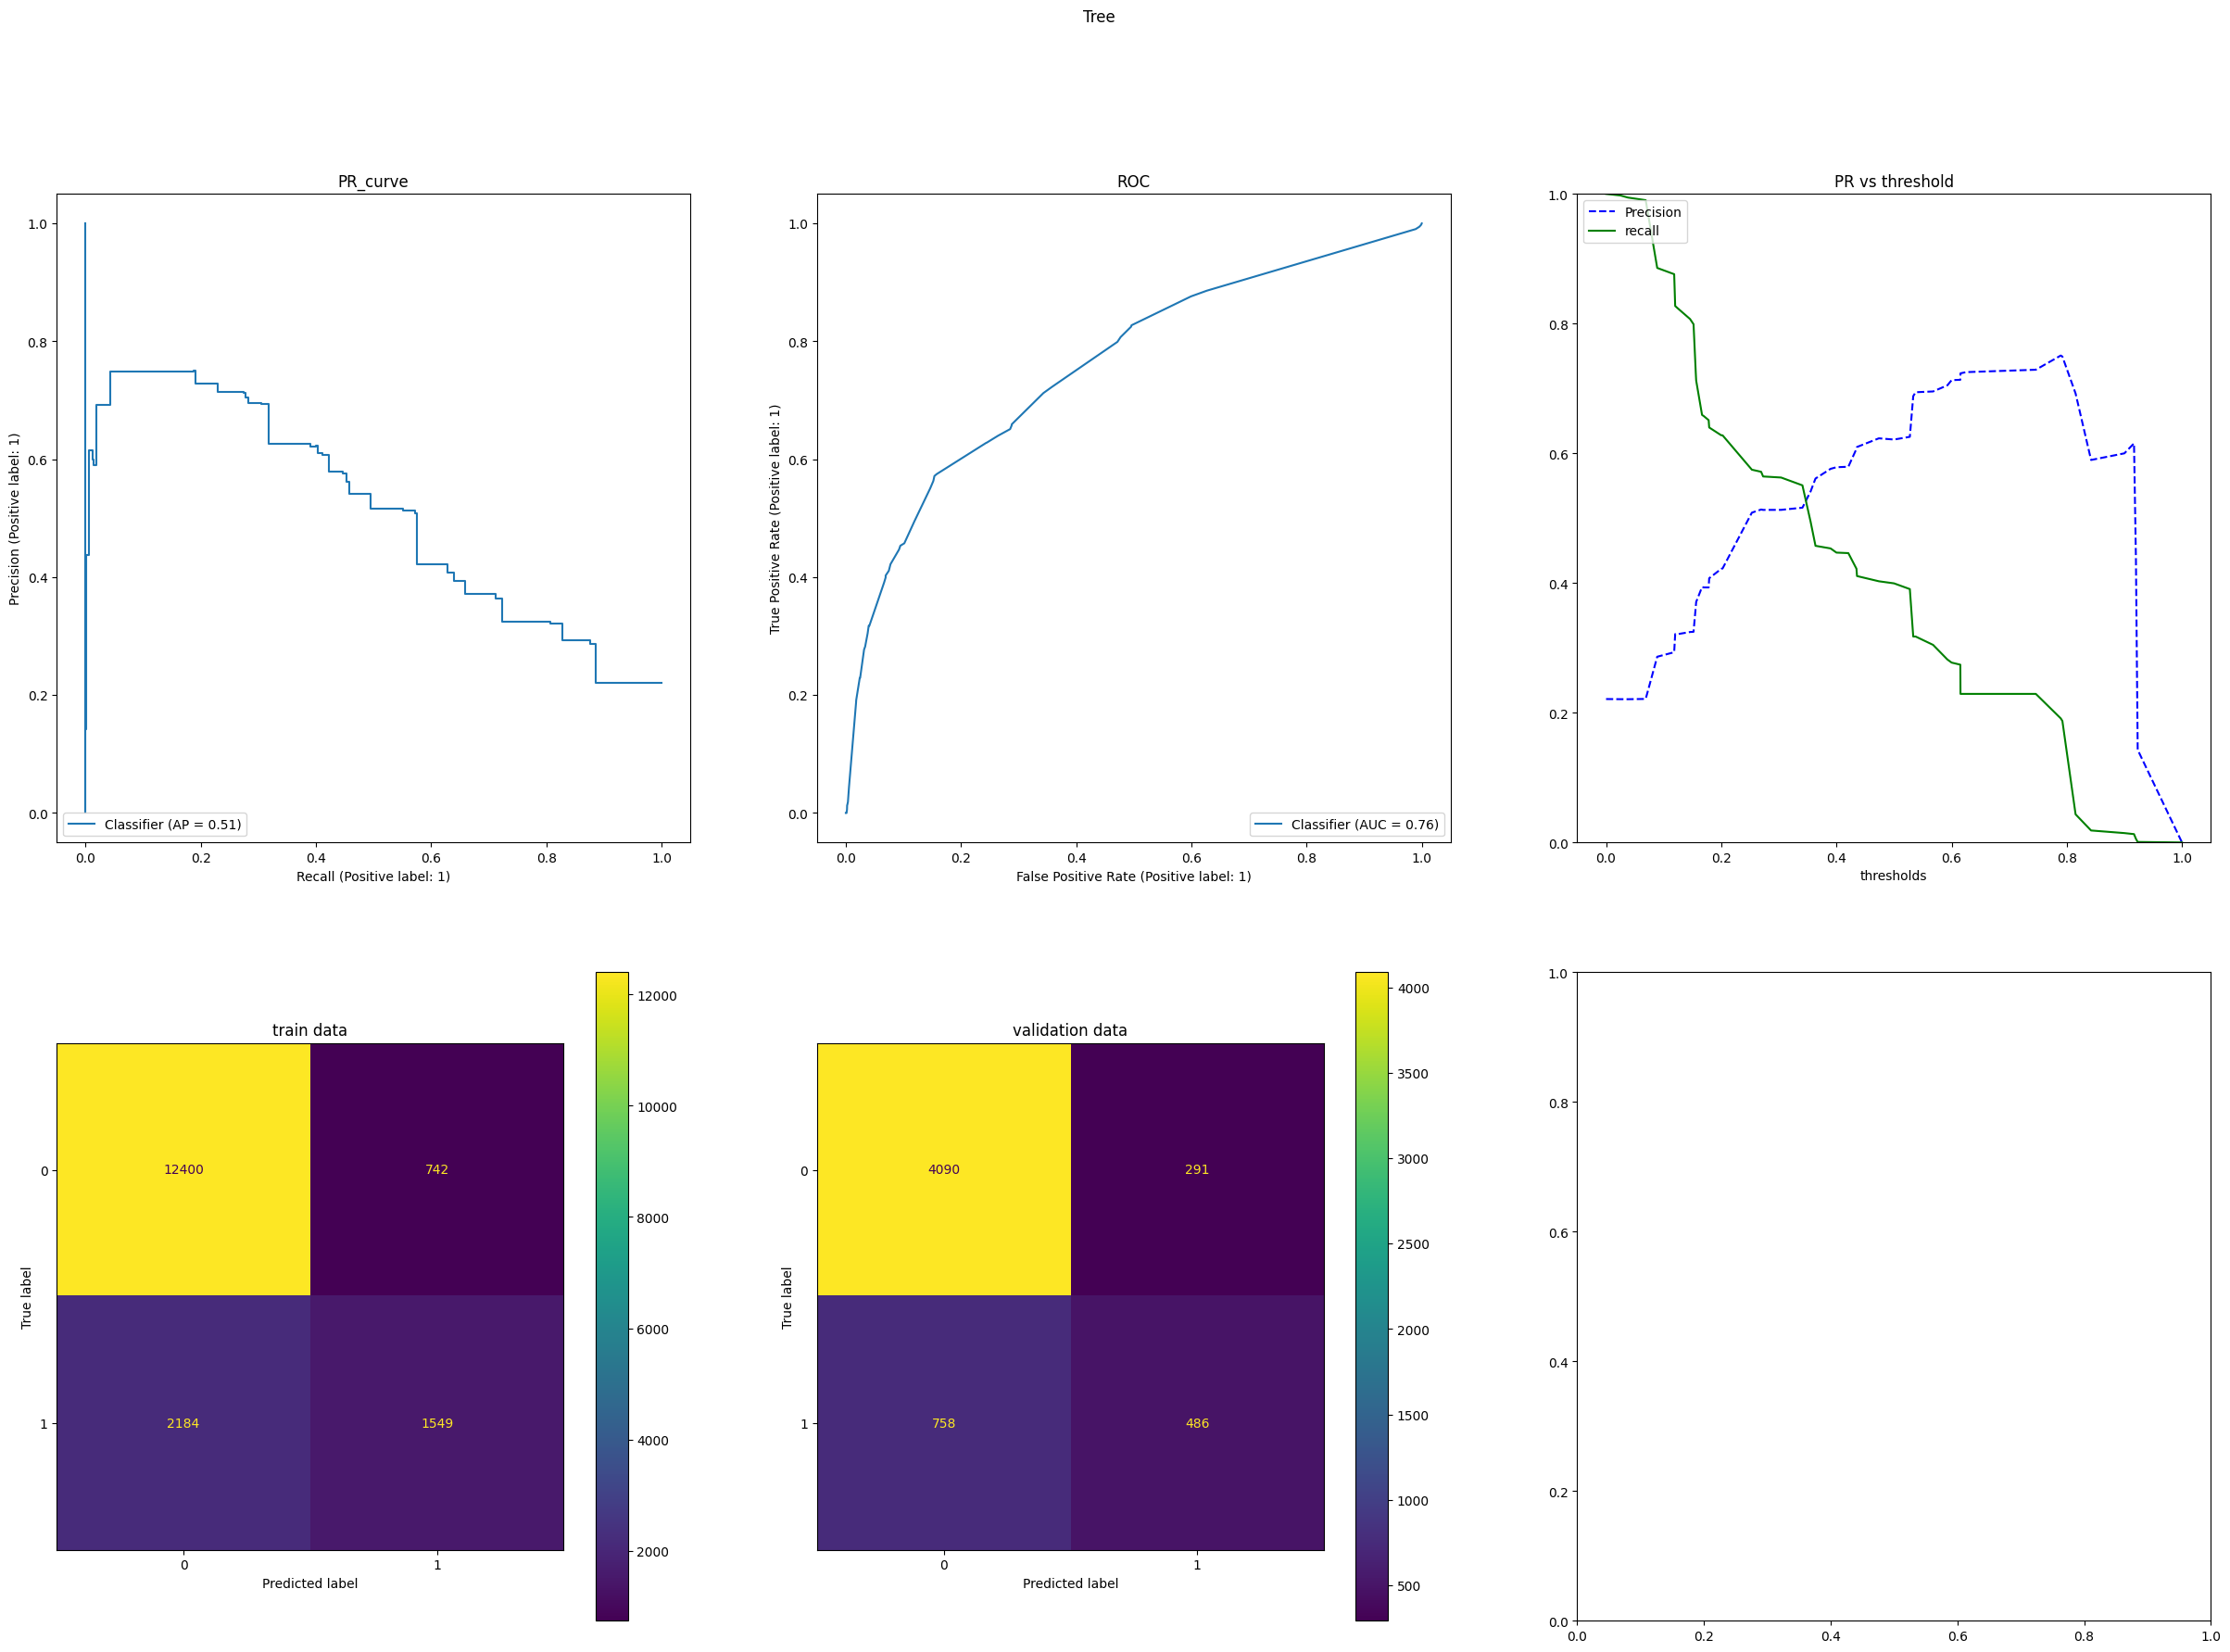

Forest
[[4177  204]
 [ 860  384]]

train scores
accuracy : 0.8215703703703704
precision : 0.7081891580161477
recall : 0.32895794267345296
f1_score: 0.4492408999451252

Val scores
accuracy : 0.8108444444444445
precision : 0.6530612244897959
recall : 0.3086816720257235
f1_score: 0.4192139737991266


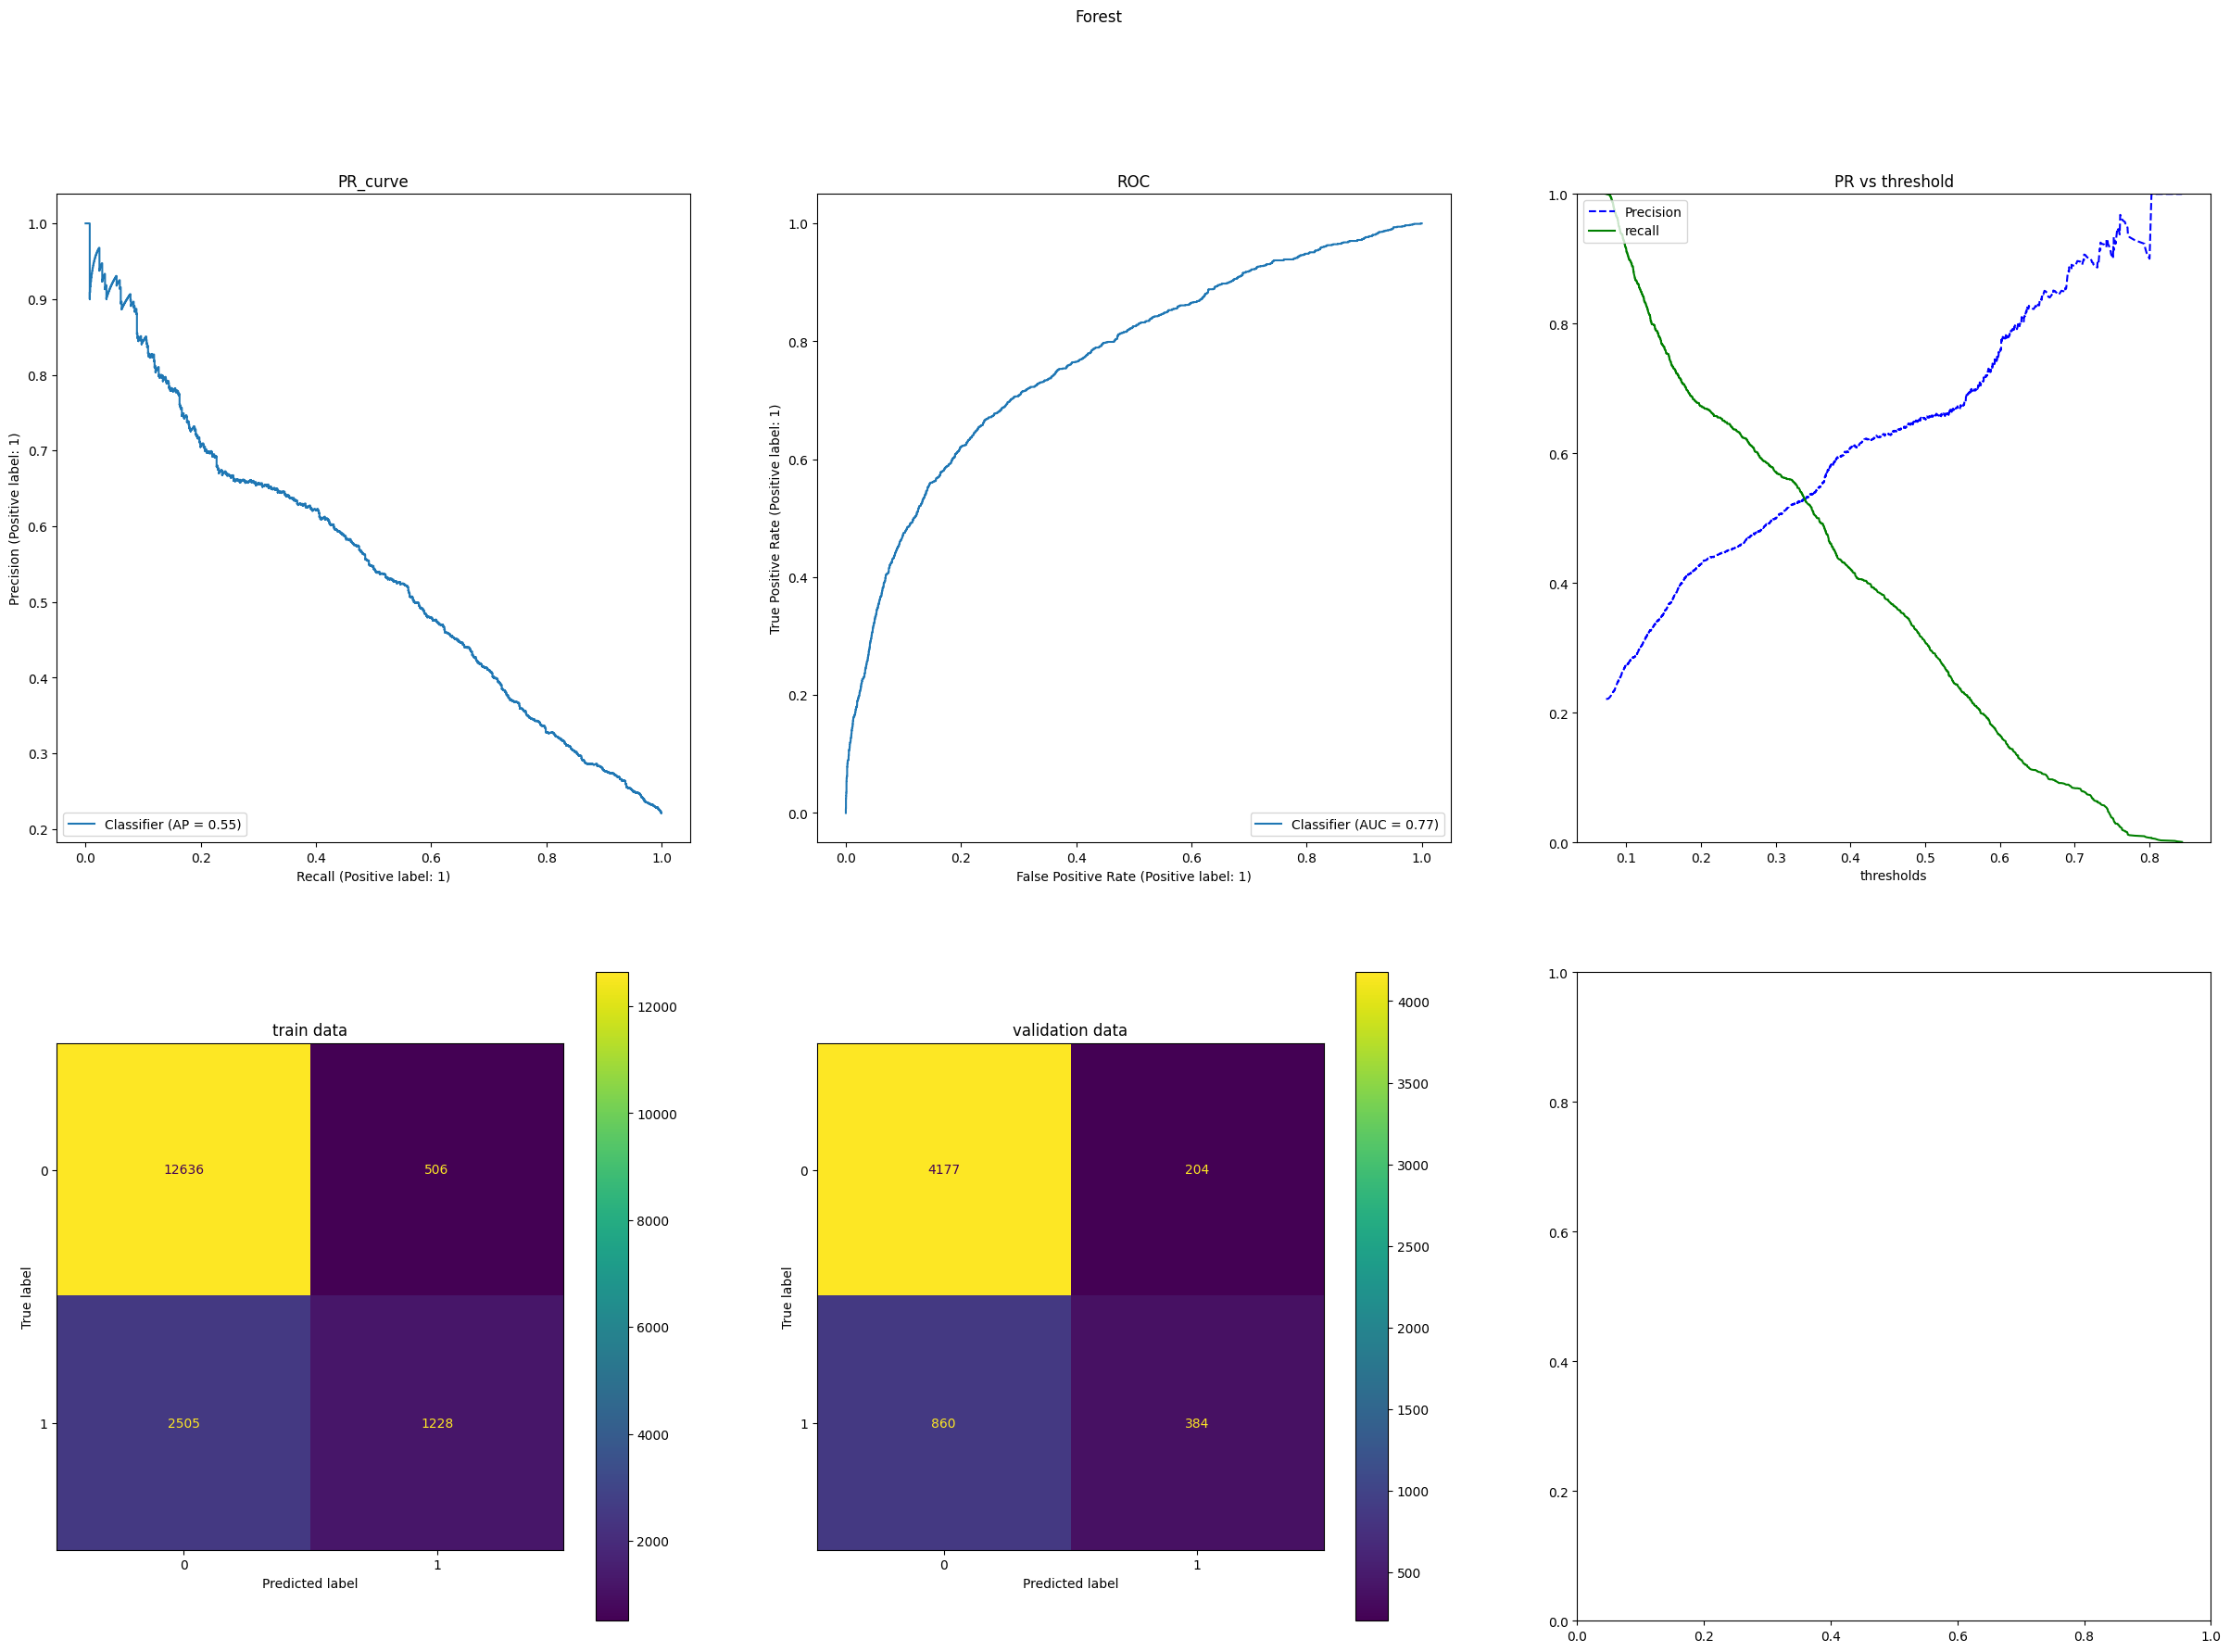

Ada
[[4172  209]
 [ 865  379]]

train scores
accuracy : 0.8094814814814815
precision : 0.6519953051643192
recall : 0.2976158585587999
f1_score: 0.40868125804671696

Val scores
accuracy : 0.8090666666666667
precision : 0.6445578231292517
recall : 0.3046623794212219
f1_score: 0.41375545851528384


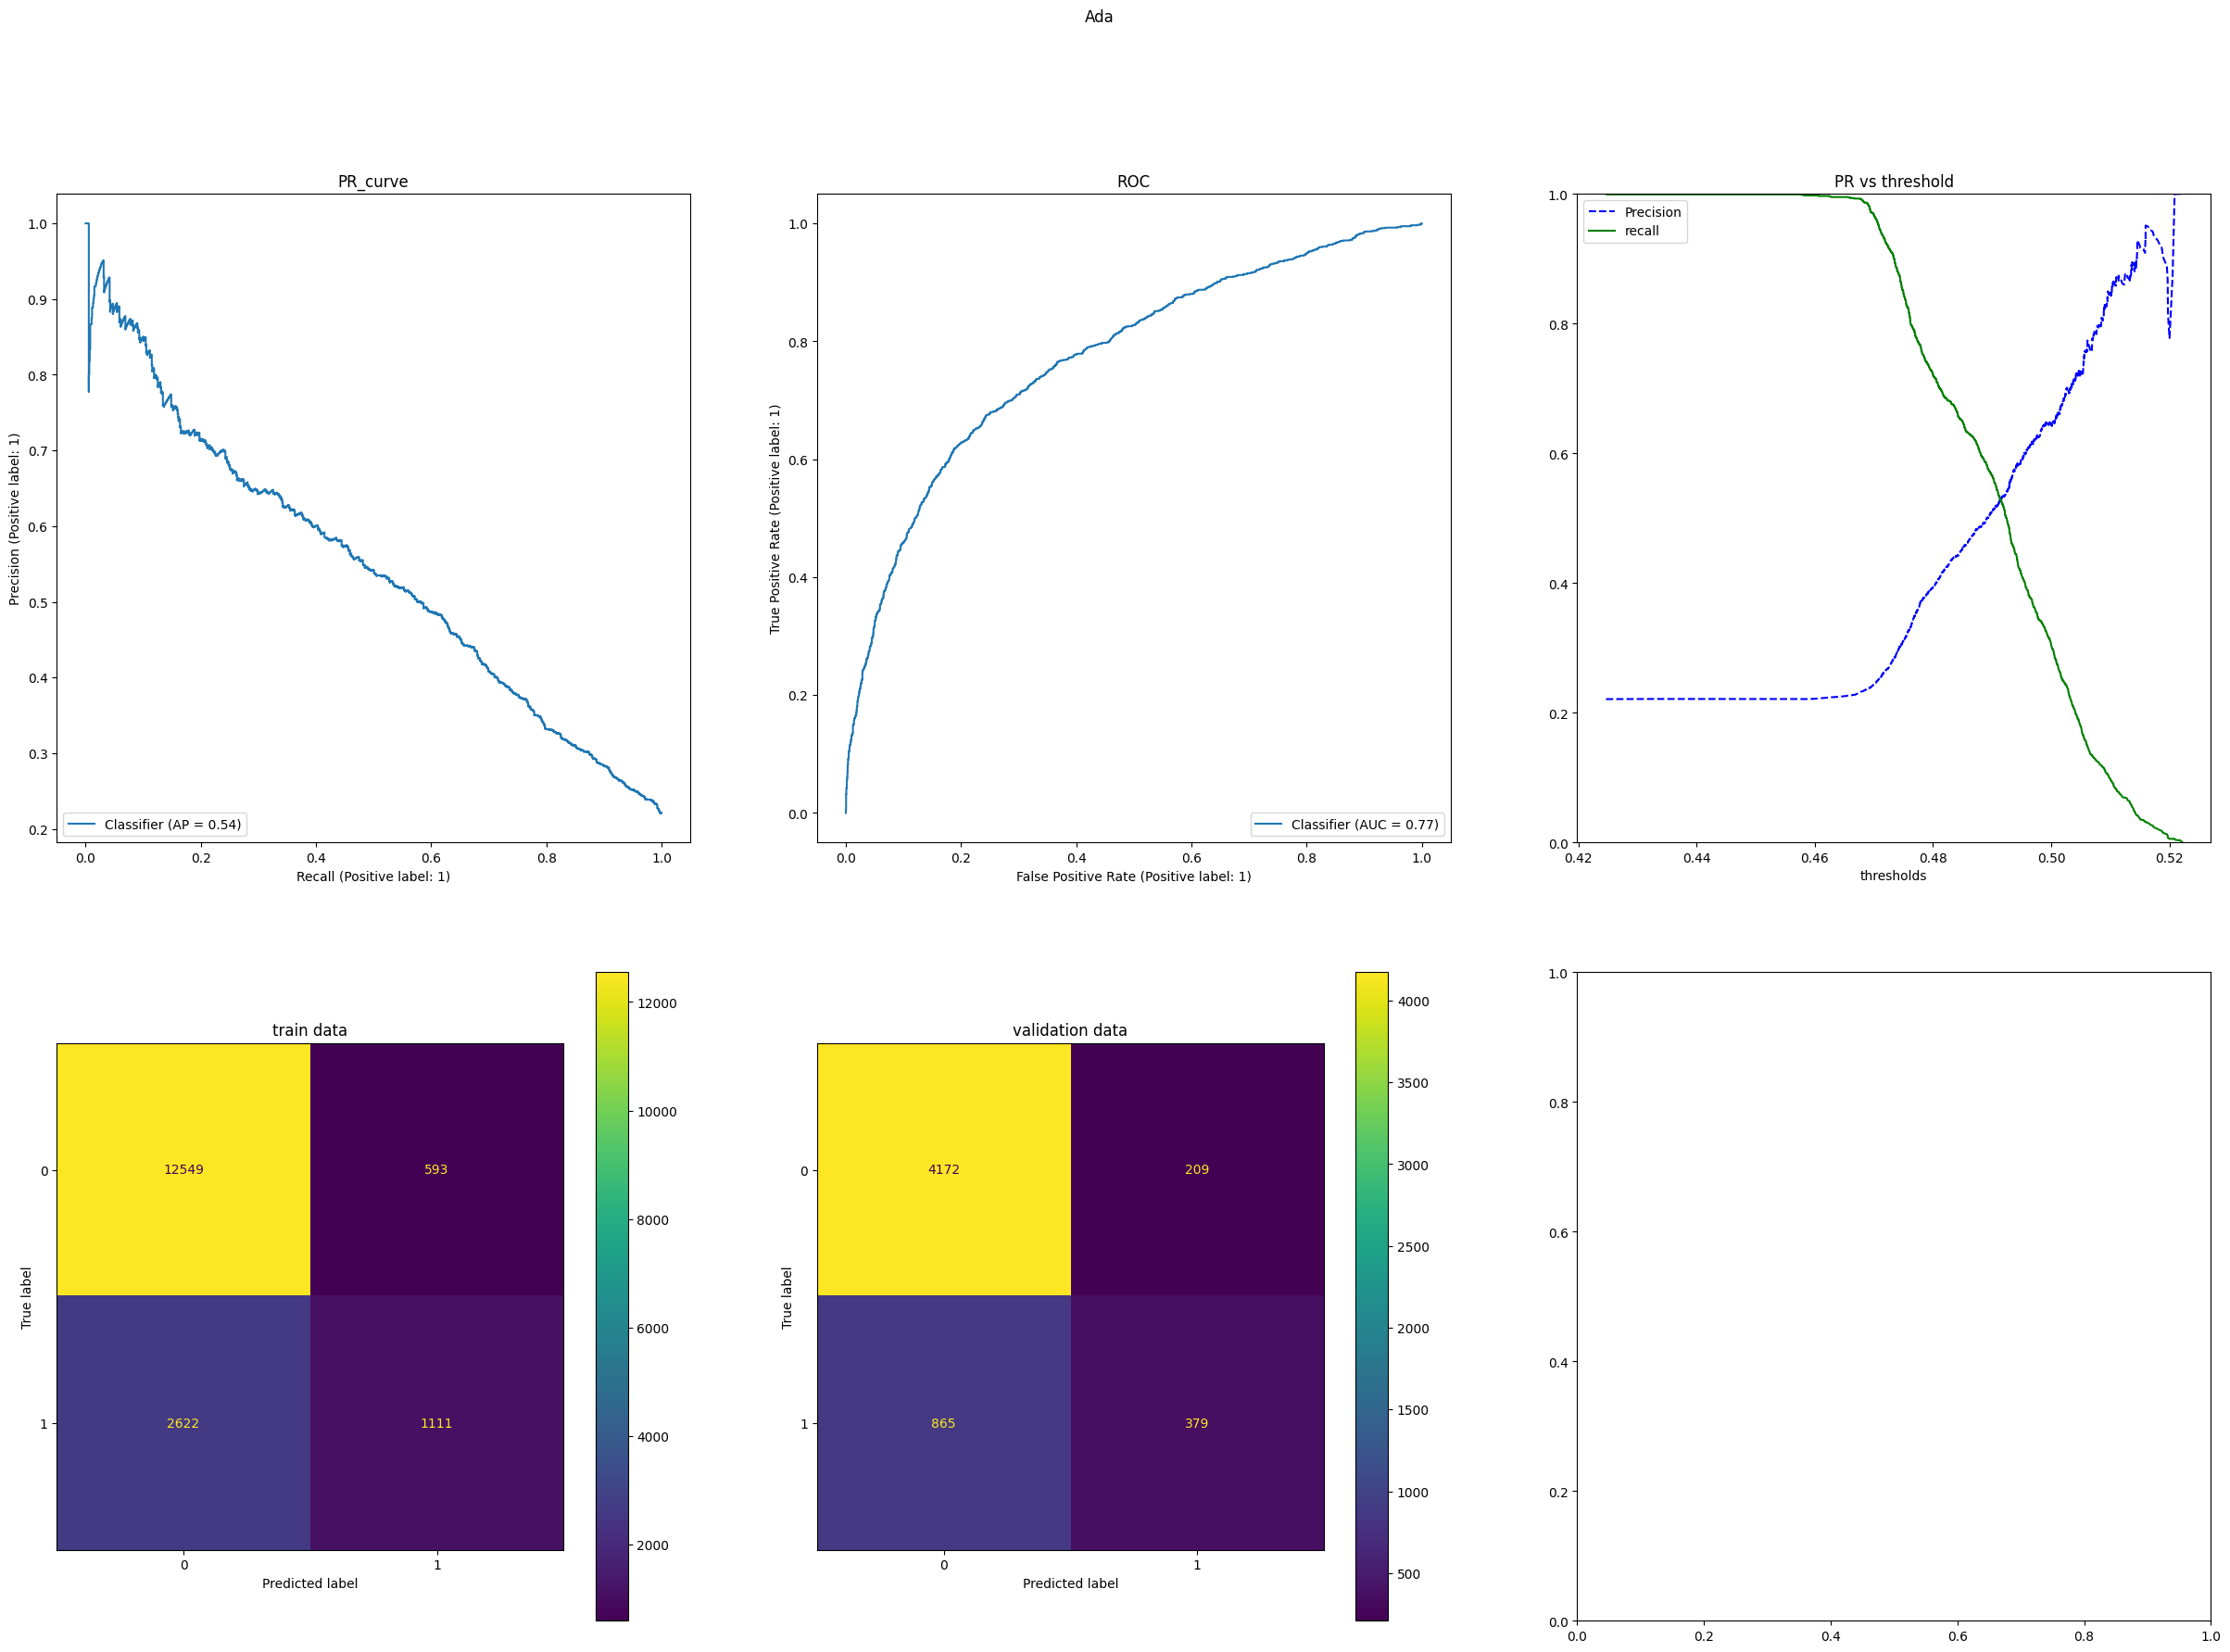

GdBoost
[[4220  161]
 [ 938  306]]

train scores
accuracy : 0.8088888888888889
precision : 0.6881481481481482
recall : 0.24886150549156175
f1_score: 0.365532166043675

Val scores
accuracy : 0.8046222222222222
precision : 0.6552462526766595
recall : 0.2459807073954984
f1_score: 0.35768556399766216


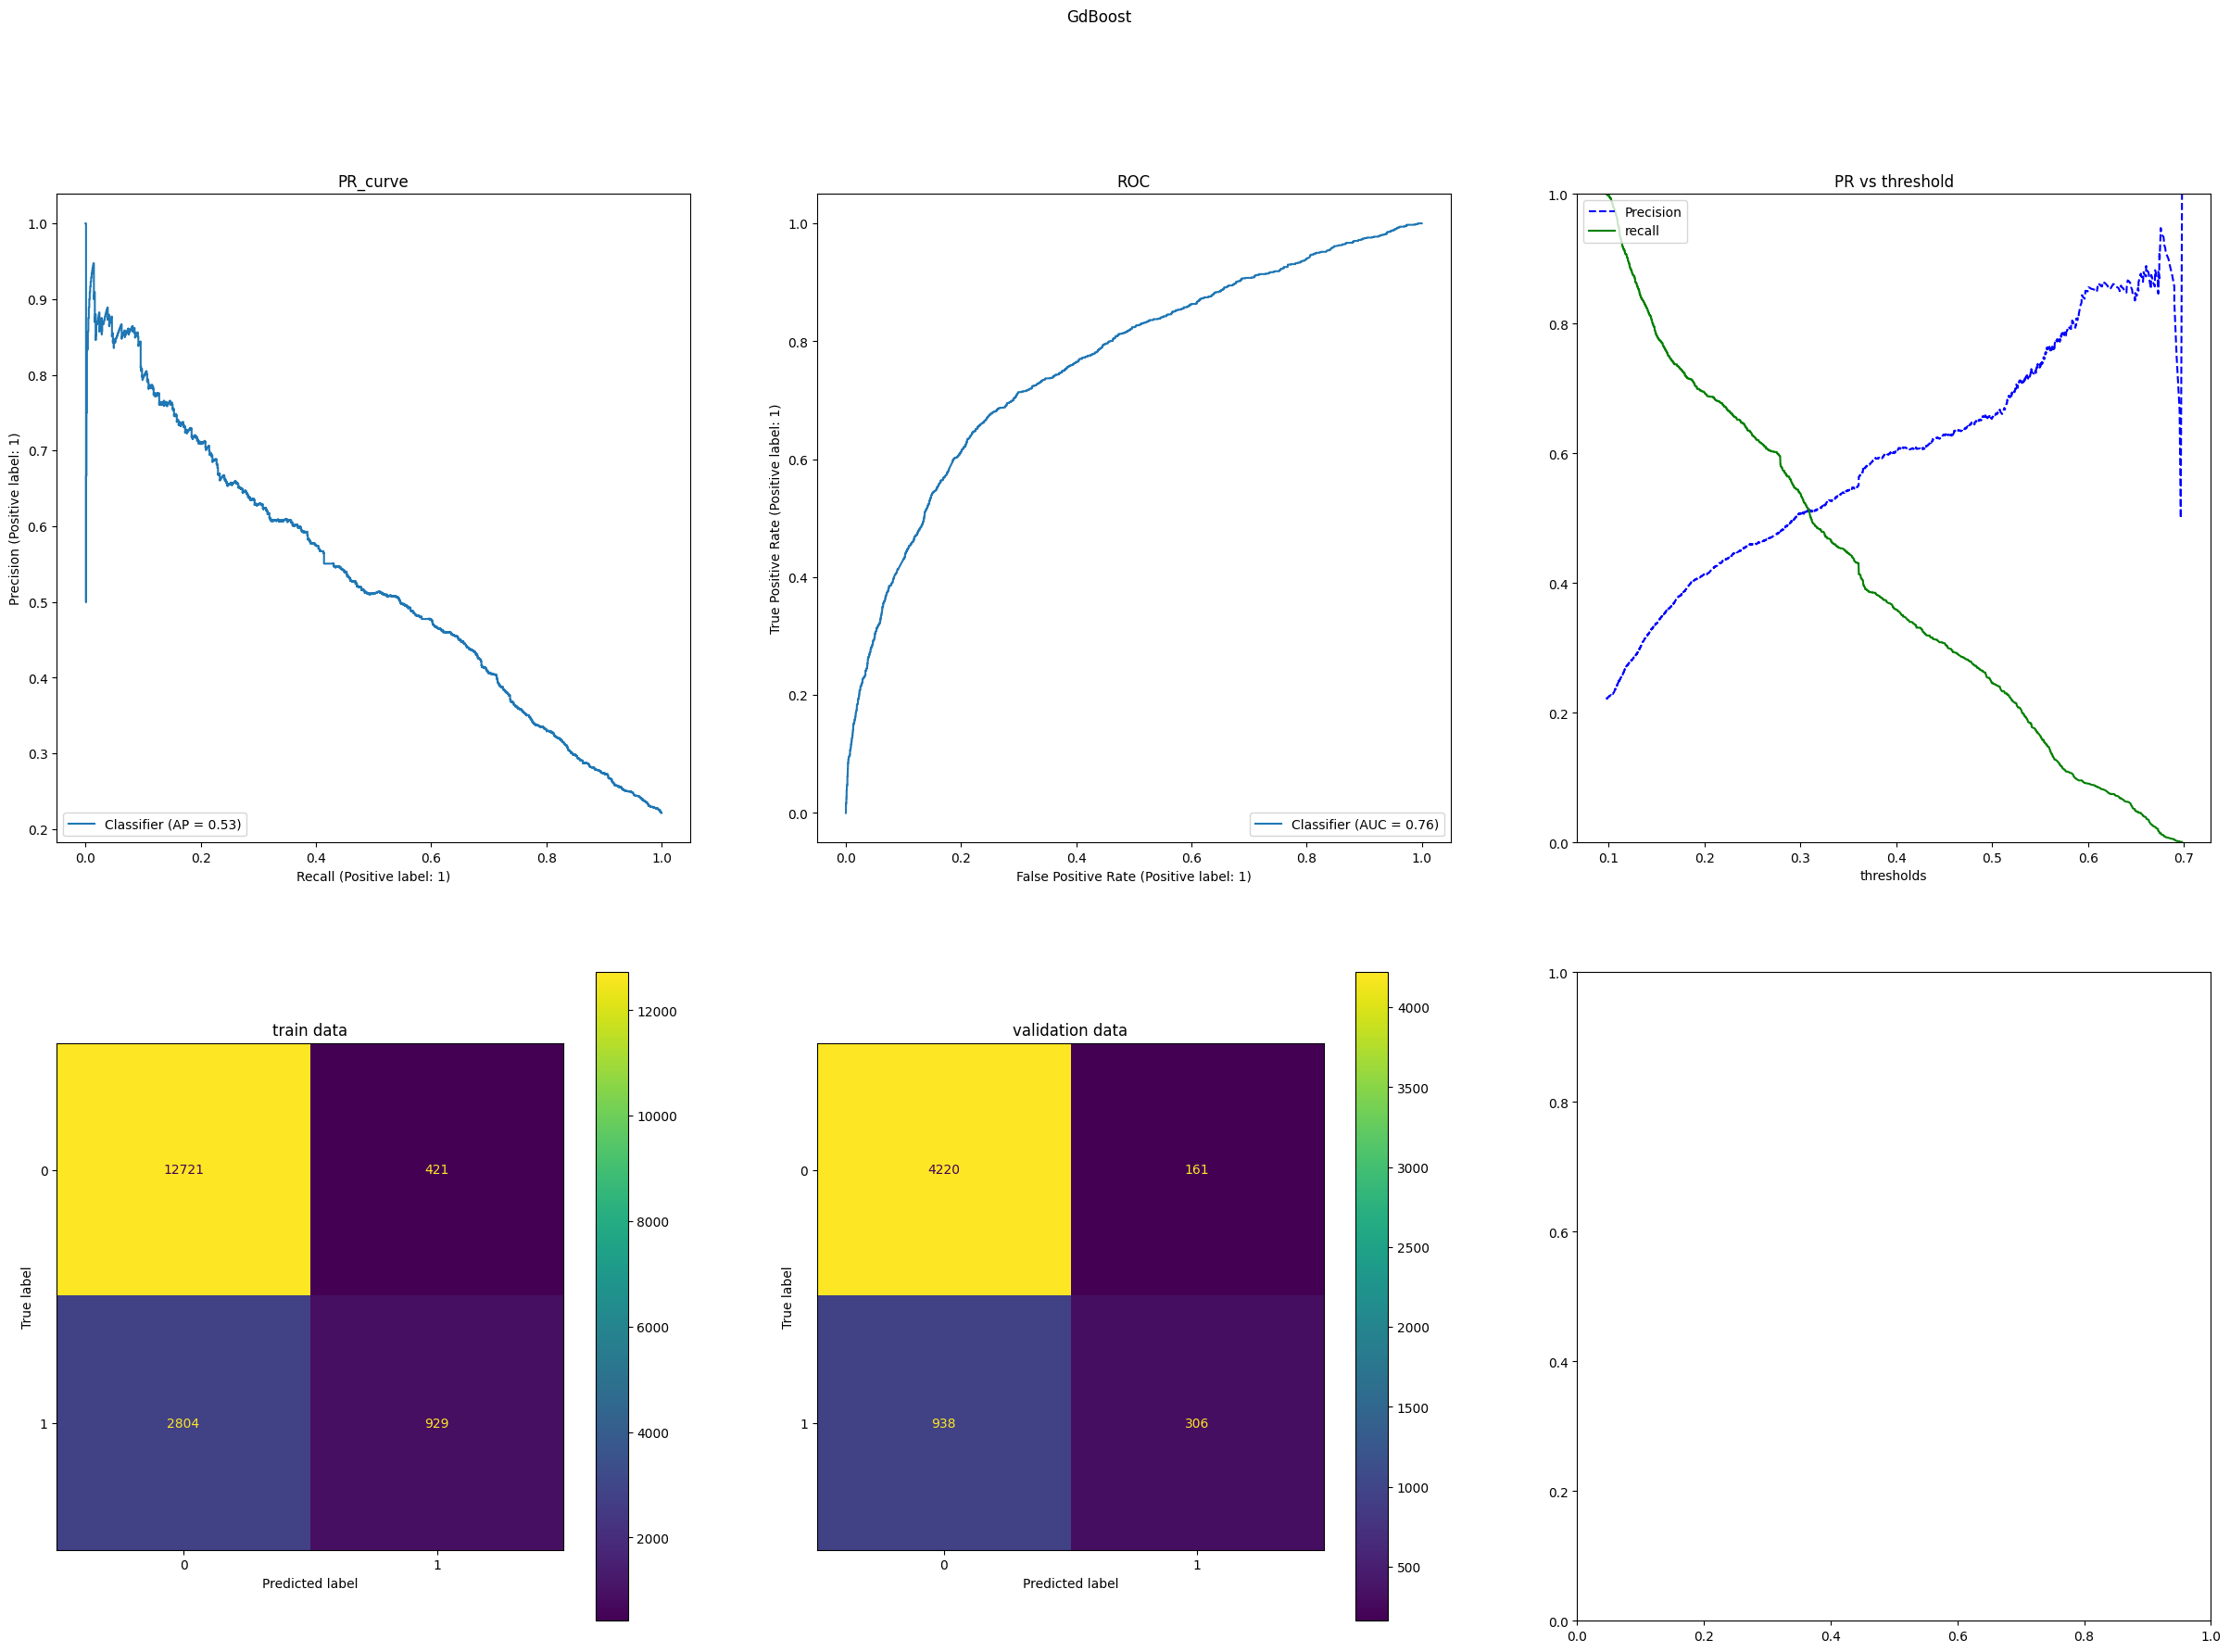

In [36]:
my_base_transform = BasicTransformer()
clfs = [
    DecisionTreeClassifier(max_depth=6,
                            random_state=42),
    RandomForestClassifier(n_estimators=200,
                            max_depth=6,
                            n_jobs=-1,
                            random_state=42),
    AdaBoostClassifier(n_estimators=200,
                        learning_rate=0.1,
                        random_state=42),
    GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.01,
                                max_depth =2,
                                max_features='sqrt',
                                random_state=42)
]


clf_names = ['Tree',
            'Forest',
            'Ada',
            'GdBoost'
]

pipe_transform = Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

#Computation
results = []
for clf in clfs:
    pipe = Pipeline([('transform',pipe_transform),
                    ('clf',clf)])
    pipe.fit(X_train,y_train)
    train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)
    score_val = pipe.predict_proba(X_val)[:,1]
    results.append({'train':train_pred,'val':val_pred,'score':score_val})

#evaluation
for clf_name,result in zip(clf_names , results):
    print(clf_name)
    cf_matrix_t = confusion_matrix(y_train,result['train'])
    cf_matrix_v = confusion_matrix(y_val,result['val'])
    print(cf_matrix_v)
    print('\n'+'train scores')
    my_score(y_train,result['train'])
    print('\n'+'Val scores')
    my_score(y_val,result['val'])
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    RocCurveDisplay.from_predictions(y_val,result['score'],ax=axes[0,1])
    display = PrecisionRecallDisplay.from_predictions(y_val,result['score'],ax=axes[0,0])
    # display.plot(ax=axes[0,0])
    display = ConfusionMatrixDisplay(cf_matrix_t)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
    display = ConfusionMatrixDisplay(cf_matrix_v)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
    axes[0,1].set_title('ROC')
    axes[0,0].set_title('PR_curve')
    axes[1,0].set_title('train data')
    axes[1,1].set_title('validation data')
    precisions , recalls , thresholds = precision_recall_curve(y_val, result['score'])
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
    axes[0,2].set_title('PR vs threshold')
    fig.suptitle(f'{clf_name}')
    plt.show()
    plt.close()

Tree
[[4160  221]
 [ 781  463]]

train scores
accuracy : 0.8289777777777778
precision : 0.7120681021532298
recall : 0.38092686847039914
f1_score: 0.4963350785340313

Val scores
accuracy : 0.8218666666666666
precision : 0.6769005847953217
recall : 0.3721864951768489
f1_score: 0.4802904564315353


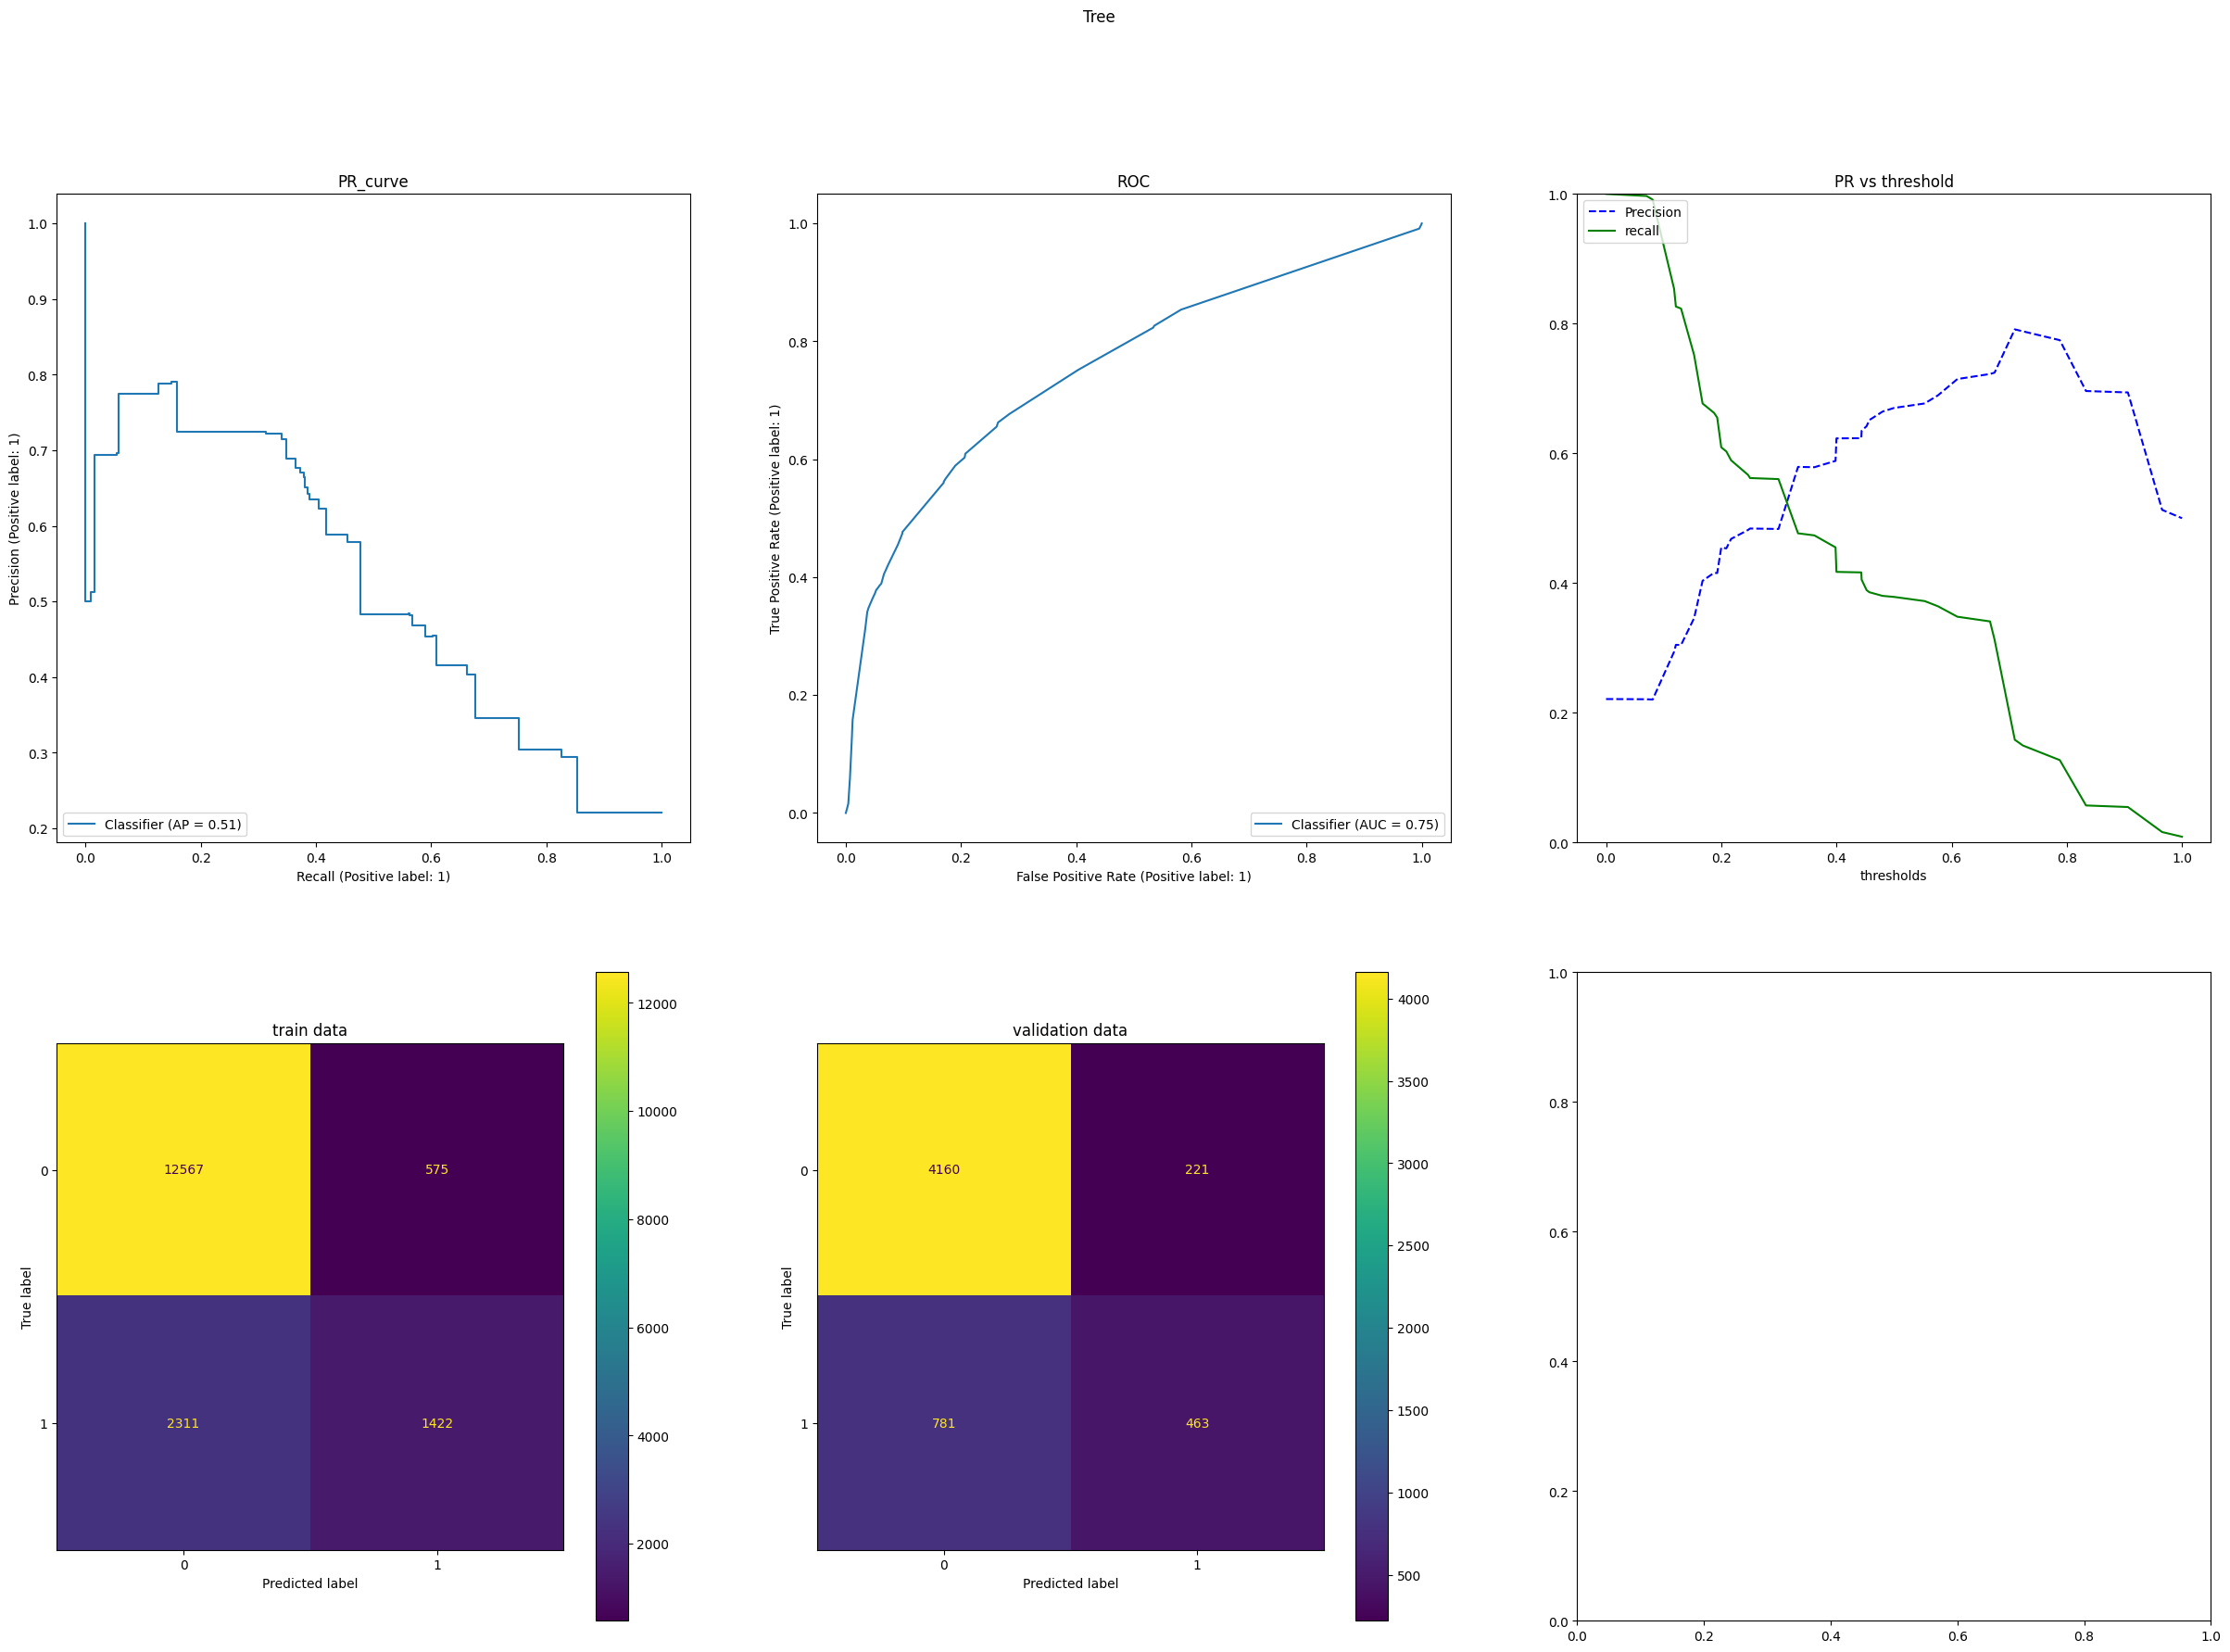

Forest
[[4205  176]
 [ 857  387]]

train scores
accuracy : 0.8250074074074074
precision : 0.7401477832512315
recall : 0.32199303509241894
f1_score: 0.44875863356356166

Val scores
accuracy : 0.8163555555555555
precision : 0.6873889875666075
recall : 0.31109324758842444
f1_score: 0.42833425567238514


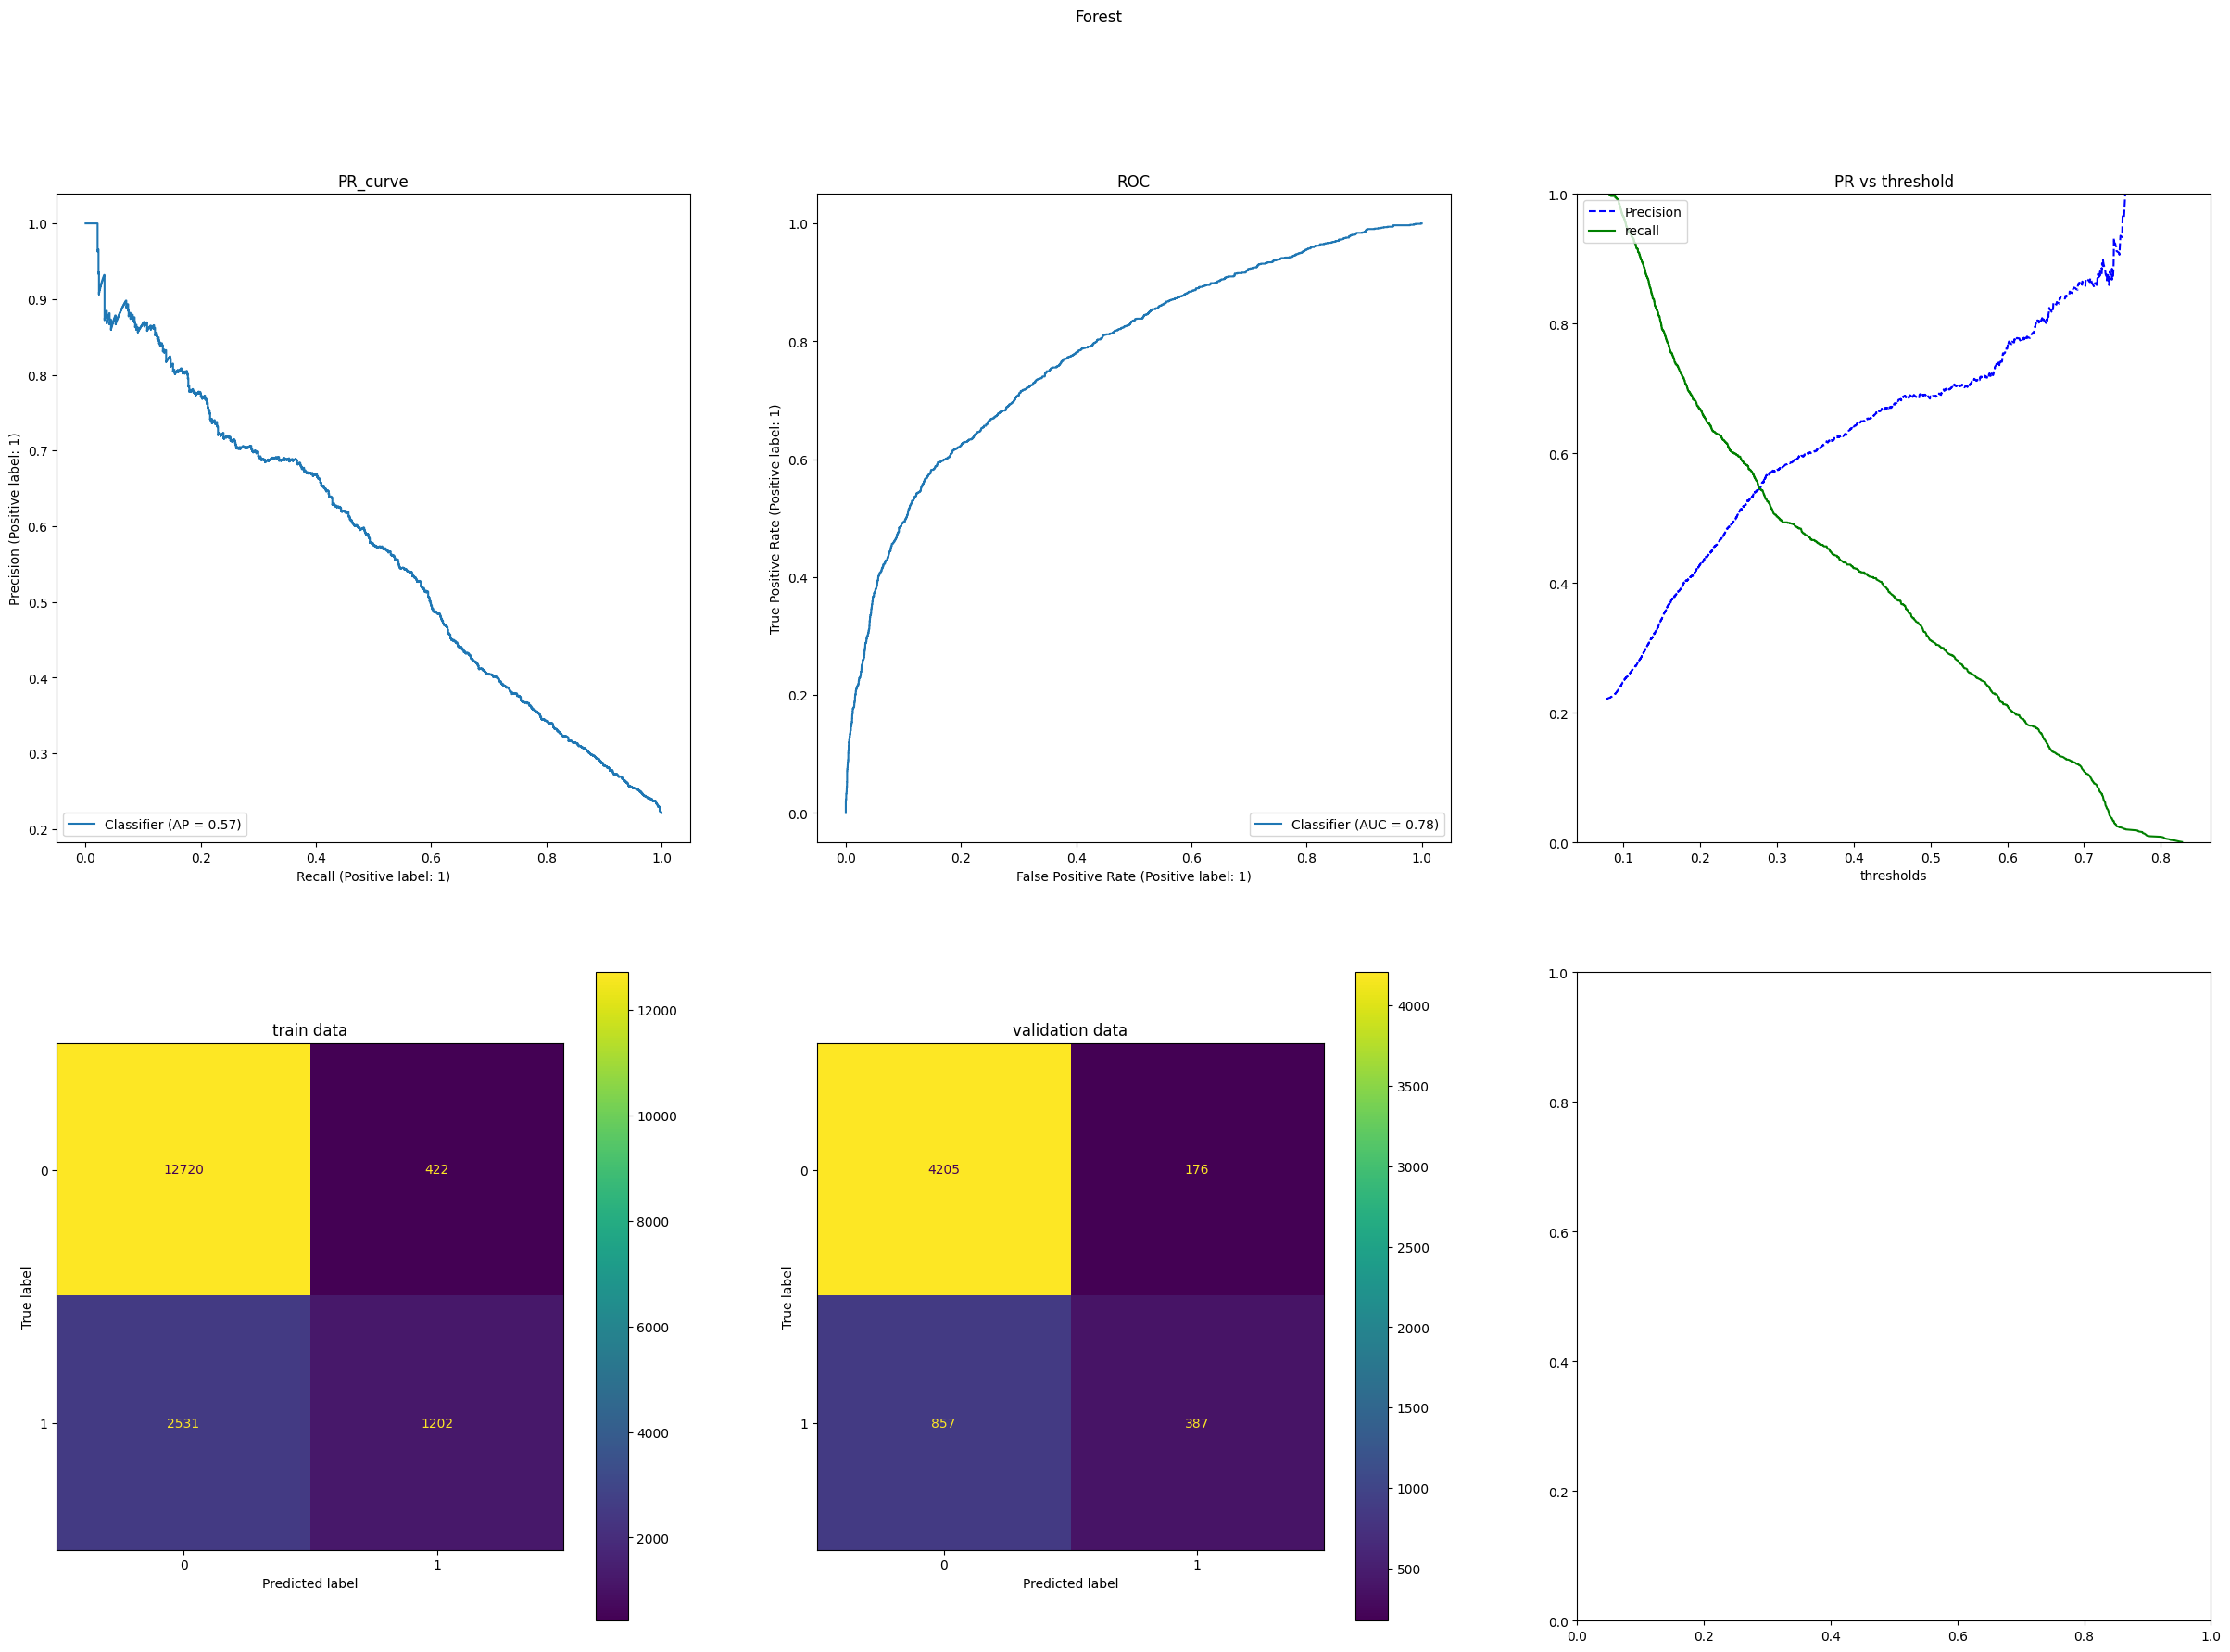

Ada
[[4203  178]
 [ 821  423]]

train scores
accuracy : 0.8181333333333334
precision : 0.688422247446084
recall : 0.324939726761318
f1_score: 0.44149226569608735

Val scores
accuracy : 0.8224
precision : 0.7038269550748752
recall : 0.340032154340836
f1_score: 0.4585365853658537


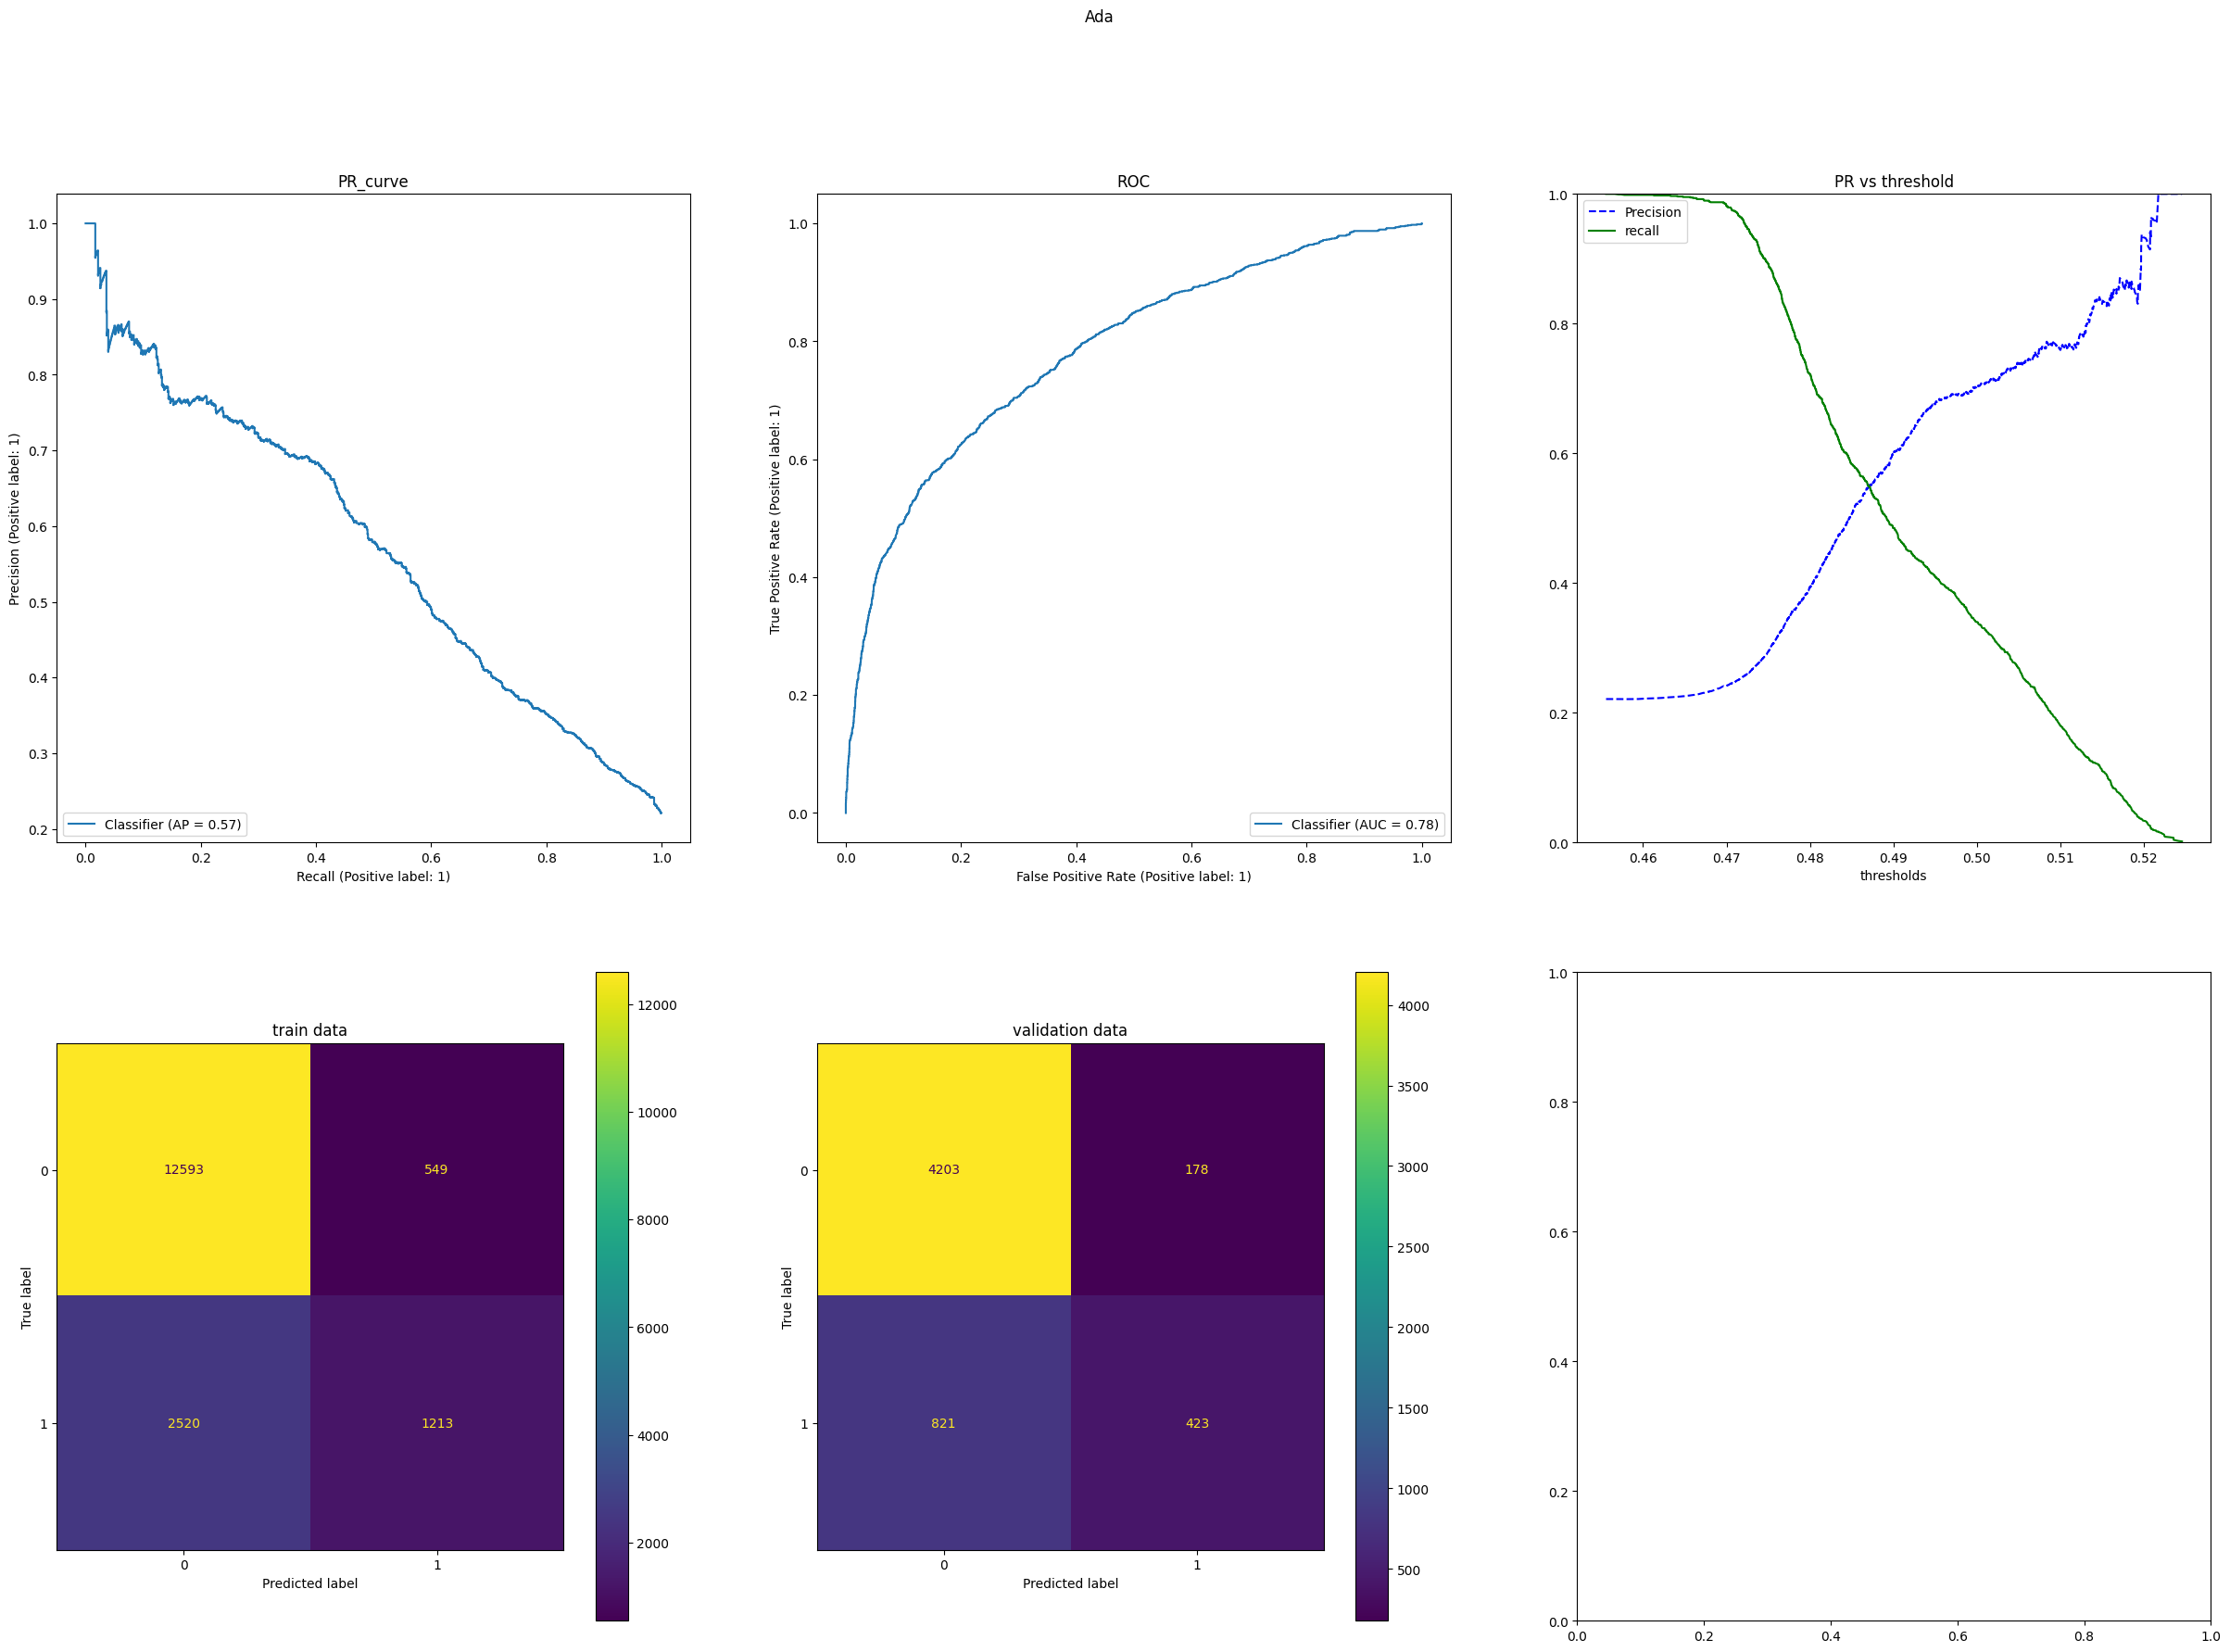

GdBoost
[[4233  148]
 [ 904  340]]

train scores
accuracy : 0.8137481481481481
precision : 0.7113180515759312
recall : 0.2660058933833378
f1_score: 0.3872099824527198

Val scores
accuracy : 0.8129777777777778
precision : 0.6967213114754098
recall : 0.2733118971061093
f1_score: 0.3926096997690531


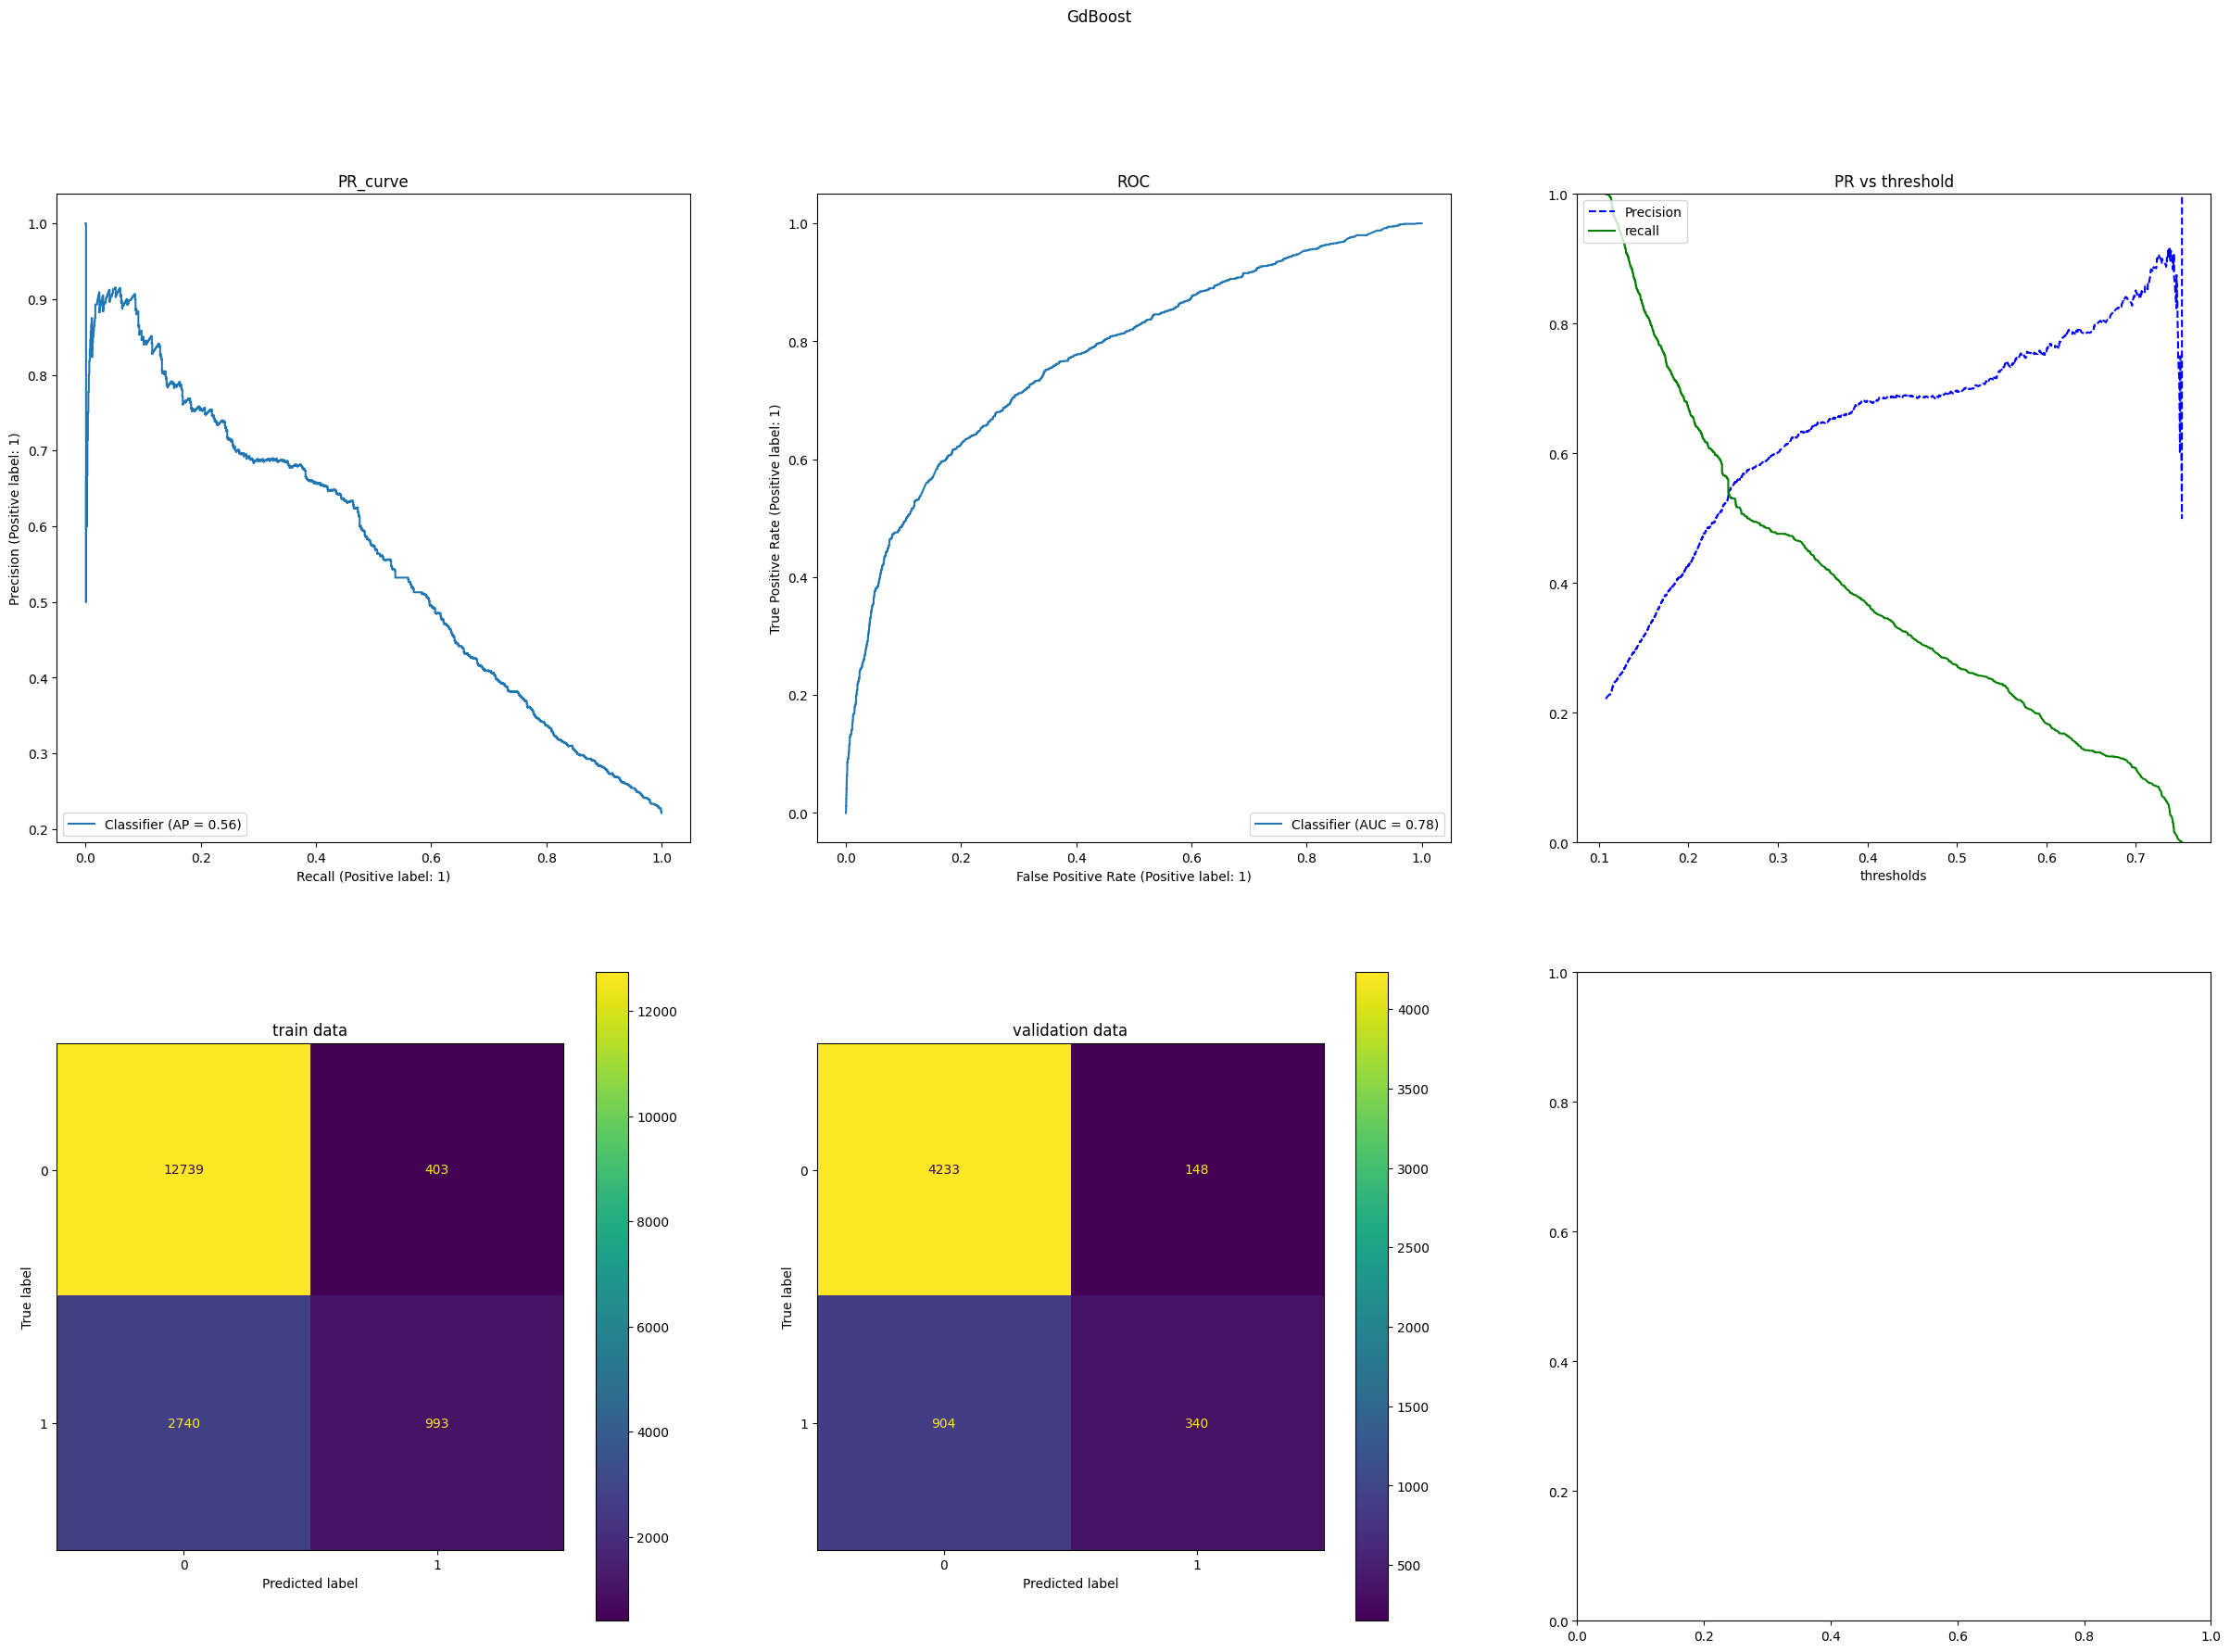

In [37]:
my_base_transform = BasicTransformer()
clfs = [
    DecisionTreeClassifier(max_depth=6,
                            random_state=42),
    RandomForestClassifier(n_estimators=200,
                            max_depth=6,
                            n_jobs=-1,
                            random_state=42),
    AdaBoostClassifier(n_estimators=200,
                        learning_rate=0.1,
                        random_state=42),
    GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.01,
                                max_depth =2,
                                max_features='sqrt',
                                random_state=42)
]


clf_names = ['Tree',
            'Forest',
            'Ada',
            'GdBoost'
]

pipe_transform = Pipeline([('base',my_base_transform),
                 #('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

#Computation
results = []
for clf in clfs:
    pipe = Pipeline([('transform',pipe_transform),
                    ('clf',clf)])
    pipe.fit(X_train,y_train)
    train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)
    score_val = pipe.predict_proba(X_val)[:,1]
    results.append({'train':train_pred,'val':val_pred,'score':score_val})

#evaluation
for clf_name,result in zip(clf_names , results):
    print(clf_name)
    cf_matrix_t = confusion_matrix(y_train,result['train'])
    cf_matrix_v = confusion_matrix(y_val,result['val'])
    print(cf_matrix_v)
    print('\n'+'train scores')
    my_score(y_train,result['train'])
    print('\n'+'Val scores')
    my_score(y_val,result['val'])
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    RocCurveDisplay.from_predictions(y_val,result['score'],ax=axes[0,1])
    display = PrecisionRecallDisplay.from_predictions(y_val,result['score'],ax=axes[0,0])
    # display.plot(cmap=plt.cm.Blues,ax=axes[0,0])
    display = ConfusionMatrixDisplay(cf_matrix_t)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
    display = ConfusionMatrixDisplay(cf_matrix_v)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
    axes[0,1].set_title('ROC')
    axes[0,0].set_title('PR_curve')
    axes[1,0].set_title('train data')
    axes[1,1].set_title('validation data')
    precisions , recalls , thresholds = precision_recall_curve(y_val, result['score'])
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
    axes[0,2].set_title('PR vs threshold')
    fig.suptitle(f'{clf_name}')
    plt.show()
    plt.close()

In [39]:
BasicTransformer.columns = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT_1', 'BILL_AMT_2',
       'BILL_AMT_3', 'BILL_AMT_4', 'BILL_AMT_5', 'BILL_AMT_6', 'PAY_AMT_1',
       'PAY_AMT_2', 'PAY_AMT_3', 'PAY_AMT_4', 'PAY_AMT_5', 'PAY_AMT_6', 
       'USAGE_1', 'USAGE_2', 'USAGE_3', 'USAGE_4', 'USAGE_5',
       'DIFF_0', 'DIFF_1', 'DIFF_2', 'DIFF_3',
       'DIFF_4']

Tree
[[4160  221]
 [ 781  463]]

train scores
accuracy : 0.8289777777777778
precision : 0.7120681021532298
recall : 0.38092686847039914
f1_score: 0.4963350785340313

Val scores
accuracy : 0.8218666666666666
precision : 0.6769005847953217
recall : 0.3721864951768489
f1_score: 0.4802904564315353


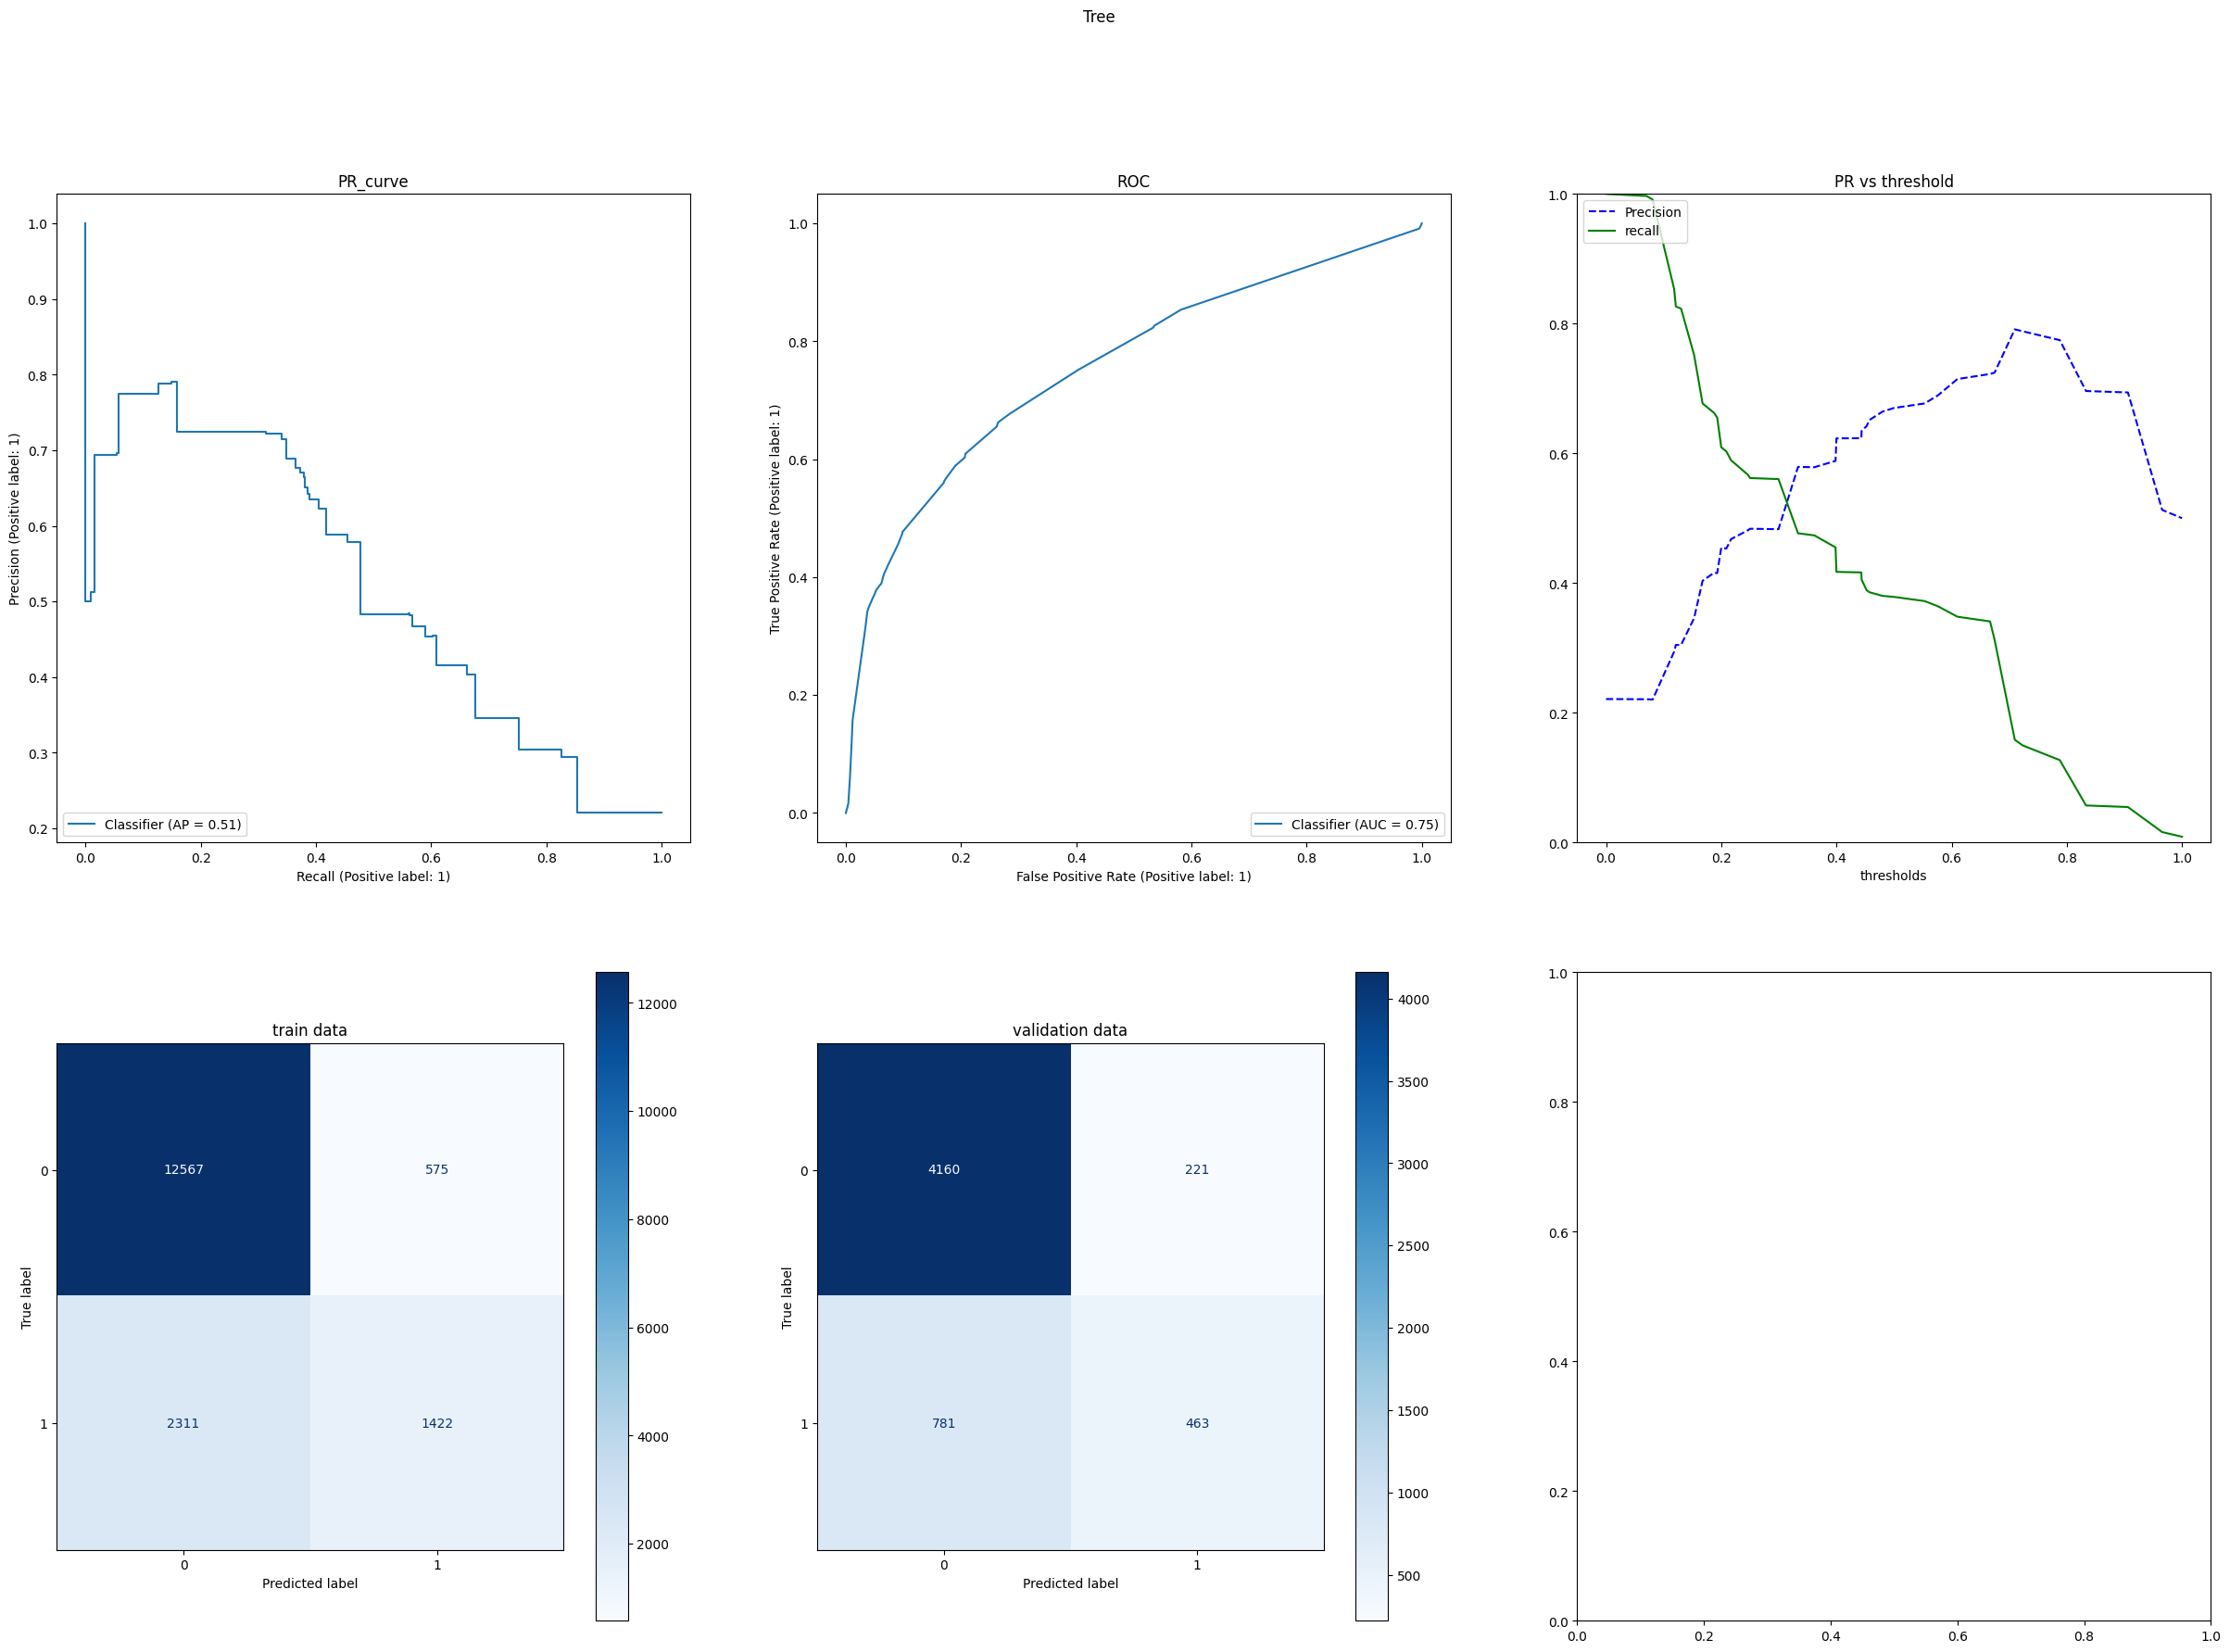

Forest
[[4204  177]
 [ 857  387]]

train scores
accuracy : 0.8250074074074074
precision : 0.7401477832512315
recall : 0.32199303509241894
f1_score: 0.44875863356356166

Val scores
accuracy : 0.8161777777777778
precision : 0.6861702127659575
recall : 0.31109324758842444
f1_score: 0.42809734513274333


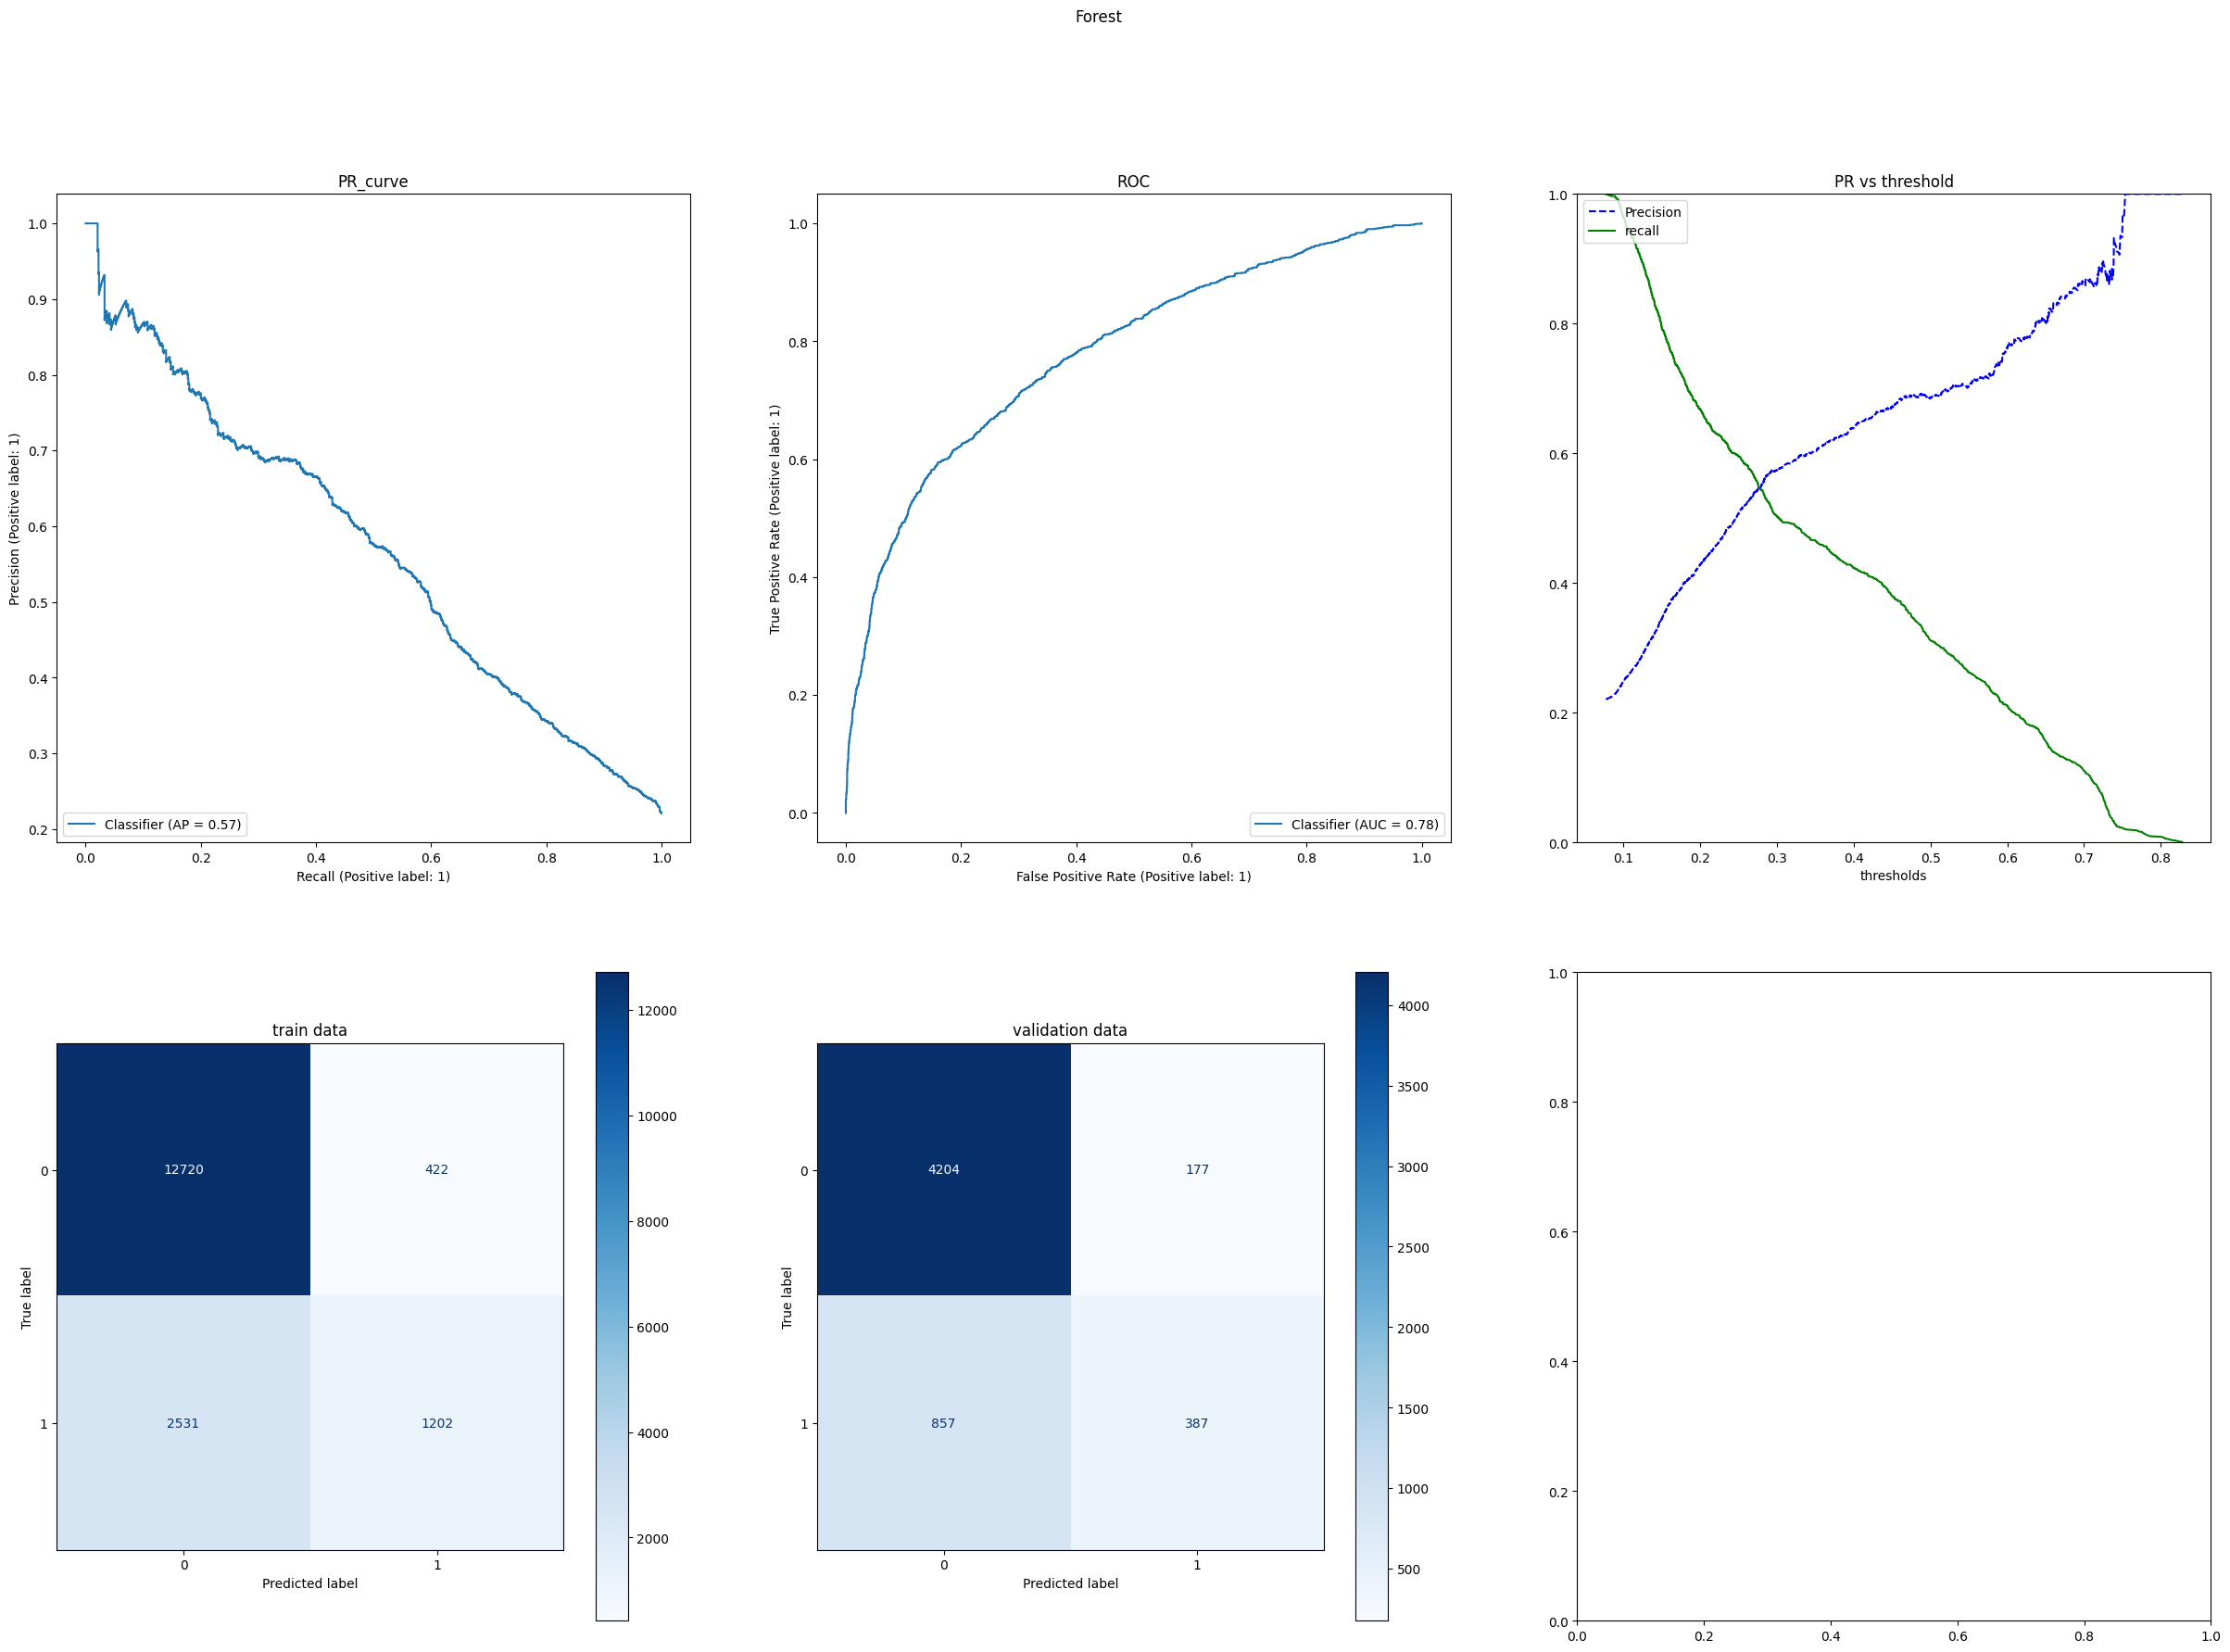

Ada
[[4203  178]
 [ 821  423]]

train scores
accuracy : 0.8181333333333334
precision : 0.688422247446084
recall : 0.324939726761318
f1_score: 0.44149226569608735

Val scores
accuracy : 0.8224
precision : 0.7038269550748752
recall : 0.340032154340836
f1_score: 0.4585365853658537


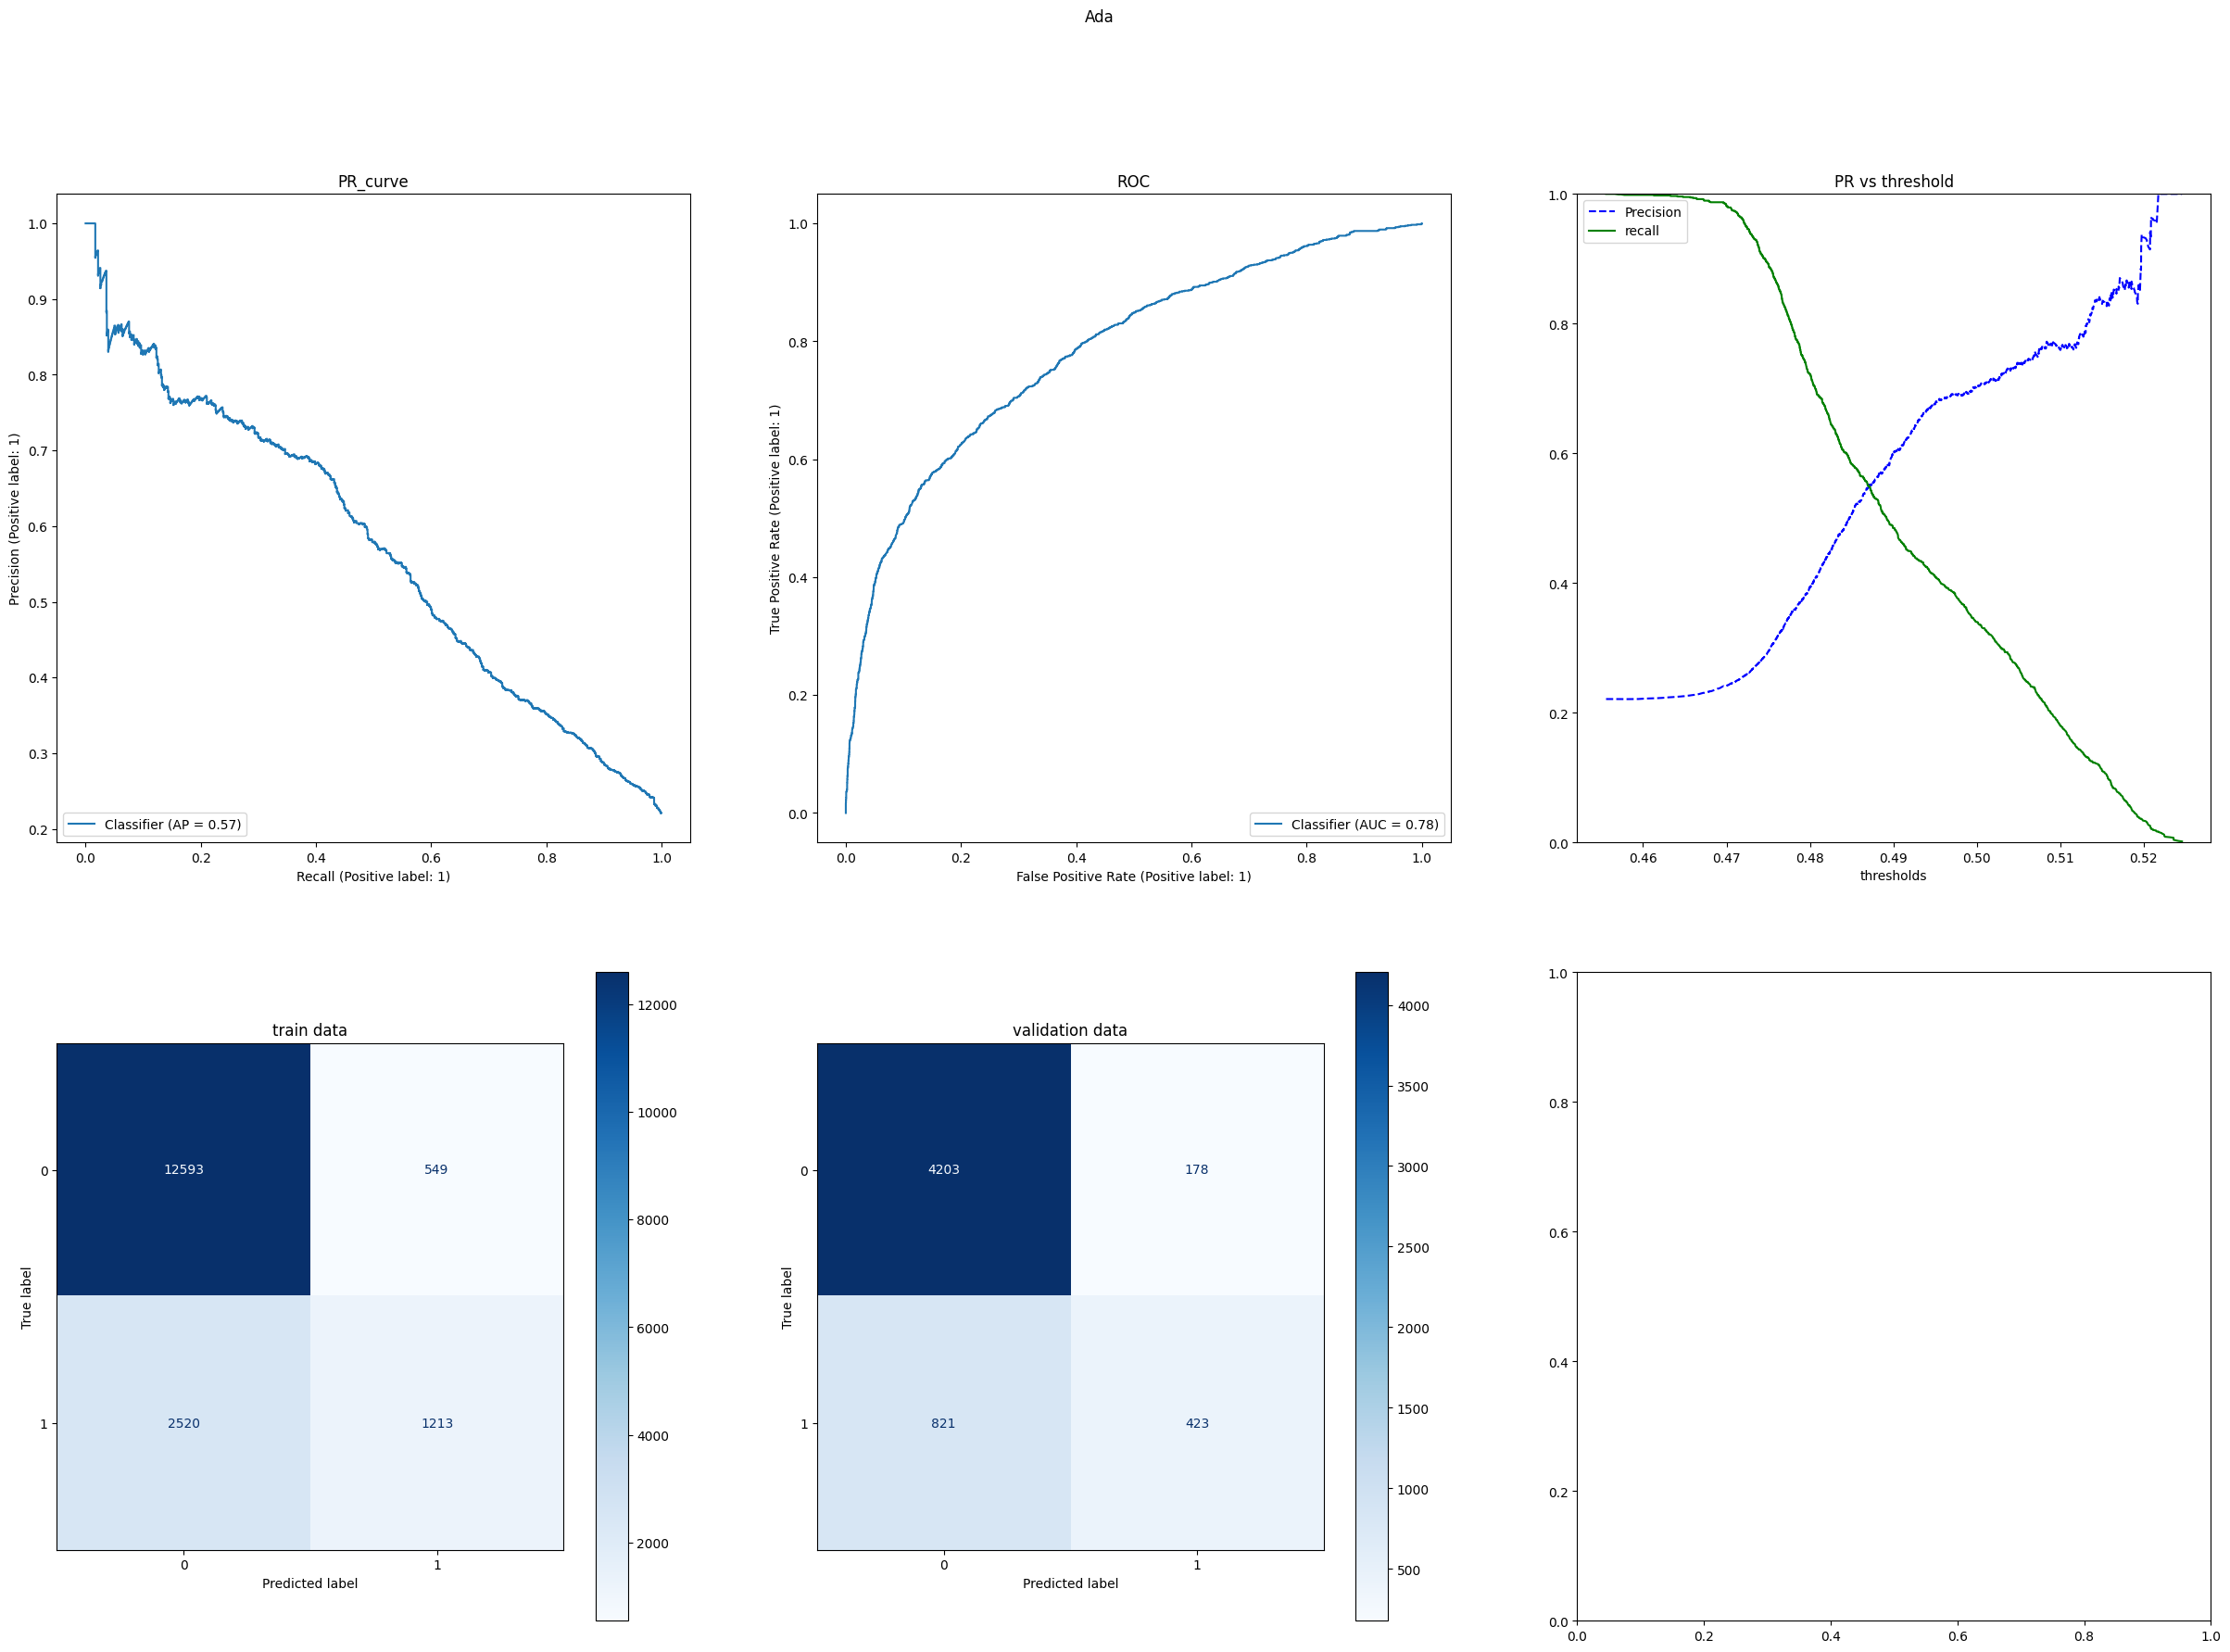

GdBoost
[[4233  148]
 [ 904  340]]

train scores
accuracy : 0.8137481481481481
precision : 0.7113180515759312
recall : 0.2660058933833378
f1_score: 0.3872099824527198

Val scores
accuracy : 0.8129777777777778
precision : 0.6967213114754098
recall : 0.2733118971061093
f1_score: 0.3926096997690531


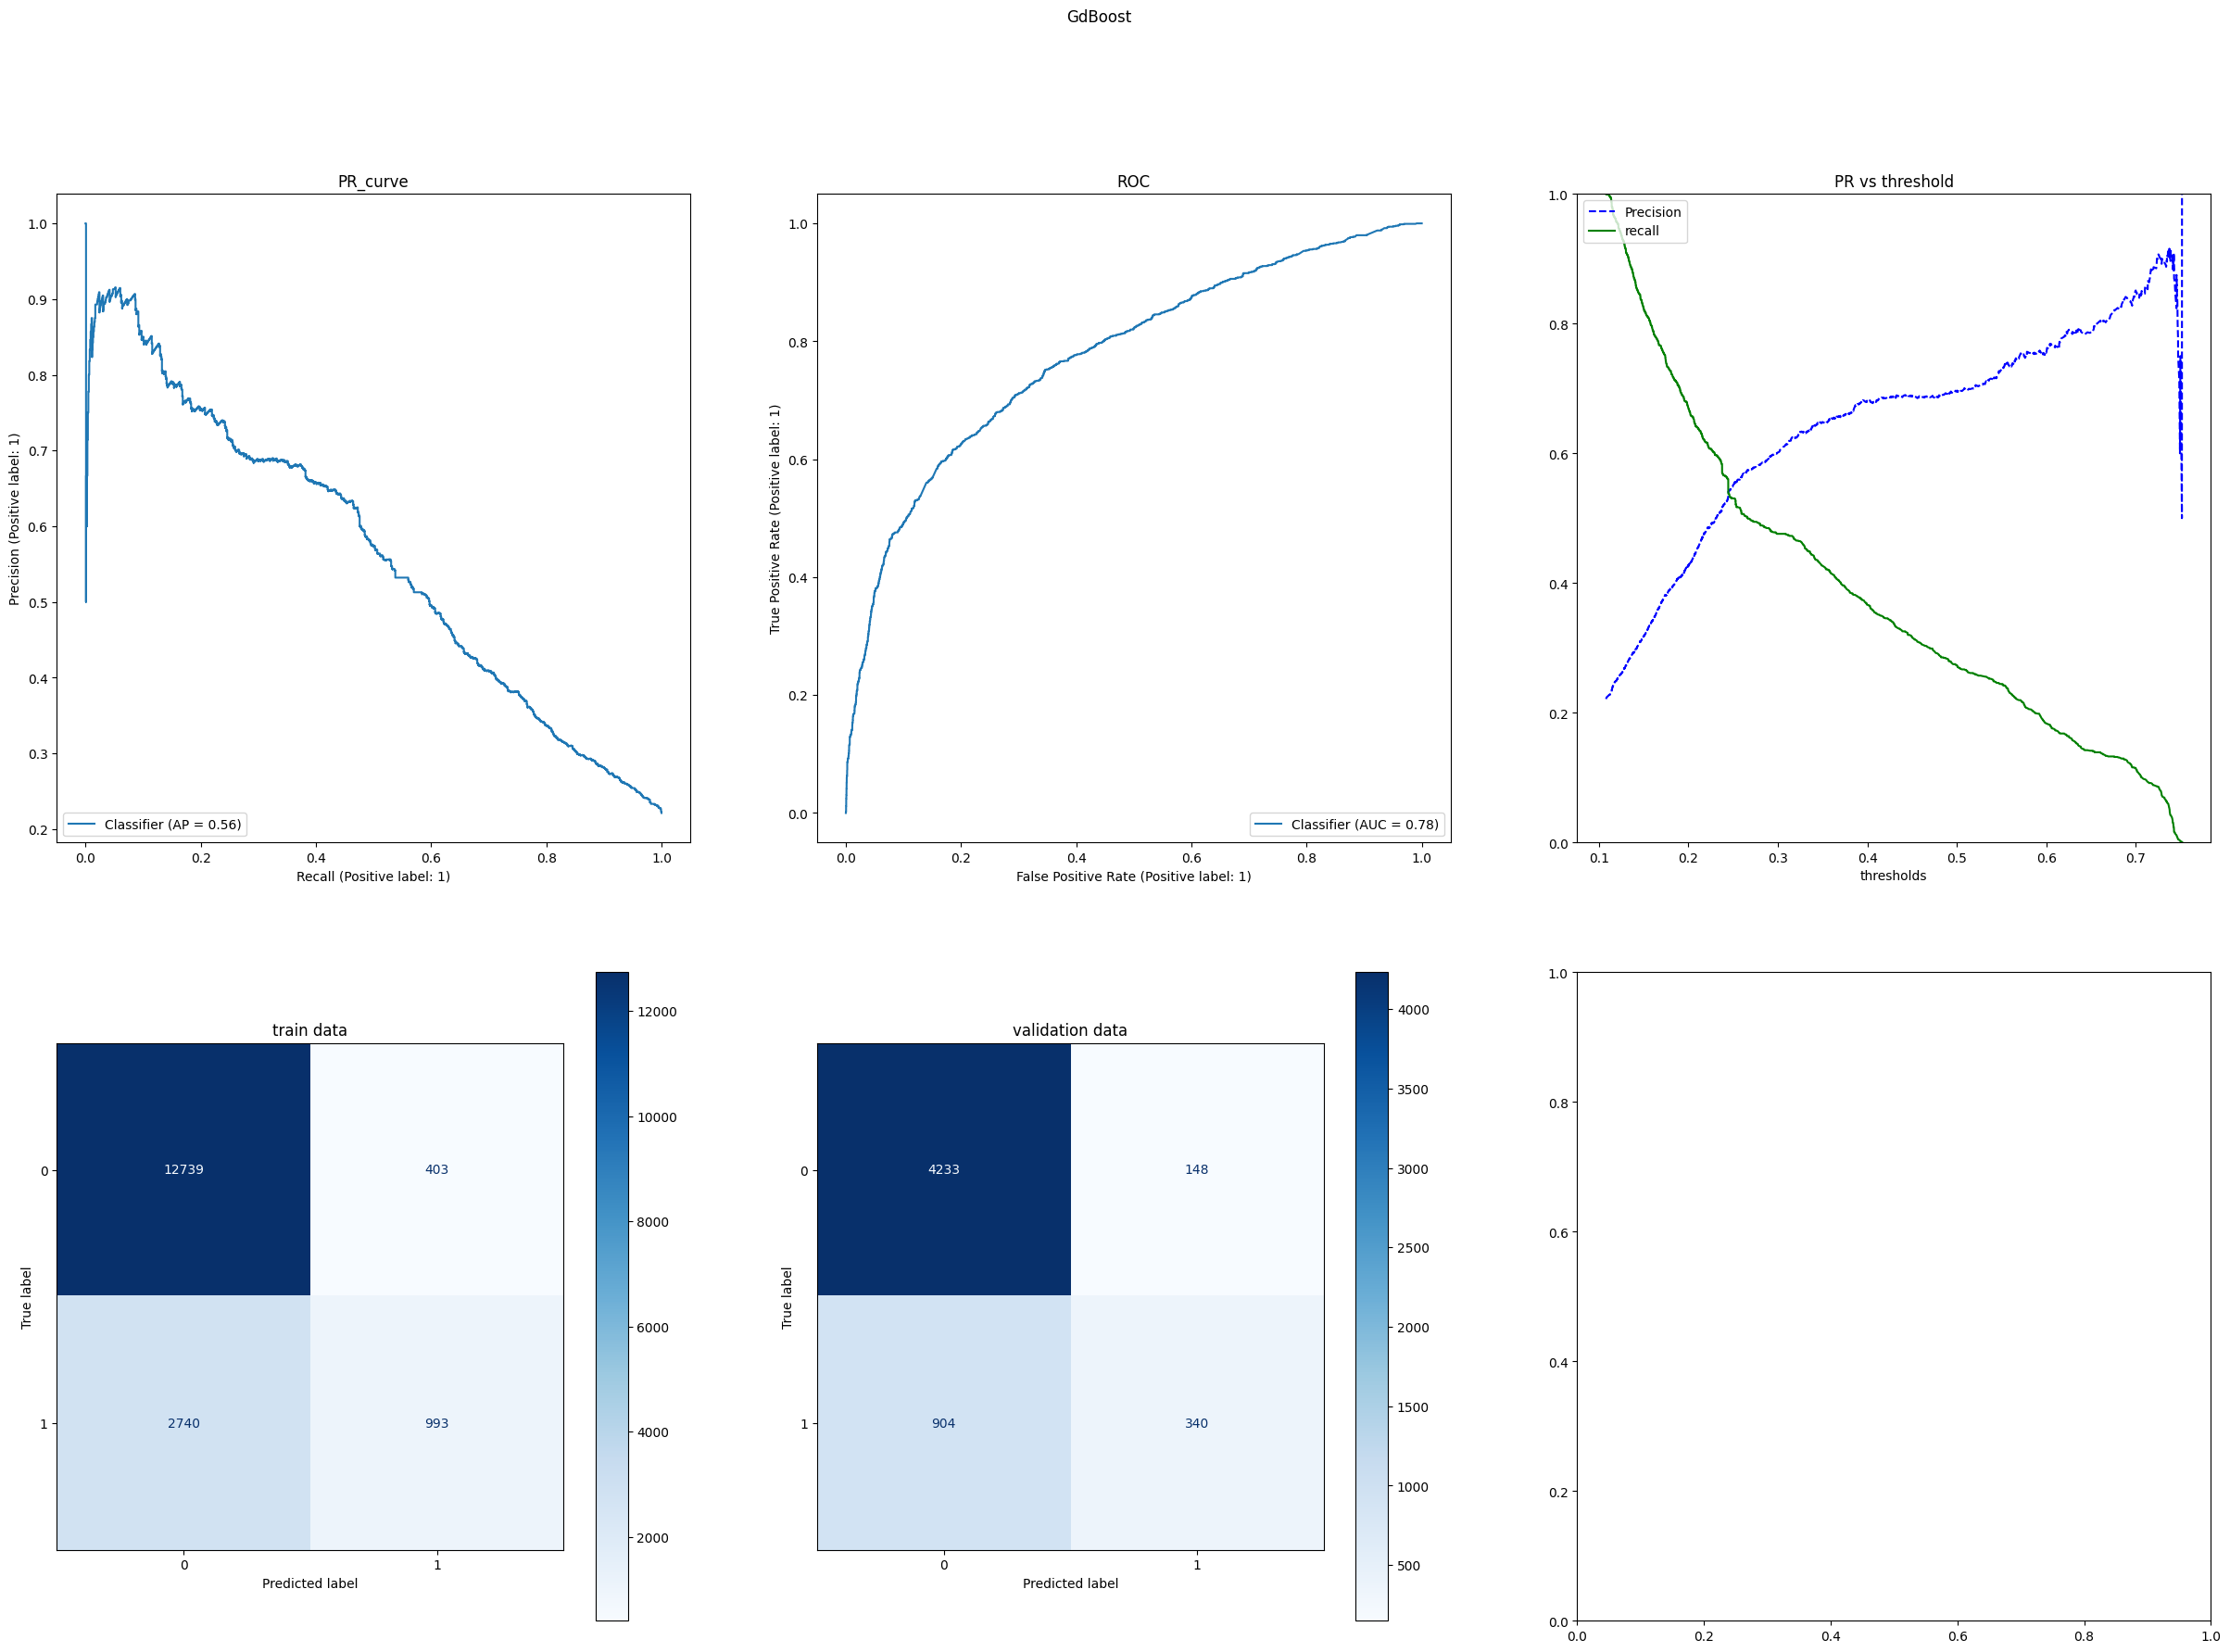

In [41]:
my_base_transform = BasicTransformer(scale='non')
clfs = [
    DecisionTreeClassifier(max_depth=6,
                            random_state=42),
    RandomForestClassifier(n_estimators=200,
                            max_depth=6,
                            n_jobs=-1,
                            random_state=42),
    AdaBoostClassifier(n_estimators=200,
                        learning_rate=0.1,
                        random_state=42),
    GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.01,
                                max_depth =2,
                                max_features='sqrt',
                                random_state=42)
]


clf_names = ['Tree',
            'Forest',
            'Ada',
            'GdBoost'
]

pipe_transform = Pipeline([('base',my_base_transform),
                 #('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

#Computation
results = []
for clf in clfs:
    pipe = Pipeline([('transform',pipe_transform),
                    ('clf',clf)])
    pipe.fit(X_train,y_train)
    train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)
    score_val = pipe.predict_proba(X_val)[:,1]
    results.append({'train':train_pred,'val':val_pred,'score':score_val})

#evaluation
for clf_name,result in zip(clf_names , results):
    print(clf_name)
    cf_matrix_t = confusion_matrix(y_train,result['train'])
    cf_matrix_v = confusion_matrix(y_val,result['val'])
    print(cf_matrix_v)
    print('\n'+'train scores')
    my_score(y_train,result['train'])
    print('\n'+'Val scores')
    my_score(y_val,result['val'])
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    RocCurveDisplay.from_predictions(y_val,result['score'],ax=axes[0,1])
    display = PrecisionRecallDisplay.from_predictions(y_val,result['score'],ax=axes[0,0])
    # display.plot(cmap=plt.cm.Blues,ax=axes[0,0])
    display = ConfusionMatrixDisplay(cf_matrix_t)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
    display = ConfusionMatrixDisplay(cf_matrix_v)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
    axes[0,1].set_title('ROC')
    axes[0,0].set_title('PR_curve')
    axes[1,0].set_title('train data')
    axes[1,1].set_title('validation data')
    precisions , recalls , thresholds = precision_recall_curve(y_val, result['score'])
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
    axes[0,2].set_title('PR vs threshold')
    fig.suptitle(f'{clf_name}')
    plt.show()
    plt.close()

In [42]:
my_base_transform = BasicTransformer(scale='non')
clfs = [
    DecisionTreeClassifier(max_depth=6,
                            random_state=42),
    RandomForestClassifier(n_estimators=200,
                            max_depth=6,
                            n_jobs=-1,
                            random_state=42),
    AdaBoostClassifier(n_estimators=200,
                        learning_rate=0.1,
                        random_state=42),
    GradientBoostingClassifier(n_estimators=300,
                                learning_rate=0.01,
                                max_depth =2,
                                max_features='sqrt',
                                random_state=42)
]


clf_names = ['Tree',
            'Forest',
            'Ada',
            'GdBoost'
]

pipe_transform = Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ],memory=cache_dir)
                
#  'extractor__mymulpyts-1__estimator__alphabet': None,

#Computation
results = []
for clf in clfs:
    pipe = Pipeline([('transform',pipe_transform),
                    ('clf',clf)])
    pipe.fit(X_train,y_train)
    train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)
    score_val = pipe.predict_proba(X_val)[:,1]
    results.append({'train':train_pred,'val':val_pred,'score':score_val})

#evaluation
for clf_name,result in zip(clf_names , results):
    print(clf_name)
    cf_matrix_t = confusion_matrix(y_train,result['train'])
    cf_matrix_v = confusion_matrix(y_val,result['val'])
    print(cf_matrix_v)
    print('\n'+'train scores')
    my_score(y_train,result['train'])
    print('\n'+'Val scores')
    my_score(y_val,result['val'])
    fig, axes = plt.subplots(2,3,figsize=(30,20))
    RocCurveDisplay.from_predictions(y_val,result['score'],ax=axes[0,1])
    display = PrecisionRecallDisplay.from_predictions(y_val,result['score'],ax=axes[0,0])
    # display.plot(cmap=plt.cm.Blues,ax=axes[0,0])
    display = ConfusionMatrixDisplay(cf_matrix_t)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
    display = ConfusionMatrixDisplay(cf_matrix_v)
    display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
    axes[0,1].set_title('ROC')
    axes[0,0].set_title('PR_curve')
    axes[1,0].set_title('train data')
    axes[1,1].set_title('validation data')
    precisions , recalls , thresholds = precision_recall_curve(y_val, result['score'])
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
    axes[0,2].set_title('PR vs threshold')
    fig.suptitle(f'{clf_name}')
    plt.show()
    plt.close()

KeyError: "['log_LIMIT_BAL'] not in index"

### Grid searching pipeline

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'est__C':[0.0005,0.001,0.01,0.1,0.4,0.8,1.0],
    #'est__kernel' : ['linear','poly','rbf','sigmoid'],
    'est__kernel' : ['sigmoid'],
    'est__gamma' : ['scale']
}
search = GridSearchCV(pipe, 
                      scoring='recall',
                      param_grid=param_grid,
                      error_score='raise',
                      n_jobs=2)
search.fit(X_train,y_train)
print(f'cv results = {search.cv_results_}')
print('\n')
print(f'best estimator = {search.best_estimator_}')
print('\n')
print(f'best score = {search.best_score_}')
print('\n')
print(f'best parameter = {search.best_params_}')
print('\n')
y_pred = search.predict(X_train)
cf_matrix =confusion_matrix(y_train,y_pred)
print(cf_matrix)
print('\n')
my_score(y_train,y_pred)

### train-val analysis on best estimator

function for graphing

## With best estimator :fit, predict and save result as csv

In [ ]:

my_pipe=search.best_estimator_
my_pipe.fit(X_train,y_train)
train_pred =my_pipe.predict(X_train)
#train_prob = my_pipe.predict_proba(X_train)
val_pred =my_pipe.predict(X_val)
#val_prob = my_pipe.predict_proba(X_val)
score_val = my_pipe.decision_function(X_val)
to_csv(train_pred,'train','pred')
#to_csv(train_prob,'train','prob')
to_csv(val_pred,'val','pred')
#to_csv(val_prob,'val','prob')
to_csv(score_val,'val','decision')

## manually put best estimator : fit,predict and save result

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
my_base_transform = BasicTransformer()
my_scaler = StandardScaler()
my_SVC = SVC(**{'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'},random_state = 42)

k_type ='sigmoid'
my_pipe= Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ('scaler',my_scaler),
                ('est',my_SVC)
                ],memory=cache_dir)
my_pipe.fit(X_train,y_train)
train_pred =my_pipe.predict(X_train)
#train_prob = my_pipe.predict_proba(X_train)
val_pred =my_pipe.predict(X_val)
#val_prob = my_pipe.predict_proba(X_val)
score_val = my_pipe.decision_function(X_val)
to_csv(train_pred,f'train','SVC_time/{k_type}/pred')
#to_csv(train_prob,'train','prob')
to_csv(val_pred,f'val','SVC_time/{k_type}/pred')
#to_csv(val_prob,'val','prob')
to_csv(score_val,'val','SVC_time/{k_type}/decision')

# Sigmoid error analysis

SVC_time sigmoid
[[11501  1641]
 [ 2380  1353]]
[[3823  558]
 [ 800  444]]


train_score
precision : 0.45190380761523047
recall : 0.3624430752745781
f1_score: 0.40225955106288086

 val score
precision : 0.4431137724550898
recall : 0.35691318327974275
f1_score: 0.39536954585930545


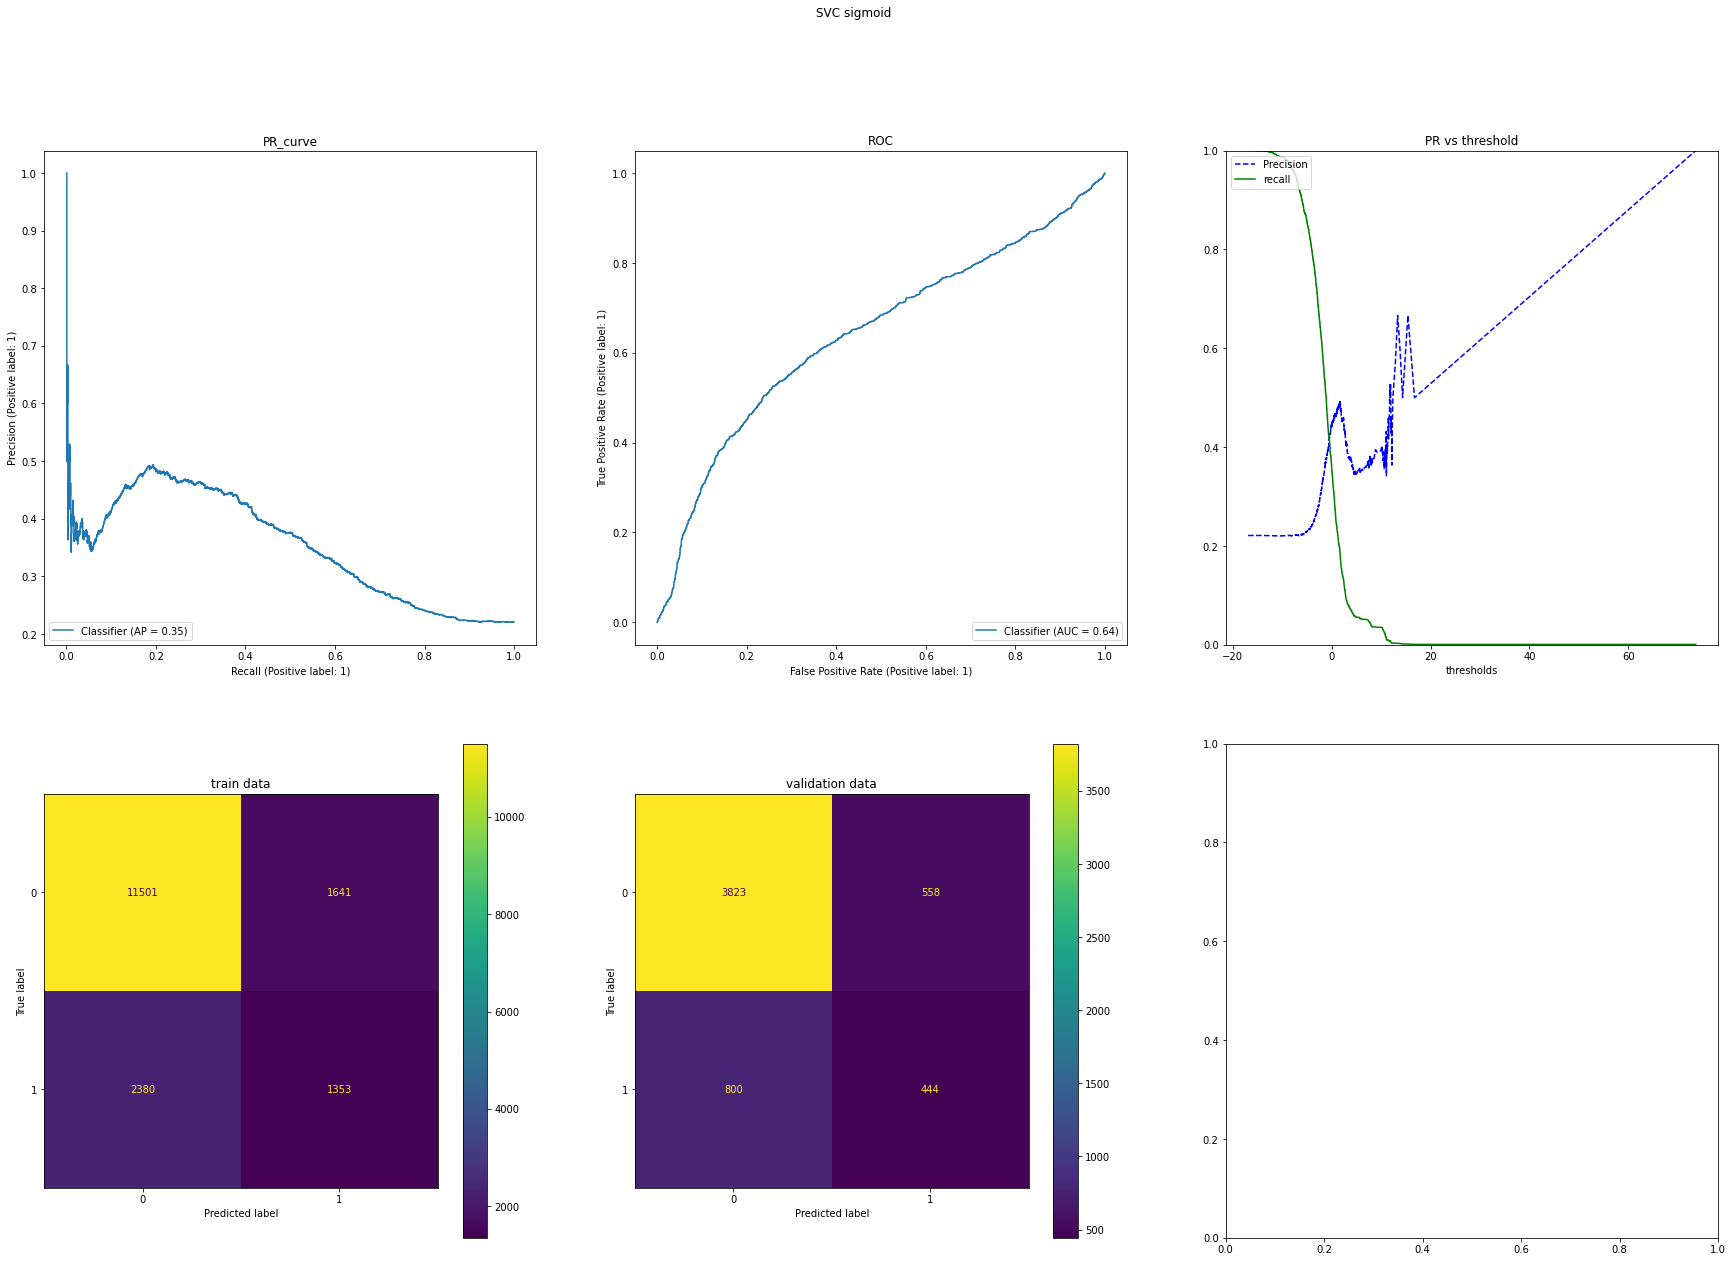

In [ ]:
k_type ='sigmoid'
fig, axes = plt.subplots(2,3,figsize=(30,20))
address=f'C:/Users/sean/Documents/git/221117_MLBasic/SW/output/SVC_time/{k_type}/bop/'
train_pred = pd.read_csv(address+'pred_train.csv').to_numpy()
val_pred = pd.read_csv(address+'pred_val.csv').to_numpy()
score_val = pd.read_csv(address+'decision_val.csv').to_numpy()


cf_matrix_t =confusion_matrix(y_train,train_pred)
print(f'SVC_time {k_type}')
print(cf_matrix_t)
cf_matrix_v =confusion_matrix(y_val,val_pred)
print(cf_matrix_v)
print('\n')
print('train_score')
my_score(y_train,train_pred)
print('\n val score')
my_score(y_val,val_pred)

RocCurveDisplay.from_predictions(y_val,score_val,ax=axes[0,1])
display = PrecisionRecallDisplay.from_predictions(y_val,score_val,ax=axes[0,0])
# display.plot(ax=axes[0,0])
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
axes[0,1].set_title('ROC')
axes[0,0].set_title('PR_curve')
axes[1,0].set_title('train data')
axes[1,1].set_title('validation data')
precisions , recalls , thresholds = precision_recall_curve(y_val, score_val)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
axes[0,2].set_title('PR vs threshold')
fig.suptitle(f'SVC {k_type}')
plt.show()
plt.close()

# RBF

## Manual best estimator

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
my_base_transform = BasicTransformer()
my_scaler = StandardScaler()
my_SVC = SVC(**{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'},random_state = 42)

k_type ='rbf'
my_pipe= Pipeline([('base',my_base_transform),
                 ('extractor',extractor),
                ('scaler',my_scaler),
                ('est',my_SVC)
                ],memory=cache_dir)
my_pipe.fit(X_train,y_train)
train_pred =my_pipe.predict(X_train)
#train_prob = my_pipe.predict_proba(X_train)
val_pred =my_pipe.predict(X_val)
#val_prob = my_pipe.predict_proba(X_val)
score_val = my_pipe.decision_function(X_val)


to_csv(train_pred,f'train',f'SVC_time/{k_type}/pred')
#to_csv(train_prob,'train','prob')
to_csv(val_pred,f'val',f'SVC_time/{k_type}/pred')
#to_csv(val_prob,'val','prob')
to_csv(score_val,'val',f'SVC_time/{k_type}/decision')

# RBF error analysis

SVC_time rbf
[[12670   472]
 [ 2307  1426]]
[[4173  208]
 [ 840  404]]


train_score
precision : 0.7513171759747103
recall : 0.38199839271363517
f1_score: 0.5064819747824543

 val score
precision : 0.6601307189542484
recall : 0.3247588424437299
f1_score: 0.4353448275862069


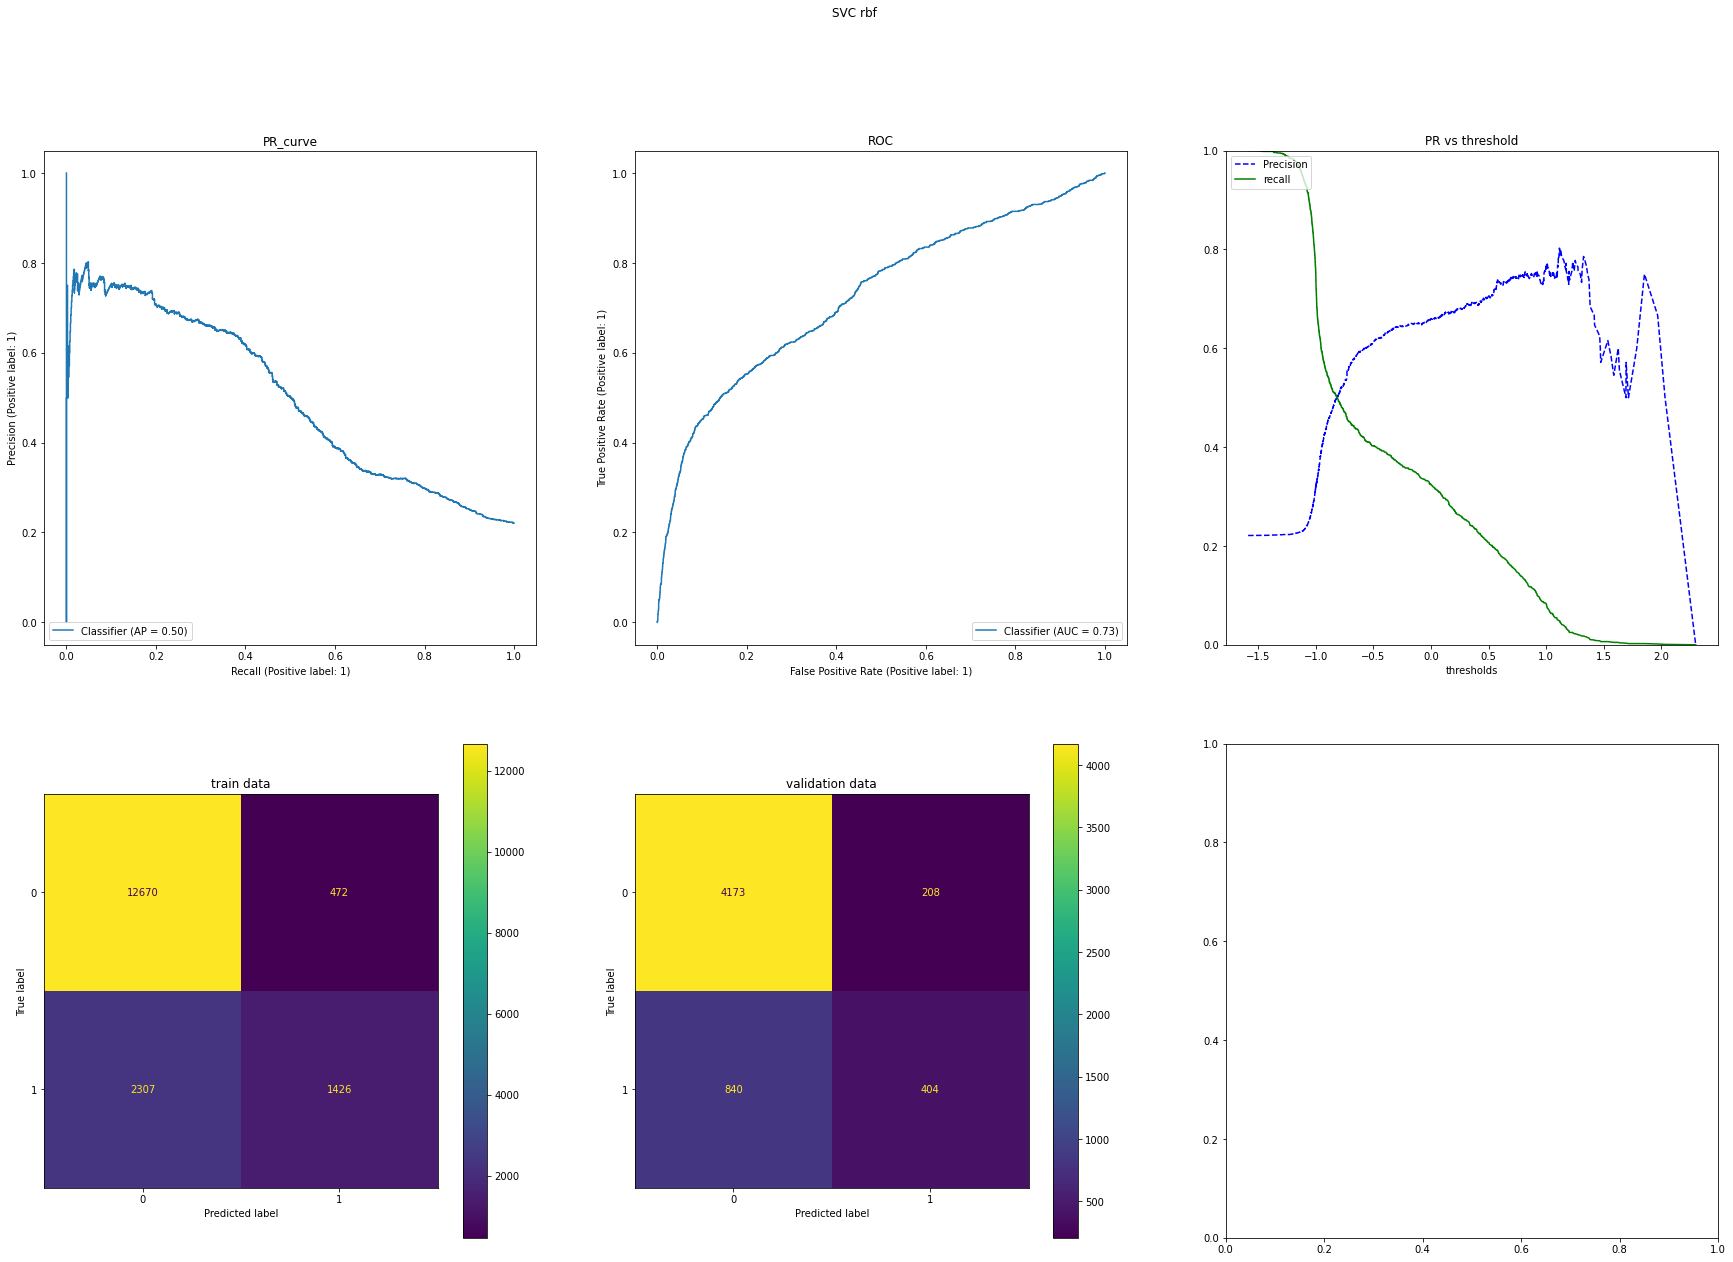

In [ ]:
k_type = 'rbf'
fig, axes = plt.subplots(2,3,figsize=(30,20))
address=f'C:/Users/sean/Documents/git/221117_MLBasic/SW/output/SVC_time/{k_type}/bop/'
train_pred = pd.read_csv(address+'pred_train.csv').to_numpy()
val_pred = pd.read_csv(address+'pred_val.csv').to_numpy()
score_val = pd.read_csv(address+'decision_val.csv').to_numpy()

print(f'SVC_time {k_type}')
cf_matrix_t =confusion_matrix(y_train,train_pred)
print(cf_matrix_t)
cf_matrix_v =confusion_matrix(y_val,val_pred)
print(cf_matrix_v)
print('\n')
print('train_score')
my_score(y_train,train_pred)
print('\n val score')
my_score(y_val,val_pred)

RocCurveDisplay.from_predictions(y_val,score_val,ax=axes[0,1])
display = PrecisionRecallDisplay.from_predictions(y_val,score_val,ax=axes[0,0])
# display.plot(ax=axes[0,0])
display = ConfusionMatrixDisplay(cf_matrix_t)
display.plot(cmap=plt.cm.Blues,ax=axes[1,0])
display = ConfusionMatrixDisplay(cf_matrix_v)
display.plot(cmap=plt.cm.Blues,ax=axes[1,1])
axes[0,1].set_title('ROC')
axes[0,0].set_title('PR_curve')
axes[1,0].set_title('train data')
axes[1,1].set_title('validation data')
precisions , recalls , thresholds = precision_recall_curve(y_val, score_val)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds,ax=axes[0,2])
axes[0,2].set_title('PR vs threshold')
fig.suptitle(f'SVC {k_type}')
plt.show()
plt.close()